In [2]:
#Guide for Processing Sessions with Dreadds2 Class
#Imports & Setup
from myphdlib.interface.dreadds2 import Dreadds2Session
from myphdlib.interface.NR1KO import NR1Session
from myphdlib.interface.nope import NOPESession
from myphdlib.pipeline.prediction import predictSaccadeDirection
from myphdlib.pipeline.prediction import predictSaccadeEpochs
import matplotlib.pylab as plt
import os
import re
import numpy as np
from myphdlib.general.labjack import loadLabjackData
from felsen_analysis.toolkit.process import AnalysisObject
import felsen_analysis.toolkit.populations as pop
import felsen_analysis.toolkit.plots as pl

In [3]:
#session = NOPESession('/media/jbhunt/EPHYS-01/6-18-25/testNOPE')
session = NOPESession('/media/jbhunt/EPHYS-01/nopetangential/9-10-2025/ChR2GAD3')

In [5]:
matrix = session.load('labjack/matrix')
opto = matrix[:, 11]
#probe = matrix[:, 9]

In [6]:
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session.computeTimestamps(optoIndices)
#probeIndices = np.where(np.diff(probe) == 1)[0]
#p#robeTimesPre = session.computeTimestamps(probeIndices)
#probeFilter = np.where(probeTimesPre > np.min(optoTimes))[0]
#probeTimes = probeTimesPre[probeFilter]

In [29]:
from felsen_analysis.toolkit.populations import definePremotorPopulationExclusive
sessionList = ['/media/jbhunt/EPHYS-01-BACKUP/opto/9-10-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-11-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-12-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-15-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-16-25/ChR2GAD3',
              #'/media/jbhunt/EPHYS-01-BACKUP/opto/9-17-25/ChR2GAD3',
              '/media/jbhunt/EPHYS-01-BACKUP/opto/9-18-25/ChR2GAD3']
              #'/media/jbhunt/EPHYS-01-BACKUP/opto/9-19-25/ChR2GAD3']
for i, path in enumerate(sessionList):
    h5file = os.path.join(path, 'output.hdf')
    clusterFile = os.path.join(path, 'ephys/sorting/manual/spike_clusters.npy')
    premotor = definePremotorPopulationExclusive(h5file, clusterFile)
    print(premotor)

[]
[221]
[28]
[]
[]
[]


In [40]:
h5file = '/media/jbhunt/EPHYS-01-2/2025-09-10/ChR2GAD3/output.hdf'
sess = AnalysisObject(h5file)
sess.listAllDatasets()

barcodes/labjack/indices
barcodes/labjack/trains
barcodes/labjack/values
barcodes/neuropixels/indices
barcodes/neuropixels/trains
barcodes/neuropixels/values
frames/left/dropped
frames/left/intervals
frames/left/timestamps
frames/right/dropped
frames/right/intervals
frames/right/timestamps
labjack/cameras/missing
labjack/cameras/timestamps
labjack/matrix
labjack/timespace
metrics/ac
metrics/fr
metrics/pr
metrics/ql
metrics/rpvr
nptracer/labels
nptracer/points
nptracer/transformed
pose/corrected
pose/decomposed
pose/filtered
pose/interpolated
pose/missing/left
pose/missing/right
pose/reoriented
pose/uncorrected
saccades/predicted/left/dop
saccades/predicted/left/epochs
saccades/predicted/left/indices
saccades/predicted/left/labels
saccades/predicted/left/timestamps
saccades/predicted/left/ttp
saccades/predicted/left/waveforms
saccades/putative/left/indices
saccades/putative/left/waveforms
spikes/clusters
spikes/timestamps
stimuli/dg/grating/motion
stimuli/dg/grating/timestamps
stimuli/d

In [22]:
tmp_clusters = []
for unit in session.population:
    tmp_clusters.append(unit.cluster)

In [13]:
from toolkit.process import AnalysisObject
sessionZ = AnalysisObject('/media/jbhunt/EPHYS-01/6-18-25/testNOPE/outputzerosoffset.hdf')
sessionL = AnalysisObject('/media/jbhunt/EPHYS-01/6-18-25/testNOPE/output.hdf')
qualityZ = sessionZ.load('metrics/ql')
qualityL = sessionL.load('metrics/ql')
print(qualityL)

ModuleNotFoundError: No module named 'toolkit'

In [7]:
ampCutoff = session.load('metrics/ac')
presenceRatio = session.load('metrics/pr')
firingRate = session.load('metrics/fr')
isiViol = session.load('metrics/rpvr')
qualityLabels = session.load('metrics/ql')
goodUnits = list()
for index, unit in enumerate(session.population):
    if qualityLabels is not None and qualityLabels[index] in (0, 1):
        continue
    if ampCutoff[index] <= 0.1:
        if presenceRatio[index] >= 0.9:
            if firingRate[index] >= 0.2:
                if isiViol[index] <= 0.5:
                    goodUnits.append(unit.cluster)

IndexError: index 556 is out of bounds for axis 0 with size 556

Text(0, 0.5, 'FR (spikes/sec)')

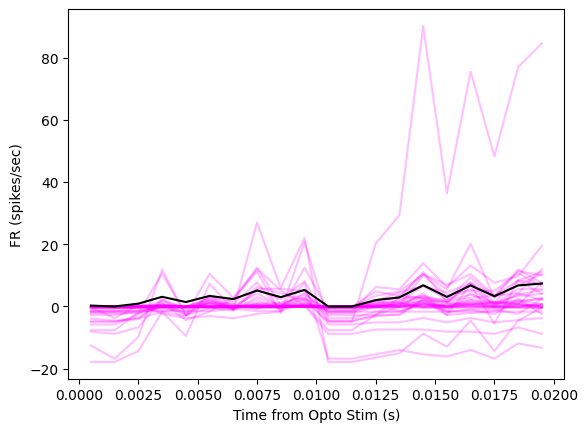

In [15]:
%matplotlib inline
fig, ax = plt.subplots()
frList = list()
for unit in session.population:
    if unit.cluster not in goodUnits:
        continue
    spikeTimes = unit.timestamps
    t, fr = unit.peth(optoTimes, (0, 0.02), 0.001)
    baseline = np.mean(fr[0:10])
    corrected = fr - baseline
    plt.plot(t, corrected, color='magenta', alpha=0.25)
    frList.append(fr)
frAvg = np.mean(frList, axis=0)
plt.plot(t, frAvg, color='k')
#plt.ylim(-50, 50)
plt.xlabel('Time from Opto Stim (s)')
plt.ylabel('FR (spikes/sec)')

Text(0, 0.5, 'Neuron')

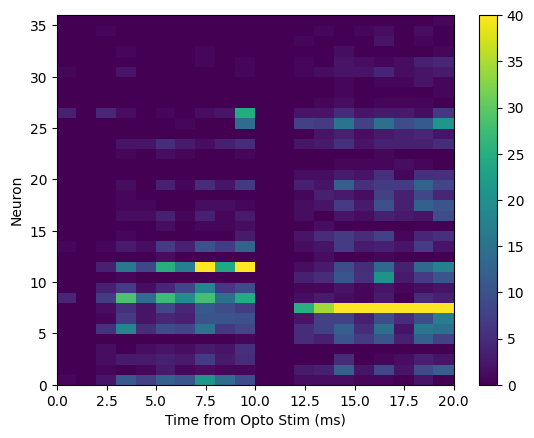

In [16]:
plt.pcolor(frList, vmax=40)
plt.colorbar()
plt.xlabel('Time from Opto Stim (ms)')
plt.ylabel('Neuron')

In [13]:
window = (-0.005, 0.02)
%matplotlib inline
sessionList = [
              '/media/jbhunt/EPHYS-01-BACKUP/opto/2025-09-22/ChR2GAD2',
            '/media/jbhunt/EPHYS-01-BACKUP/opto/2025-09-26/ChR2GAD2',
            '/media/jbhunt/EPHYS-01-BACKUP/opto/2025-09-27/ChR2GAD2',
            '/media/jbhunt/EPHYS-01-BACKUP/opto/2025-09-29/ChR2GAD2',
            '/media/jbhunt/EPHYS-01-BACKUP/opto/2025-09-30/ChR2GAD2']
path = sessionList[4]
h5file = os.path.join(path, 'output.hdf')
#h5file = '/media/jbhunt/EPHYS-01/nopetangential/9-11-2025/ChR2GAD3/output.hdf'
session = AnalysisObject(h5file)
clusterFile = os.path.join(path, 'ephys/sorting/manual/spike_clusters.npy')
uniqueSpikeClusters = np.unique(np.load(clusterFile))
qualityUnits = pop.defineQualityUnits(h5file, clusterFile)
session2 = NOPESession(path)
matrix = session2.load('labjack/matrix')
opto = matrix[:, 14]
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session2.computeTimestamps(optoIndices)
for unit in session._population():
    index = np.where(uniqueSpikeClusters == unit.cluster)[0].item()
    if unit.cluster in qualityUnits:
        L = list()
        #if index in premotorUnits[str(session.date)]:
            #fig, axs = plt.subplots()
        for probe in optoTimes:
            spikeTimestamps = unit.timestamps
            if not np.all(np.isfinite(spikeTimestamps)):
                print(f"[ERROR] Non-finite timestamps in unit {unit.cluster}")
            b1 = probe + window[0]
            b2 = probe + window[1]
            maskB = np.logical_and(spikeTimestamps >= b1, spikeTimestamps < b2)
            b = spikeTimestamps[maskB] - probe
            if not np.all(np.isfinite(b)):
                print(f"[ERROR] Non-finite values in trial {i} for unit {unit.cluster}: {b}")
            L.append(b)
        L1 = np.array(L)
        print(unit.cluster)
        fig, ax = plt.subplots()
        font = {'size' : 15}
        plt.rc('font', **font)
        plt.gca().invert_yaxis()
        for rowIndex, row in enumerate(L1):
            x = row
            y0 = rowIndex - 3
            y1 = rowIndex + 3
            ax.vlines(x, y0, y1, color='k', lw=2)
        ax.set_ylabel('Trial')
        ax.set_xlabel('Time from Opto Stim(sec)')
        #fig.set_figheight(10)
       # fig.set_figwidth(6)
        #ax.text(0, 0, str(unit.cluster))
        plt.tight_layout()
        plt.show()
        plt.close(fig)

640


NameError: name 'asdfadsf' is not defined

In [57]:
session0list = [44, 49, 416, 454]
session1list = [275, 279]
session2list = [80, 139, 140, 141, 199, 223, 232, 242]
session3list = [26, 49, 58, 102, 106, 117, 132, 256]
session4list = [3, 15, 67, 82, 113, 150]
session5list = [53]


#round2
session0 = [36, 43, 45, 83, 129]
session1 = [153, 163, 188, 192, 216, 231, 235, 259, 276, 287, 296, 315, 320, 353, 362, 424]
session2 = [121, 130, 204, 208, 245, 283, 285, 296, 308, 318, 334, 335, 395, 407, 421]
session3 = [47, 120, 125, 126, 127, 151, 184, 185, 189, 203, 211, 214, 271, 279, 518]

0.013


In [15]:
print(np.max(optoTimes))

6960.505


In [80]:
timespace = session.load('labjack/timespace')
print(np.where(timespace == np.min(timeList))[0])
print(timespace)

[26]
[0.0000000e+00 5.0000000e-04 1.0000000e-03 ... 3.4059985e+03 3.4059990e+03
 3.4059995e+03]


In [83]:
times = session.load('spikes/clusters')
times[0:20]

array([244, 525, 250, 410,  68,  85,  85,  55,  58, 526,  68, 526, 331,
       410,  32, 526, 101, 113, 526,  68], dtype=int32)

In [30]:
h5file = '/media/jbhunt/EPHYS-01-2/opto/2025-10-15/CMWT002/output.hdf'
#basePath = '/media/jbhunt/EPHYS-01/nopetangential/2025-09-10_09-29-10'
clusterFile = '/media/jbhunt/EPHYS-01-2/opto/2025-10-15/CMWT002/ephys/sorting/manual/spike_clusters.npy'
session2 = NOPESession('/media/jbhunt/EPHYS-01-2/opto/2025-10-15/CMWT002')
matrix = session2.load('labjack/matrix')
opto = matrix[:, 14]
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session2.computeTimestamps(optoIndices)
#clusterList, pList = defineOptoPopulationTTest(h5file, clusterFile, optoTimes)

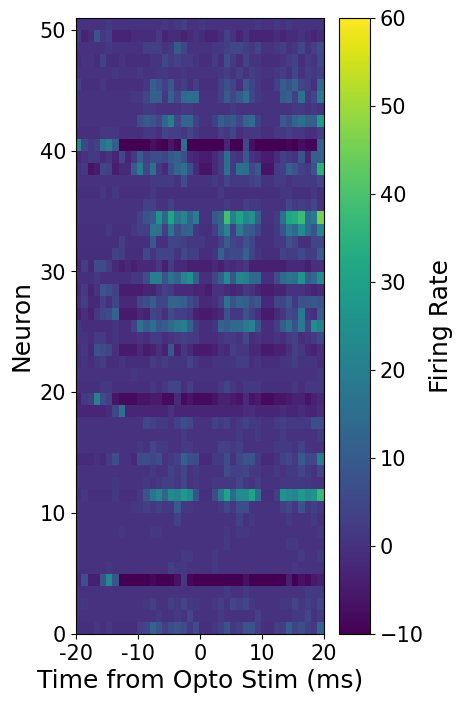

In [35]:
fig, ax = plt.subplots(figsize=(4, 8))
h5file = '/media/jbhunt/EPHYS-01-2/opto/2025-10-15/CMWT002/output.hdf'
session = AnalysisObject(h5file)
clusterFile = '/media/jbhunt/EPHYS-01-2/opto/2025-10-15/CMWT002/ephys/sorting/manual/spike_clusters.npy'
qualityUnits = pop.defineQualityUnits(h5file, clusterFile)
#sacTimes = session.load('saccades/predicted/left/timestamps')[:, 0]
frList = list()
for unit in session._population():
    if unit.cluster not in qualityUnits:
        continue
    spikeTimes = unit.timestamps
    t, fr = unit.peth(optoTimes, (-0.02, 0.02), 0.001)
    baseline = np.mean(fr[0:10])
    corrected = fr - baseline
    #plt.plot(t, corrected, color='magenta', alpha=0.25)
    frList.append(corrected)
p = ax.pcolor(frList, vmin=-10, vmax=60)
cbar = fig.colorbar(p, ax=ax)
cbar.set_label('Firing Rate', fontsize=18)
cbar.ax.tick_params(labelsize=15)
ax.set_xlabel('Time from Opto Stim (ms)', fontsize=18)
ax.set_ylabel('Neuron', fontsize=18)
ax.set_xticks([0, 10, 20, 30, 40], ['-20', '-10', '0', '10', '20'], fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_ylim(-10, 30)

22
23
24
25
27
31
33
37
40
42
44
46
47
49
54
56
64
71
73
75
76
77
81
83
84
89
92
104
111
118
120
125
126
127
129
140
142
143
144
151
153
168
169
170
174
177
180
183
184
185
188
189
192
198
201
202
203
205
207
209
211
214
217
218
224
232
235
241
244
245
248
249
250
253
255
260
261
262
264
271
277
279
281
282
294
302
304
319
321
328
337
341
345
348
350
351
357
358
359
361
368
372
375
376
377
380
384
385
387
388
390
391
392
393
394
395
398
400
407
408
410
411
413
415
419
420
423
424
428
429
432
435
443
445


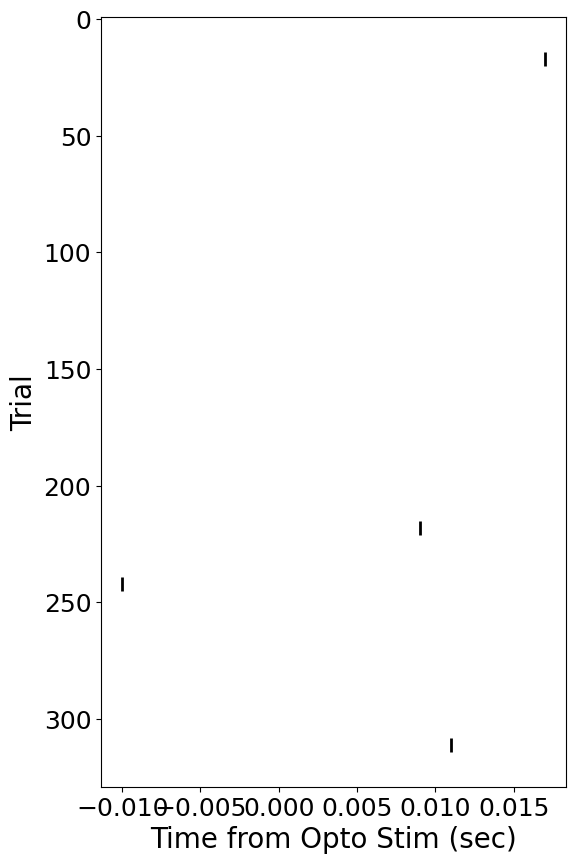

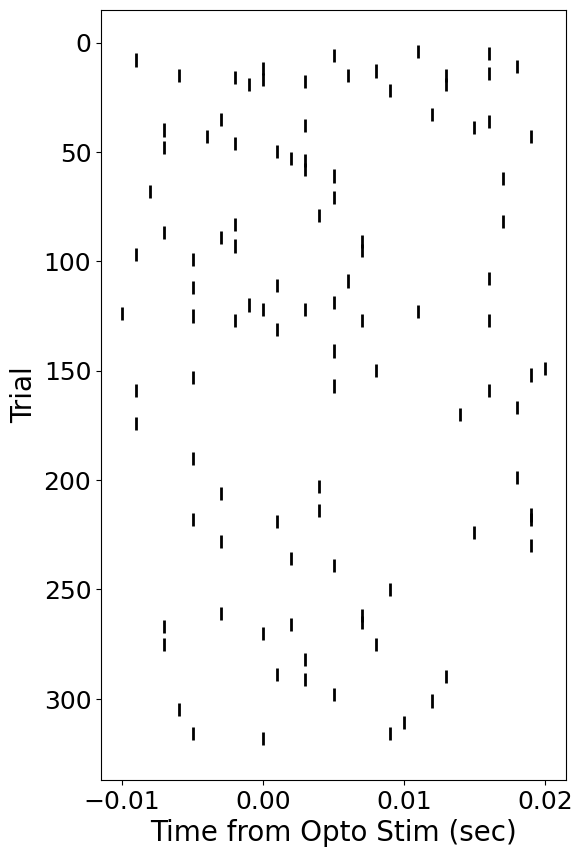

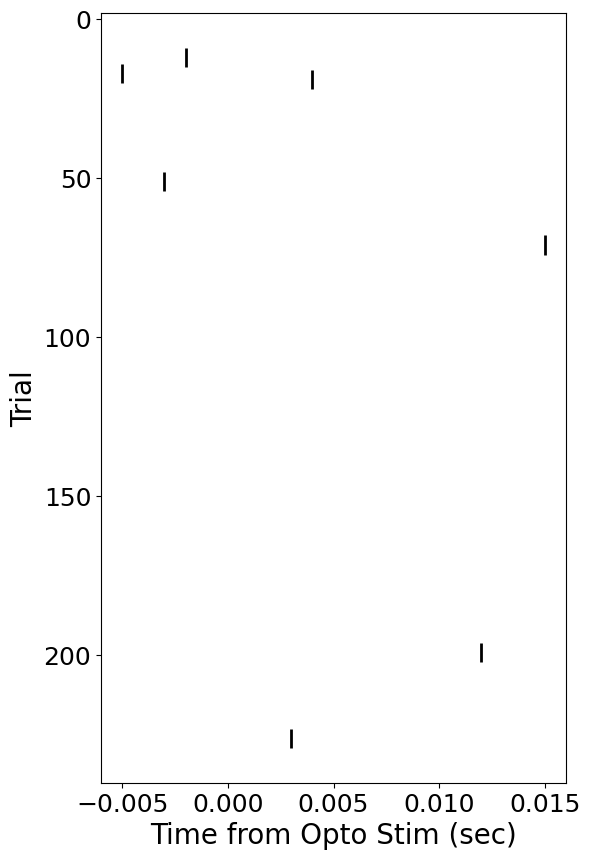

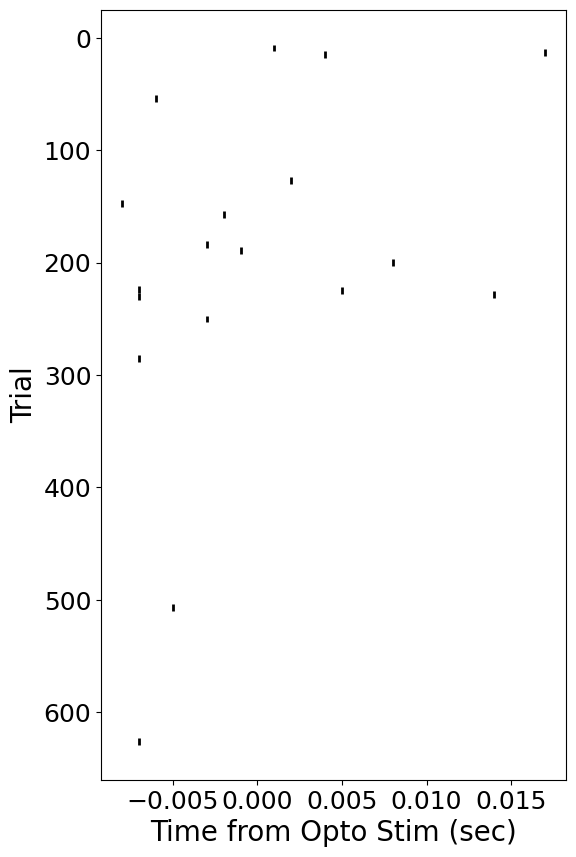

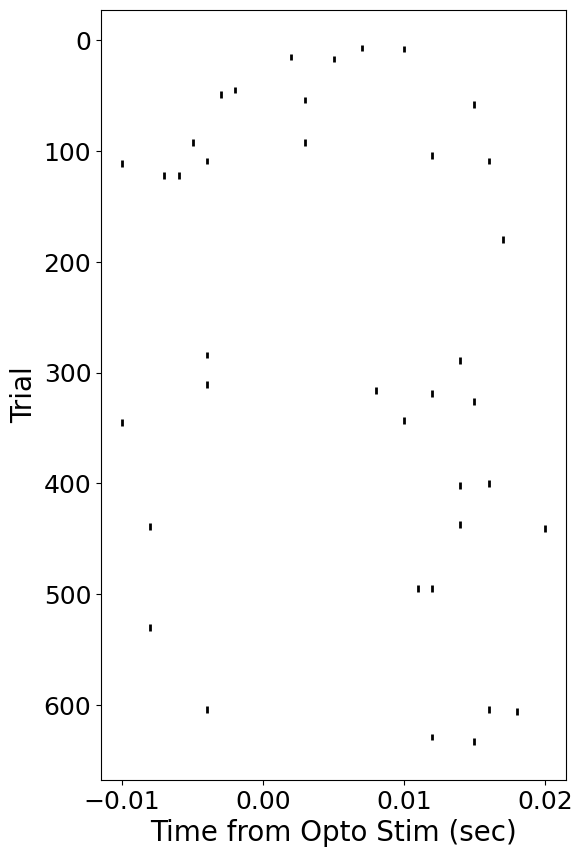

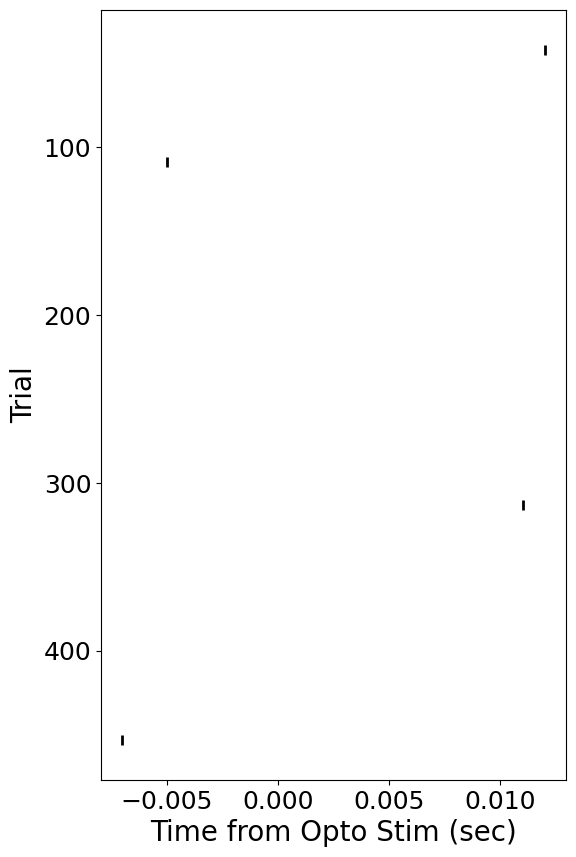

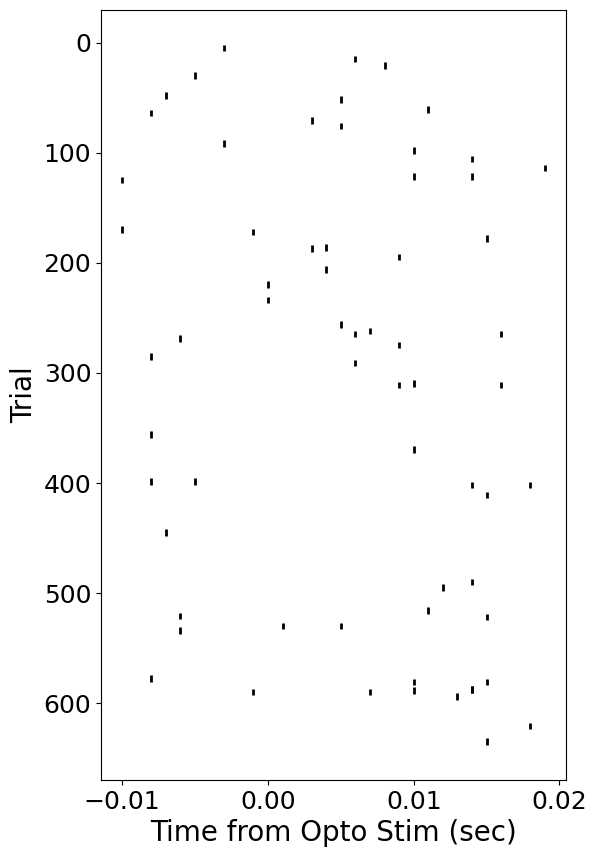

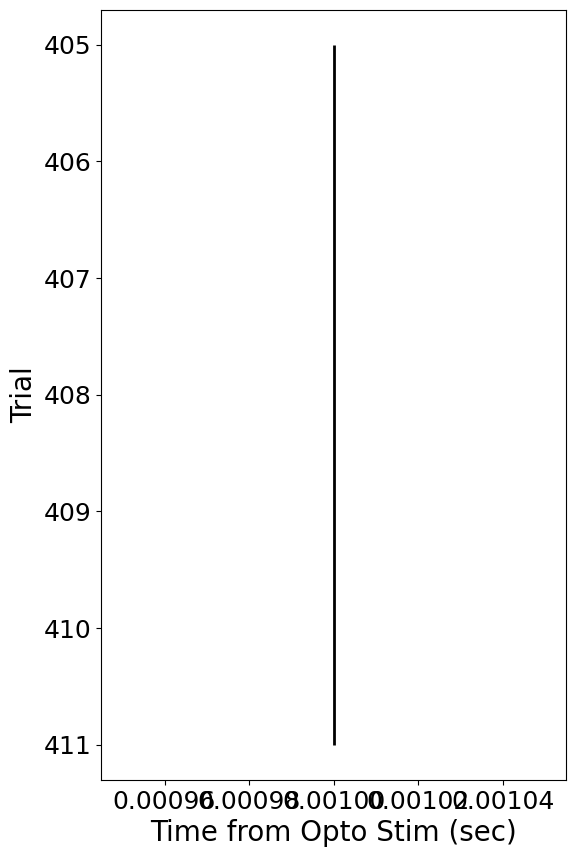

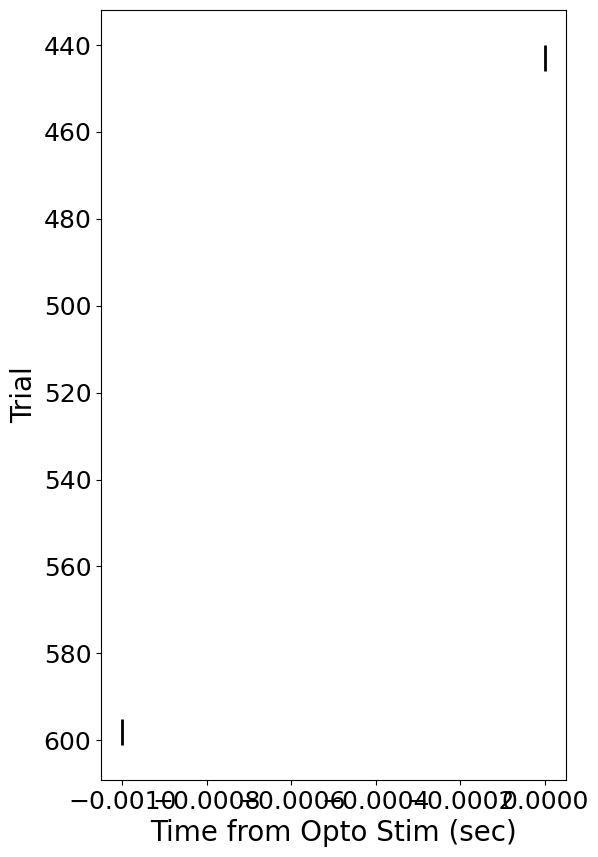

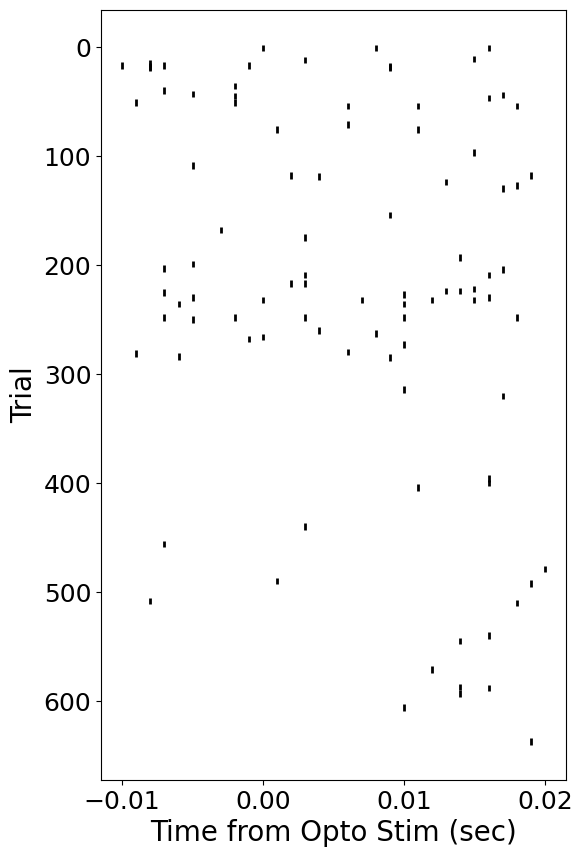

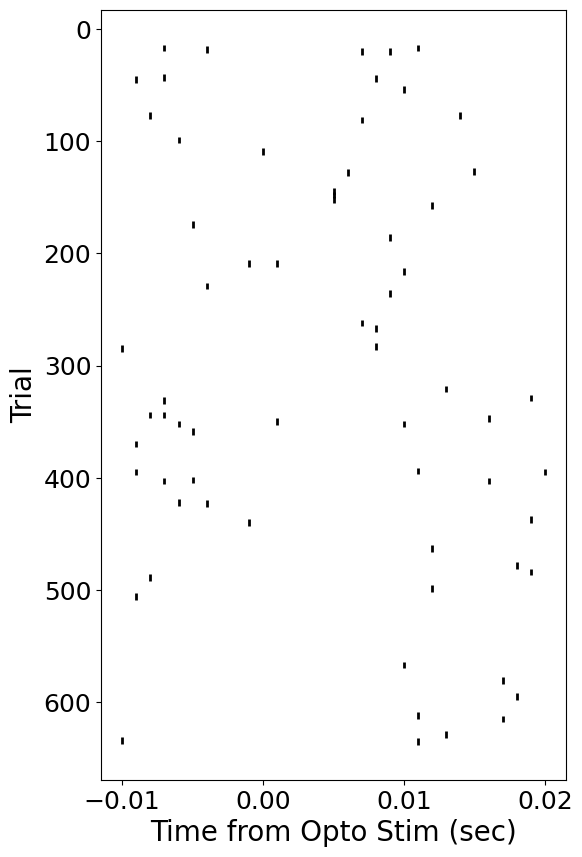

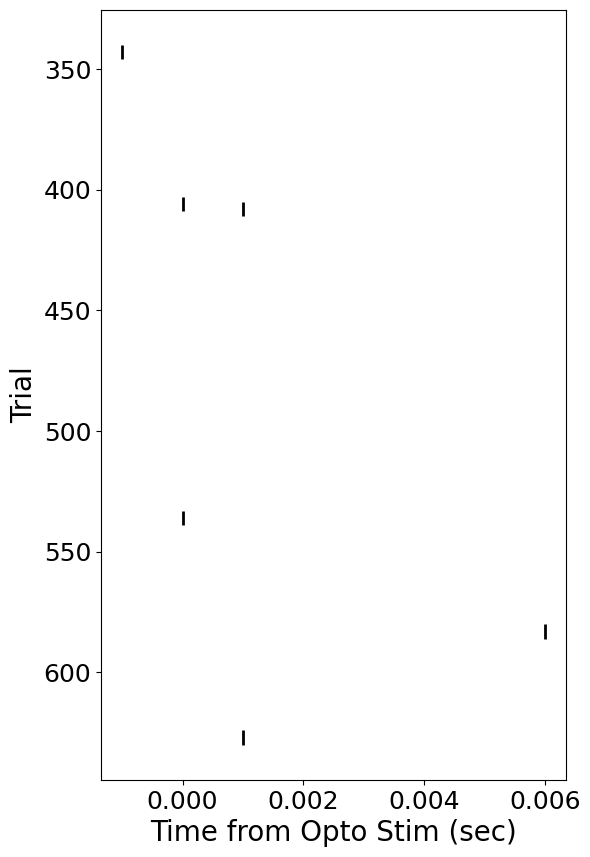

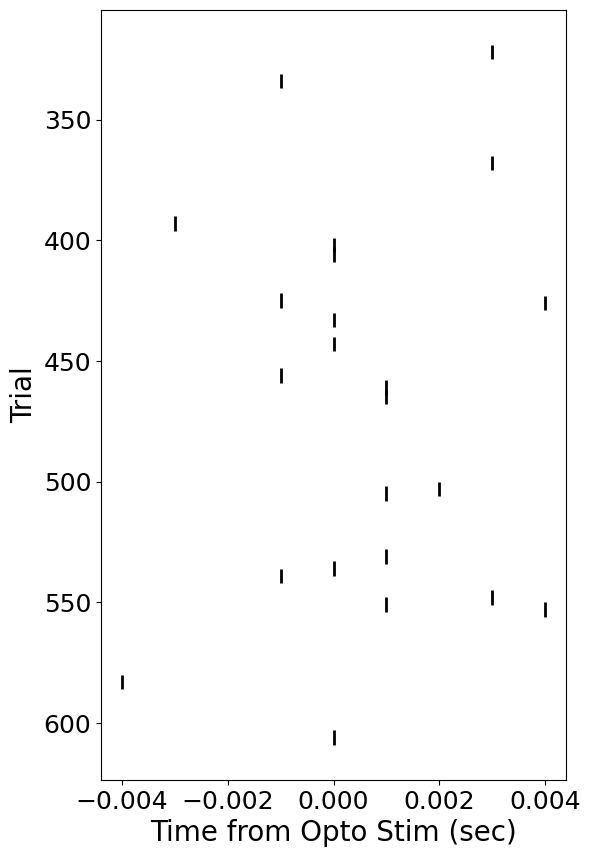

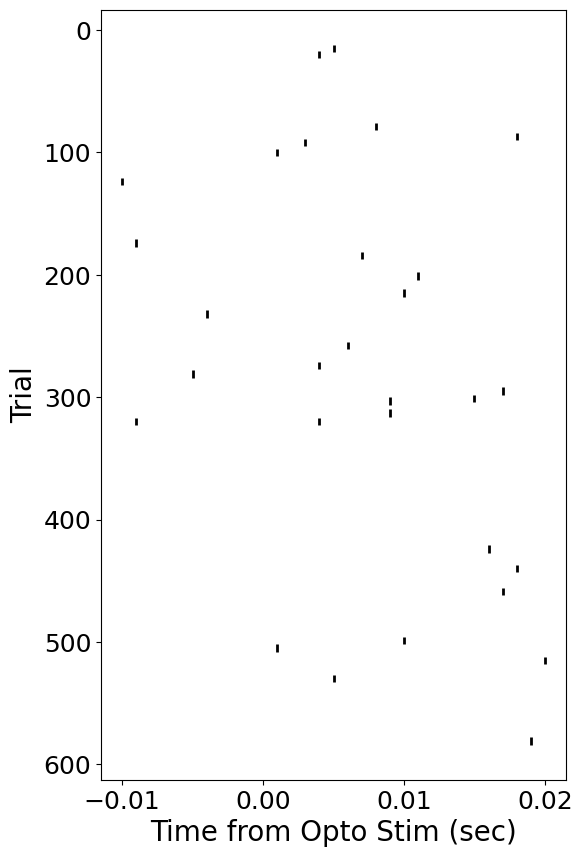

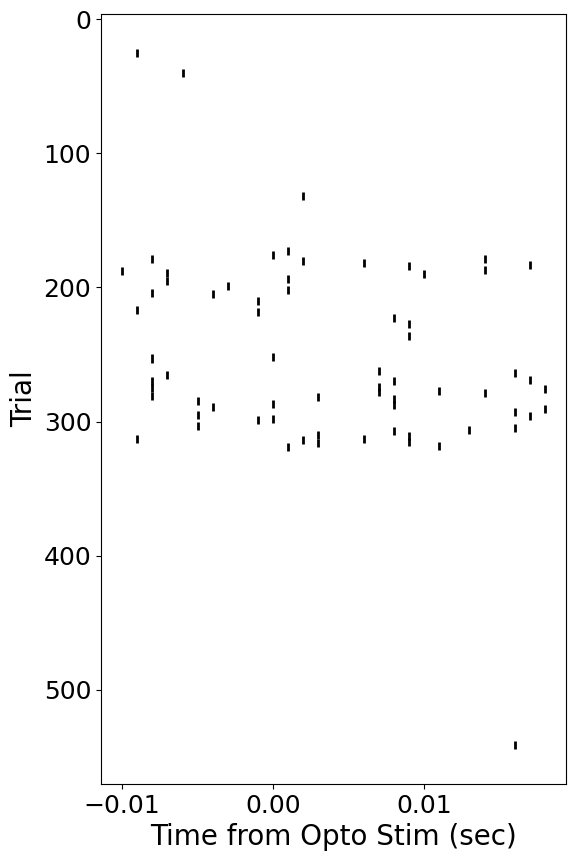

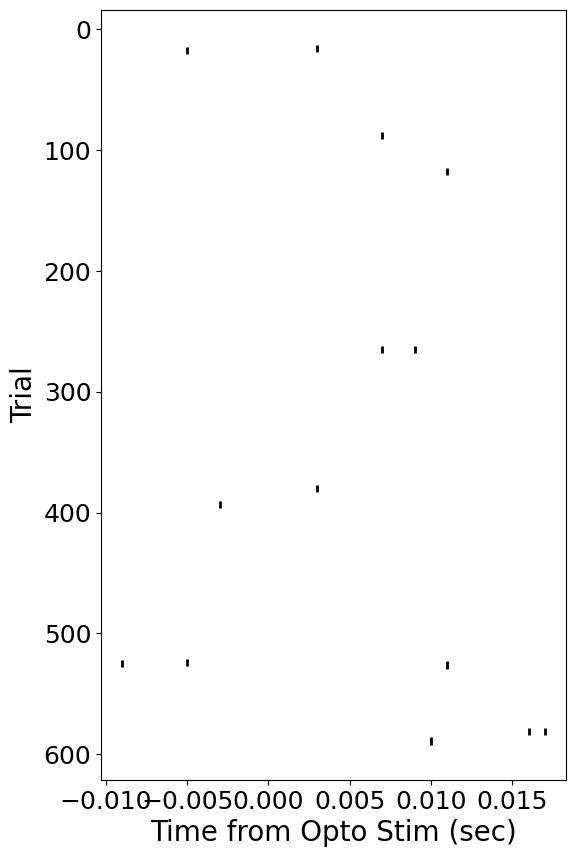

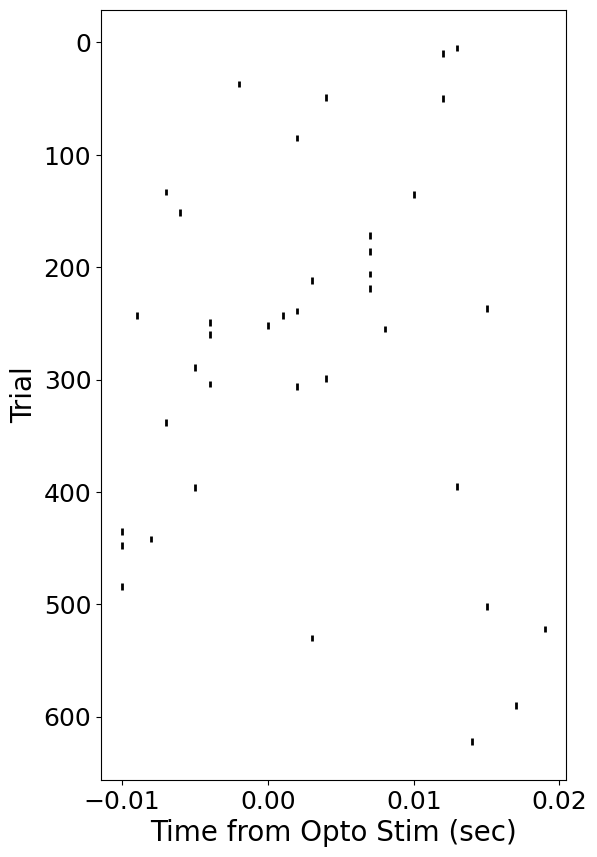

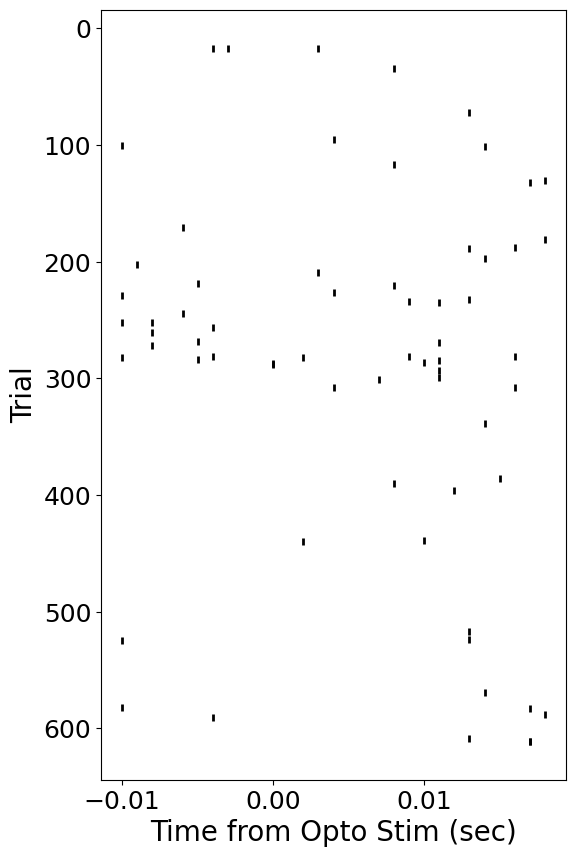

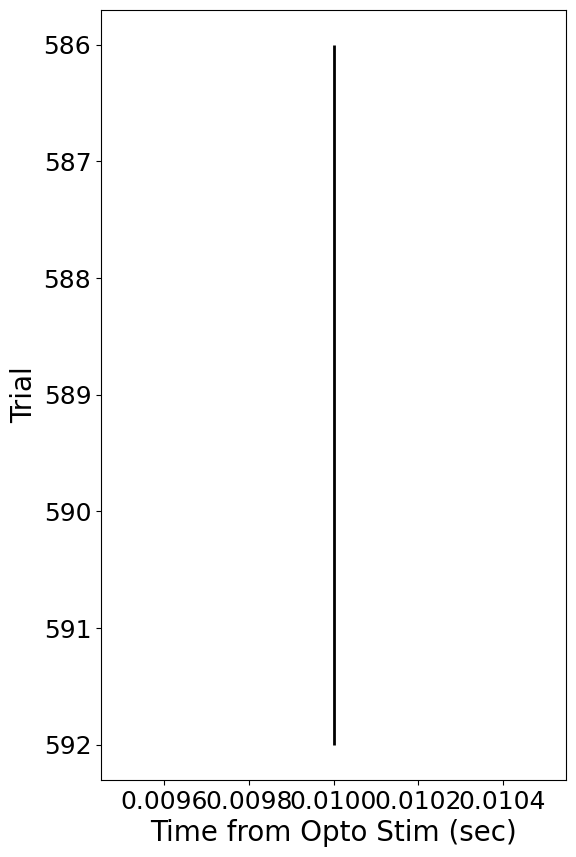

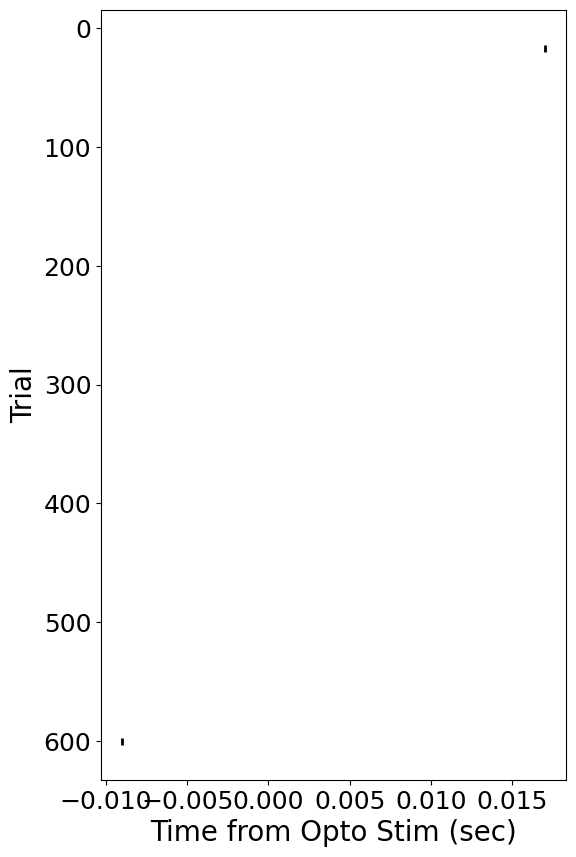

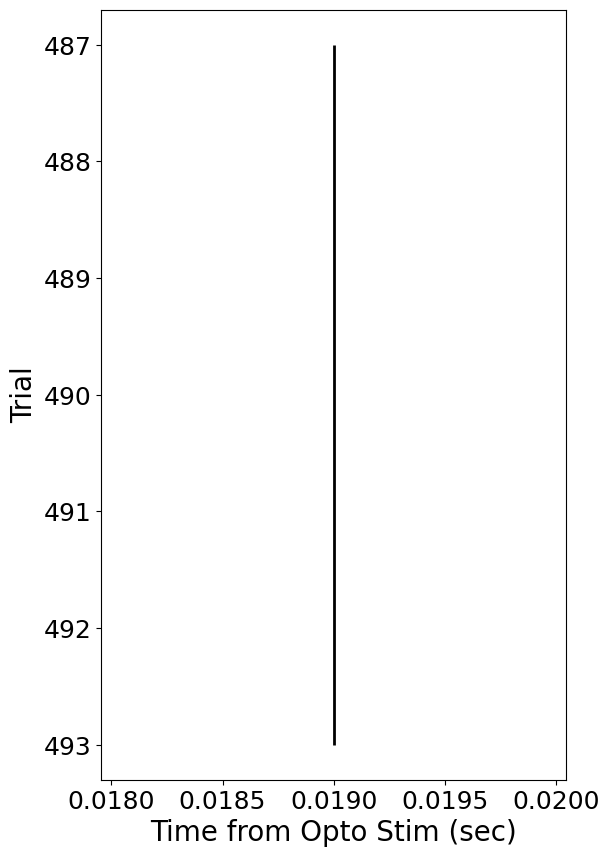

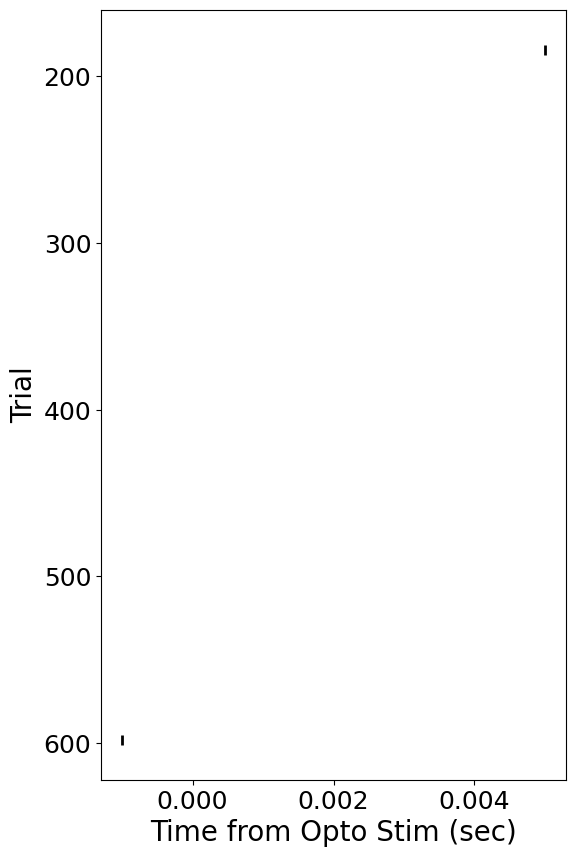

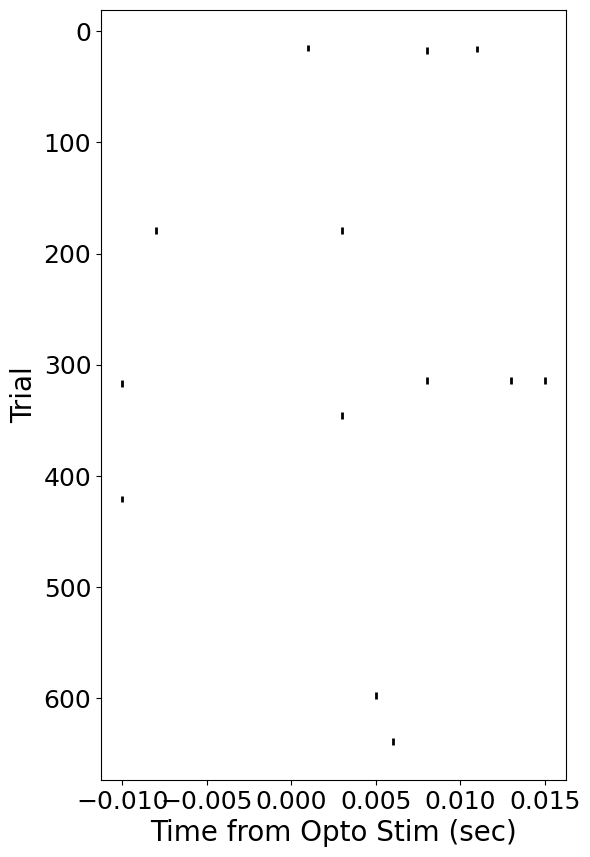

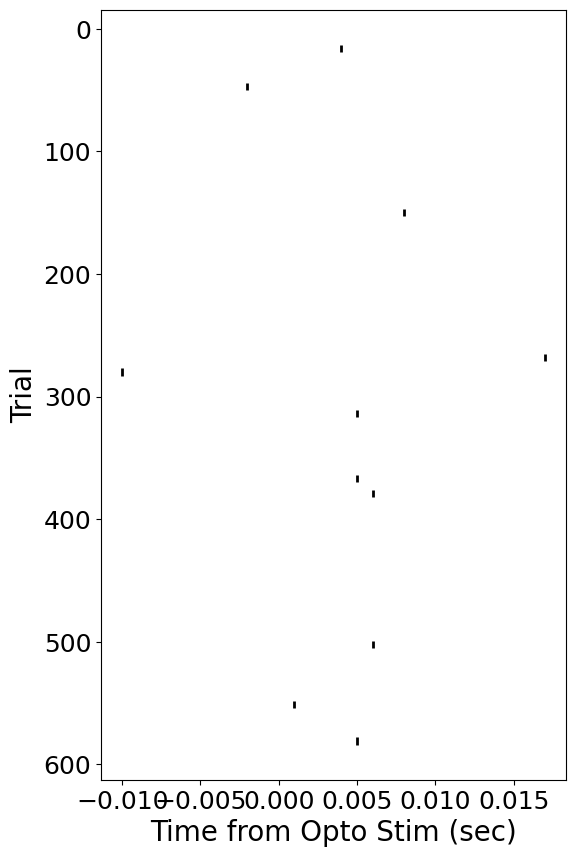

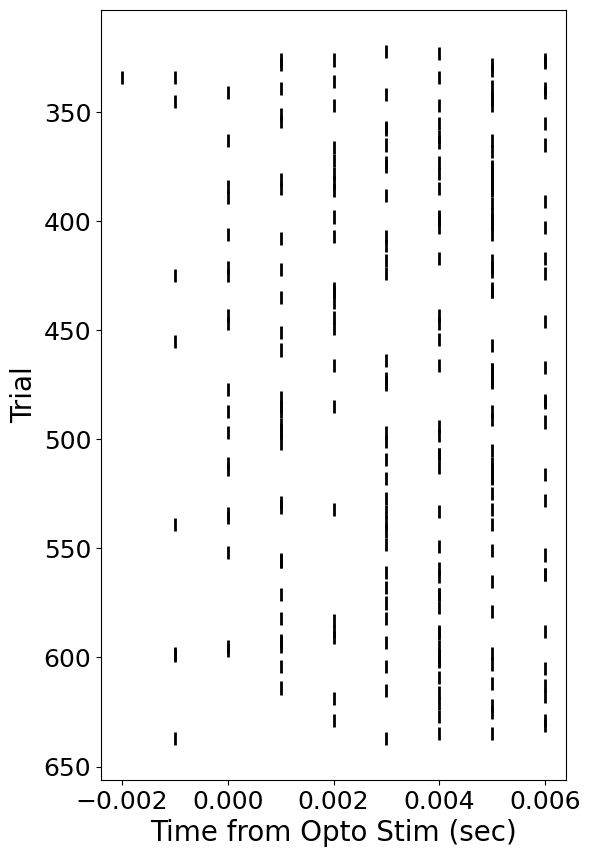

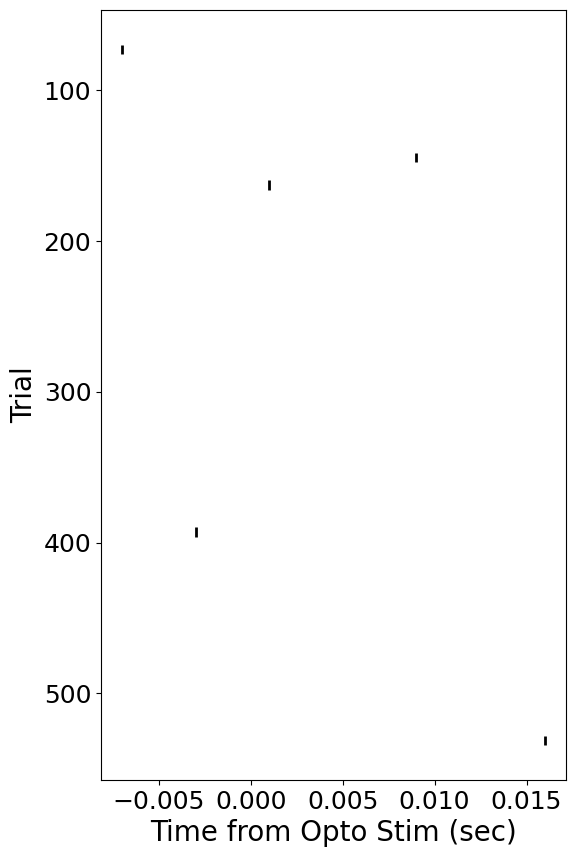

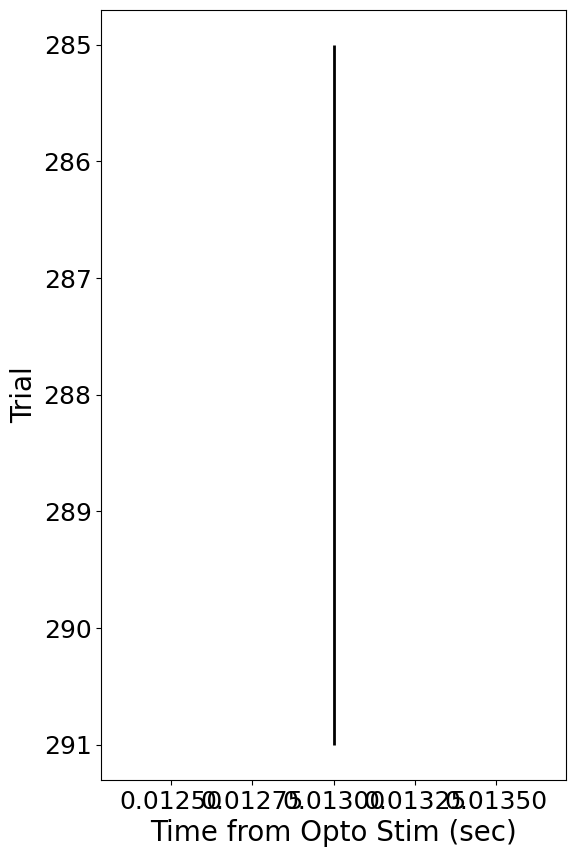

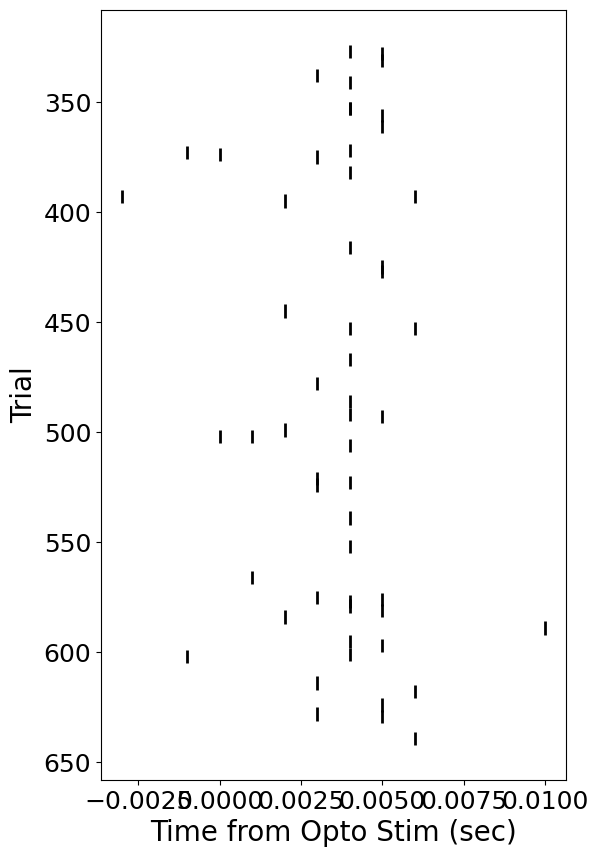

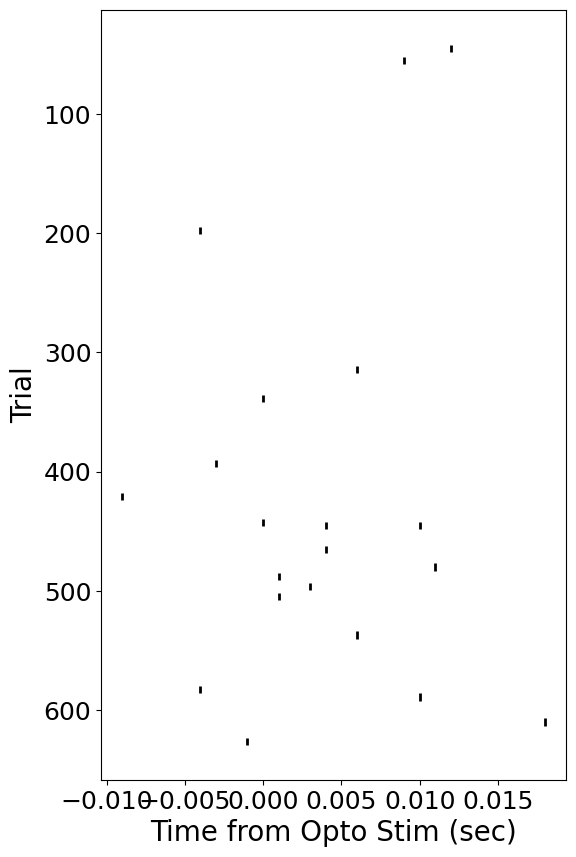

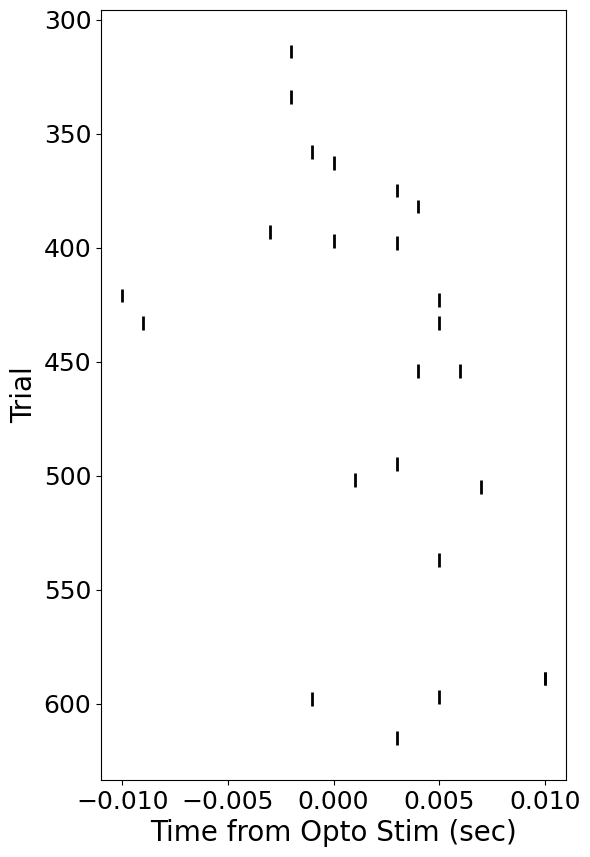

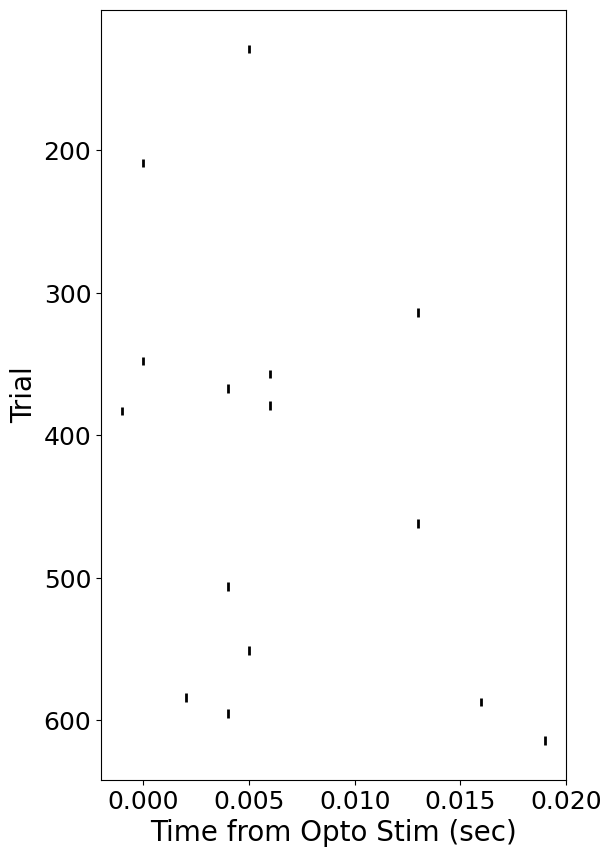

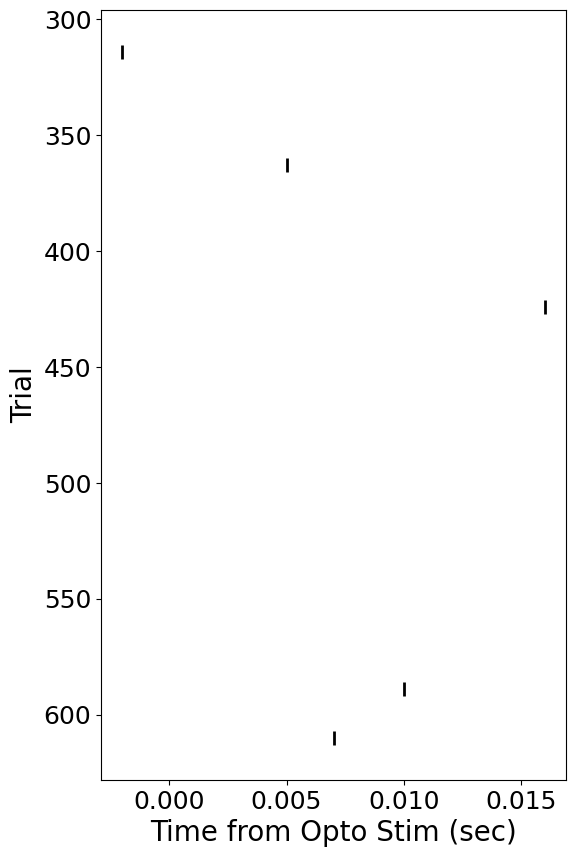

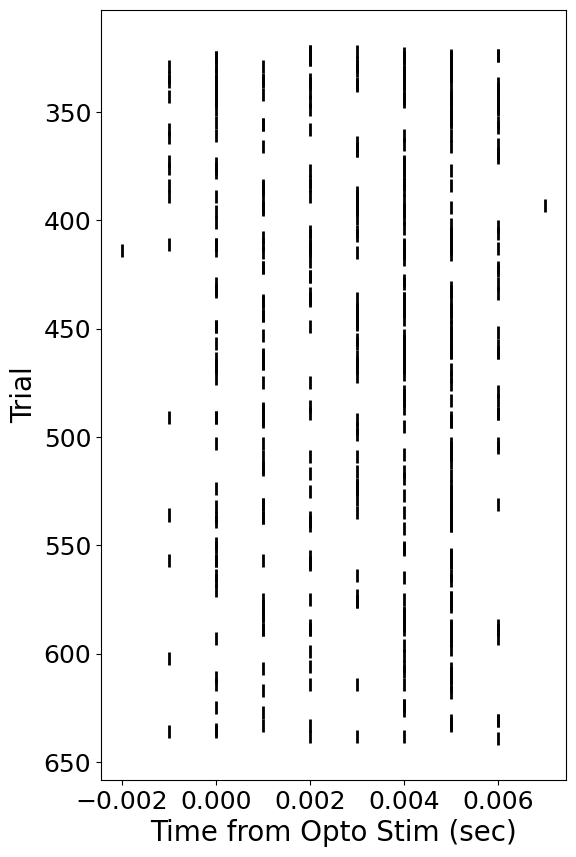

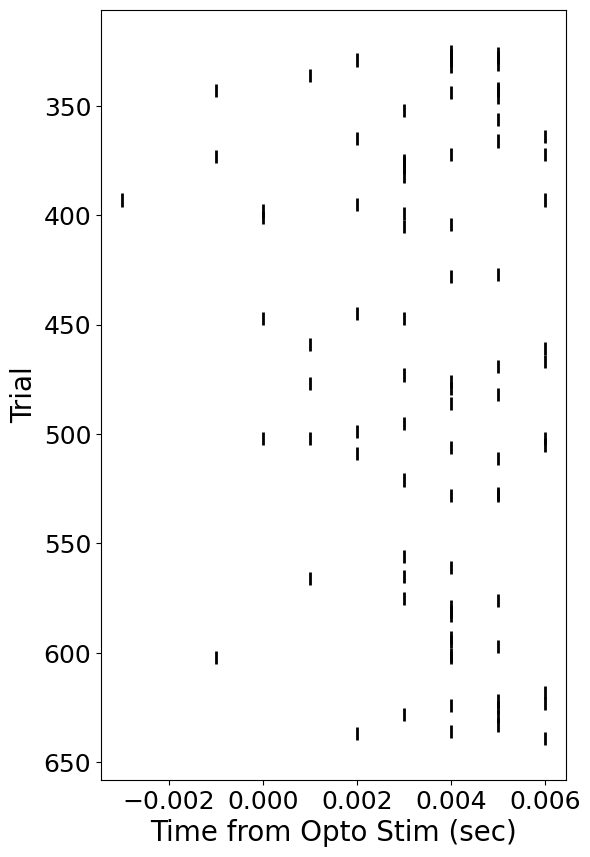

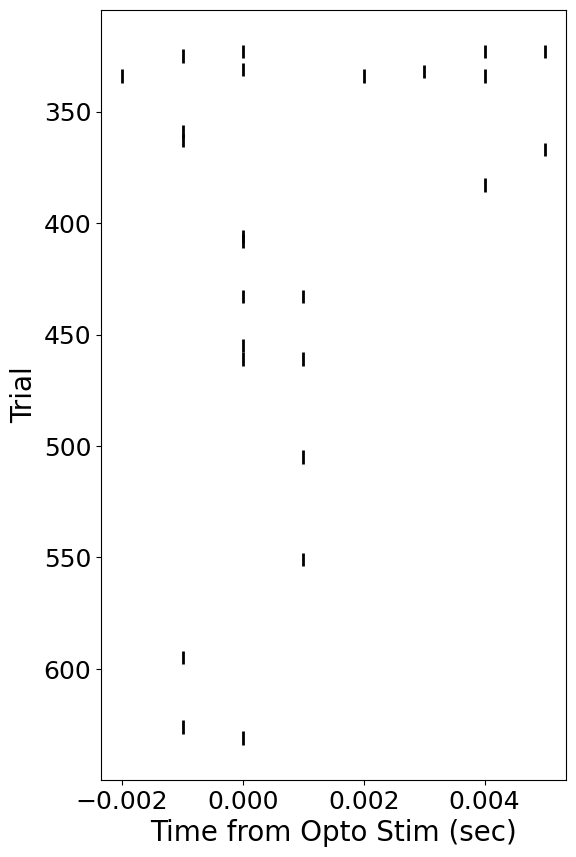

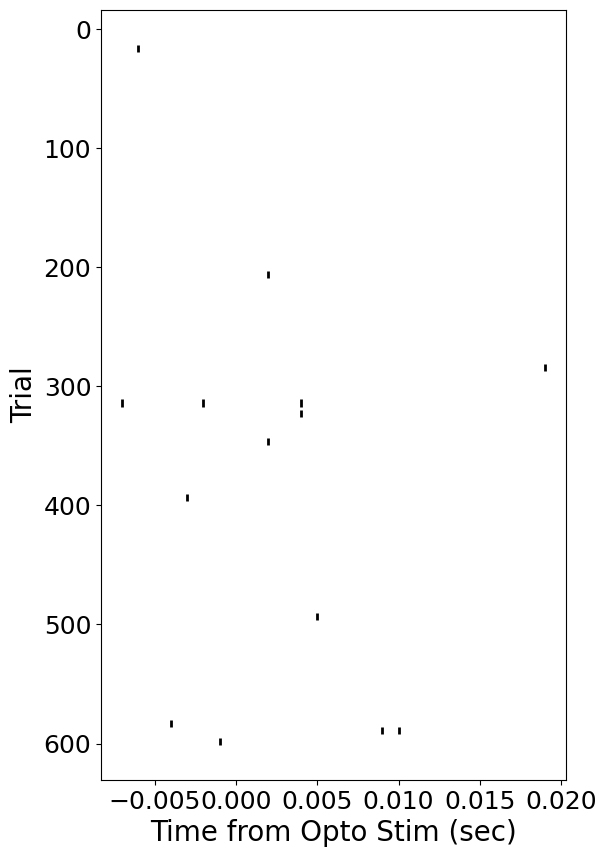

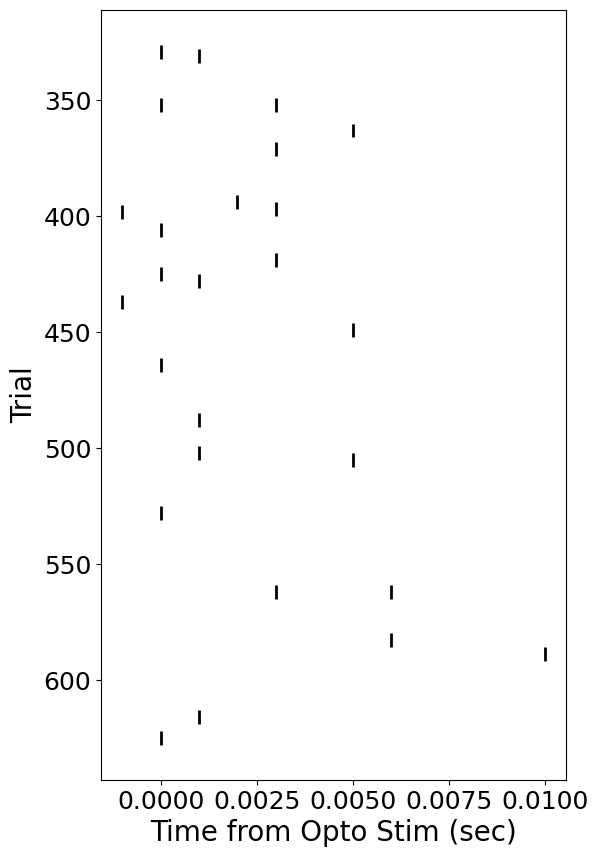

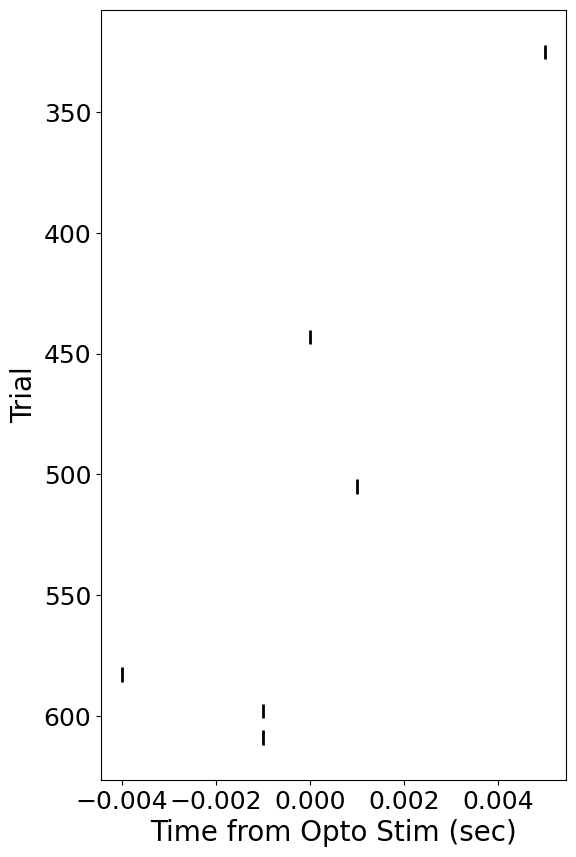

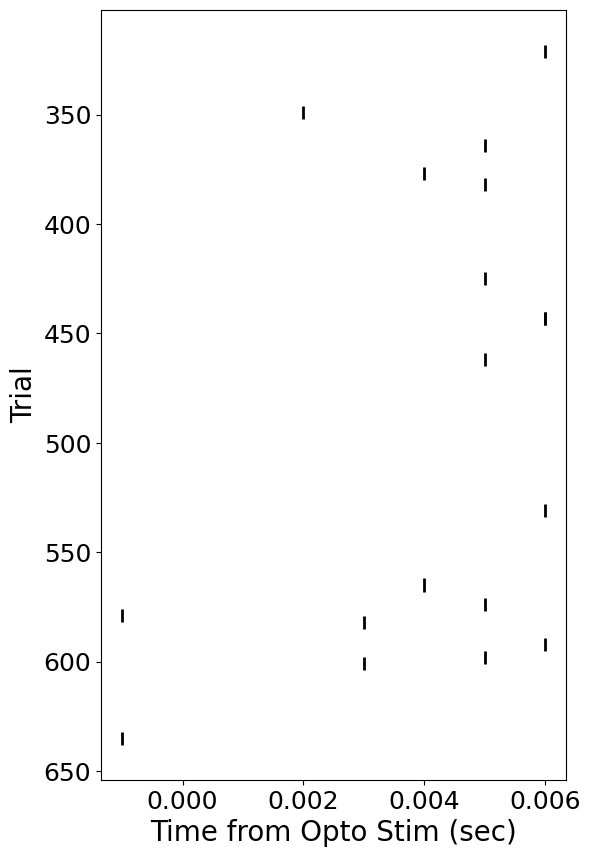

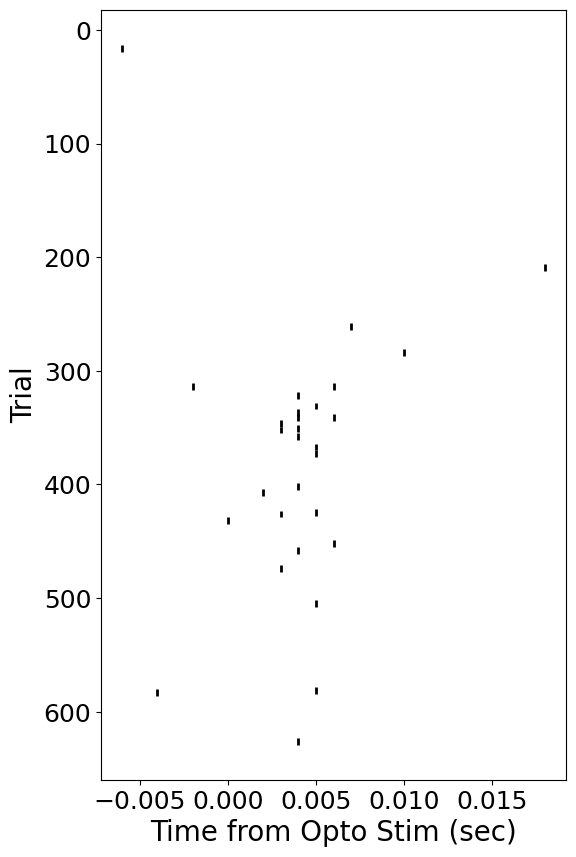

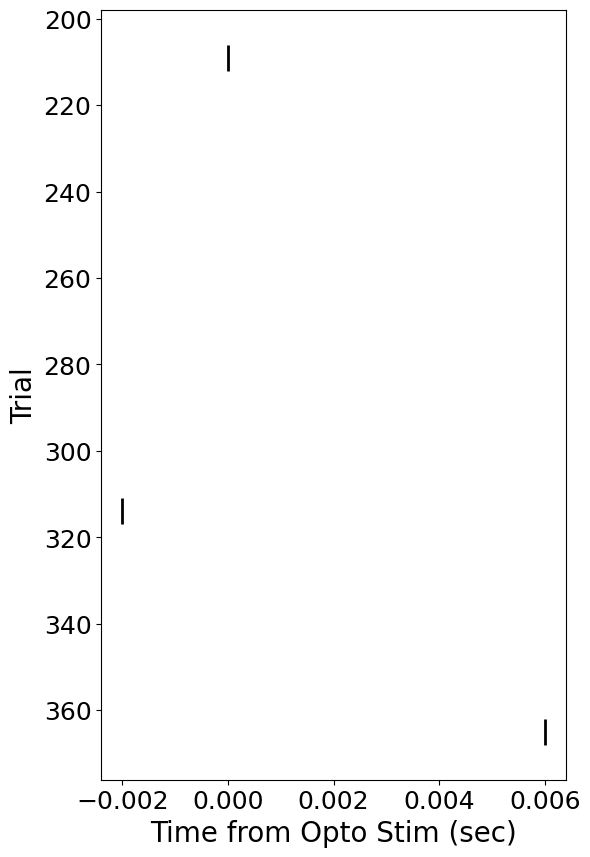

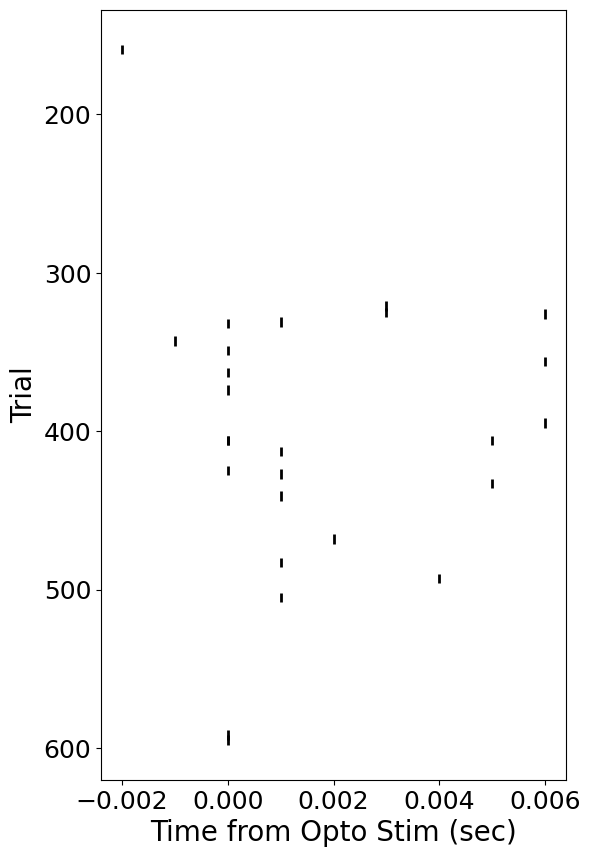

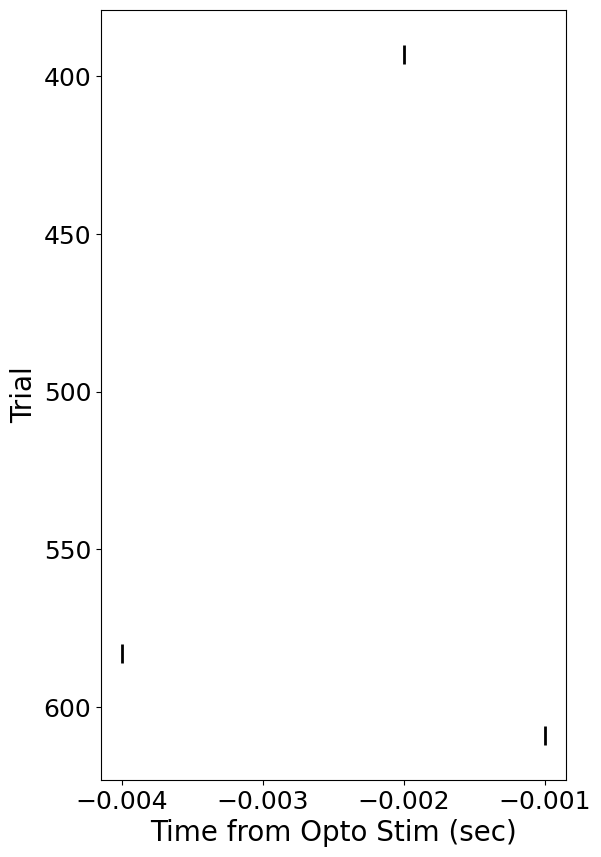

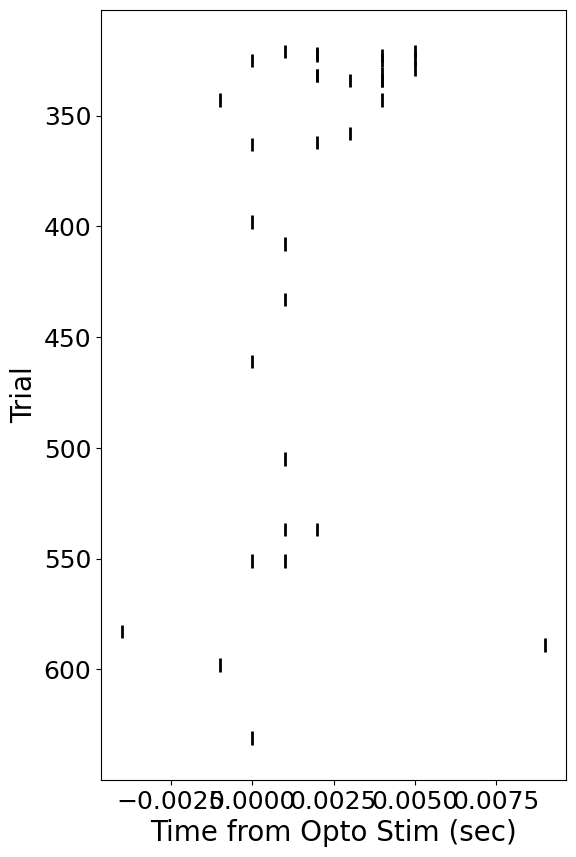

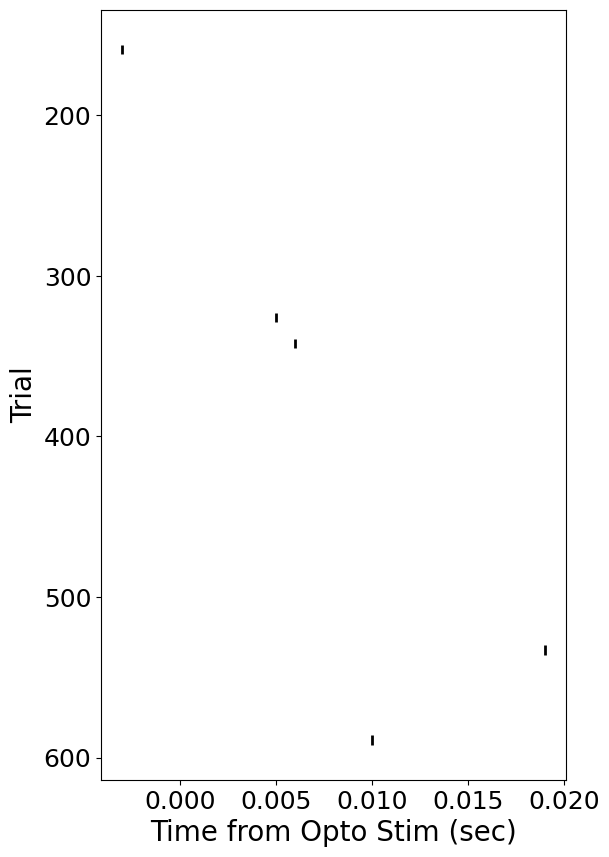

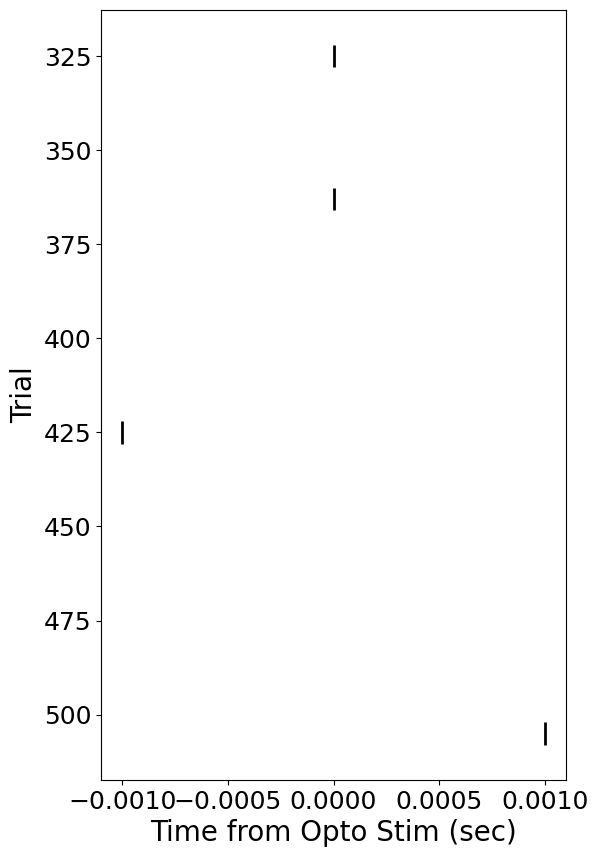

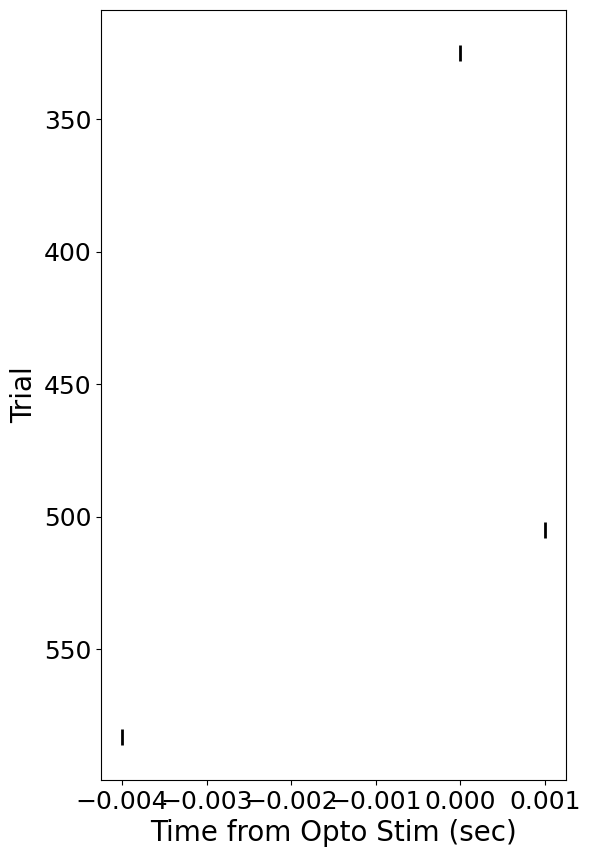

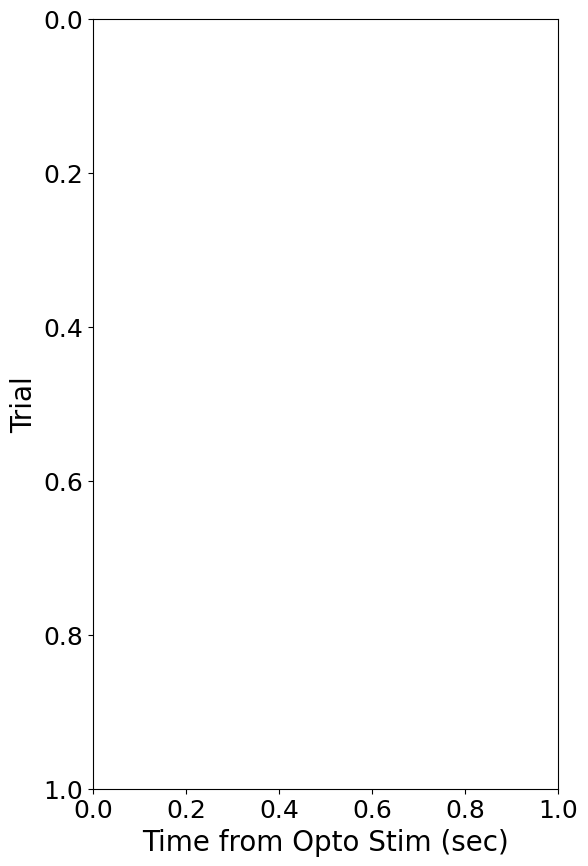

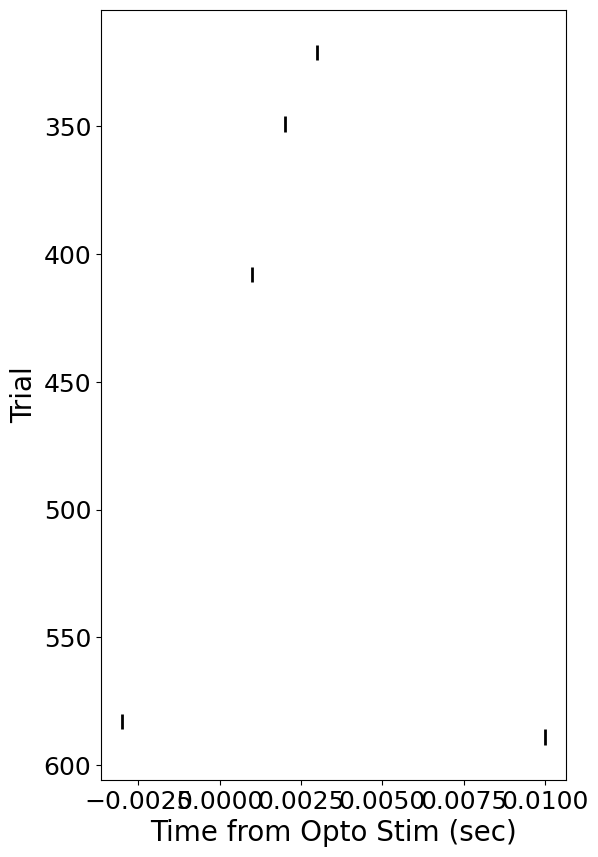

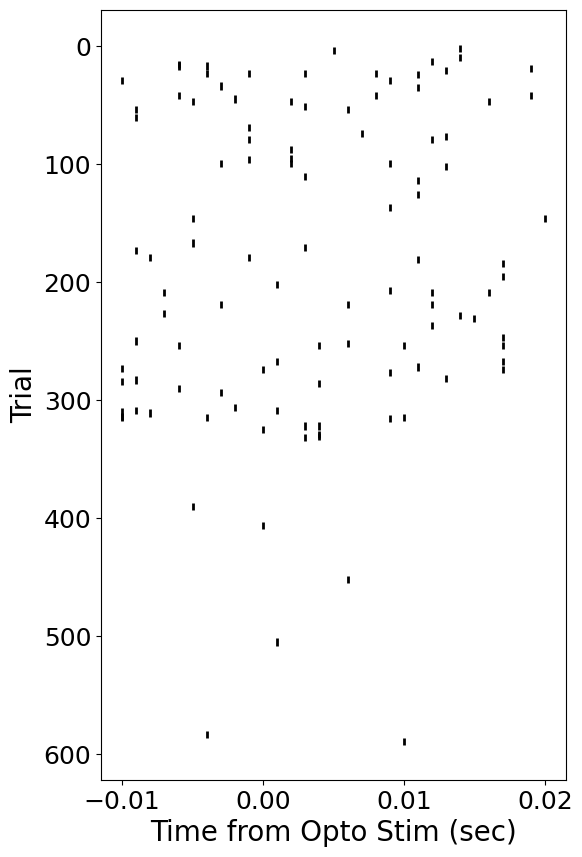

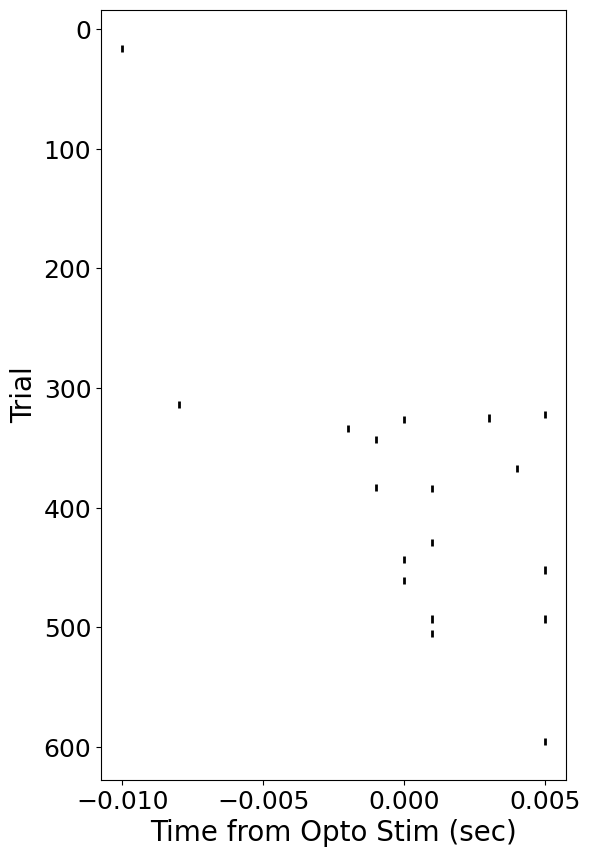

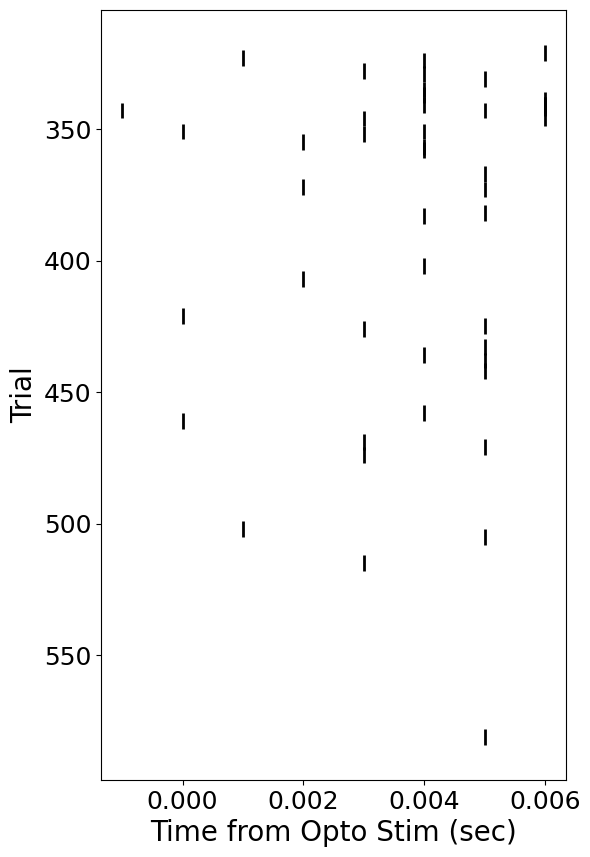

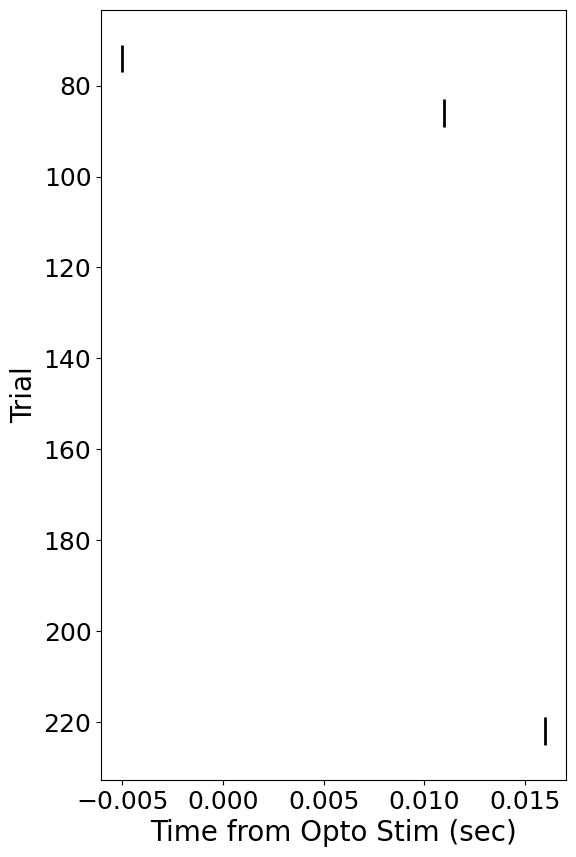

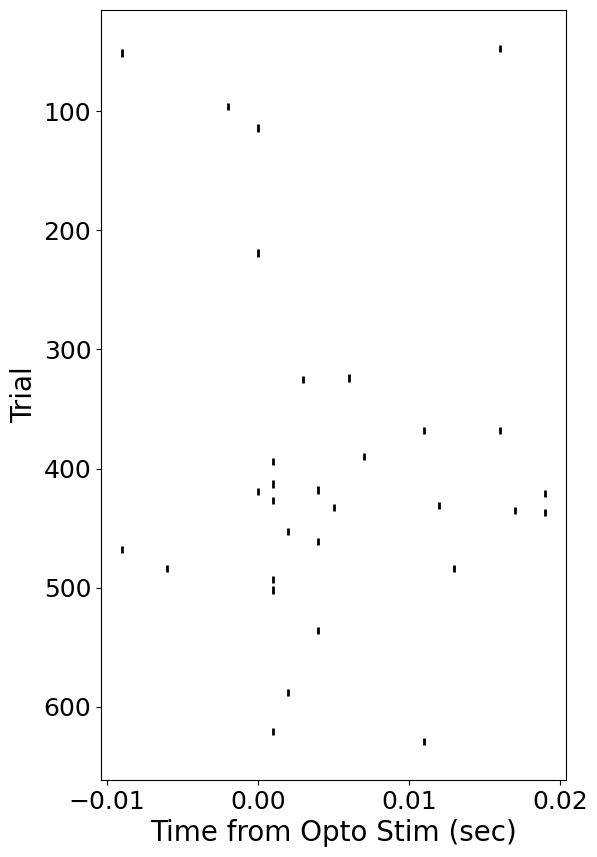

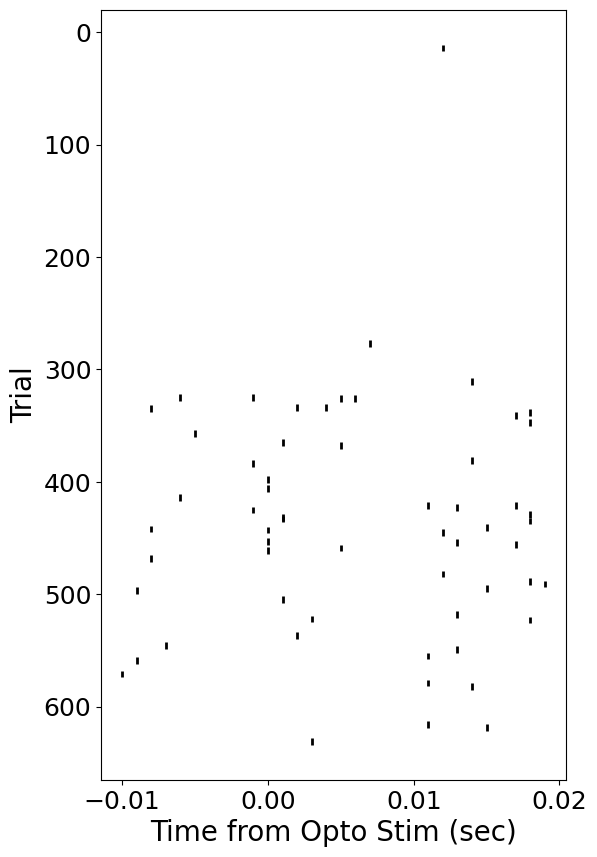

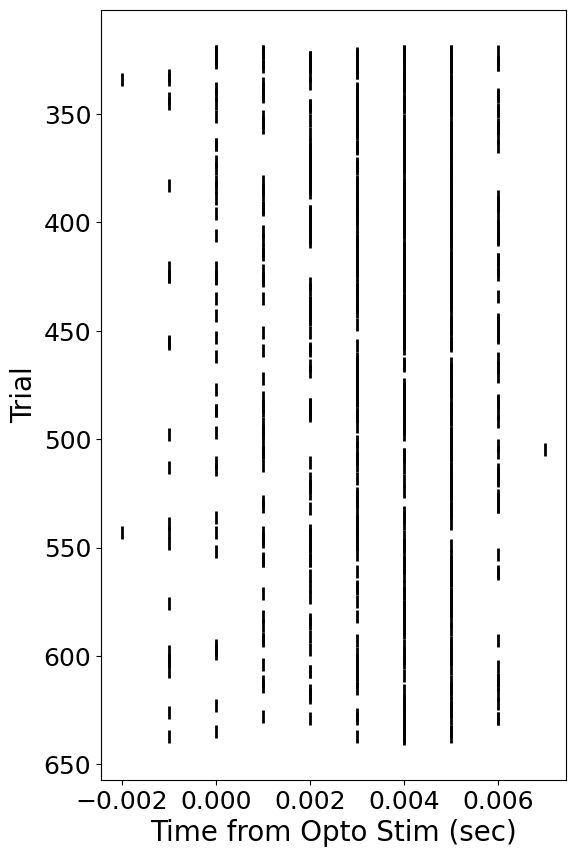

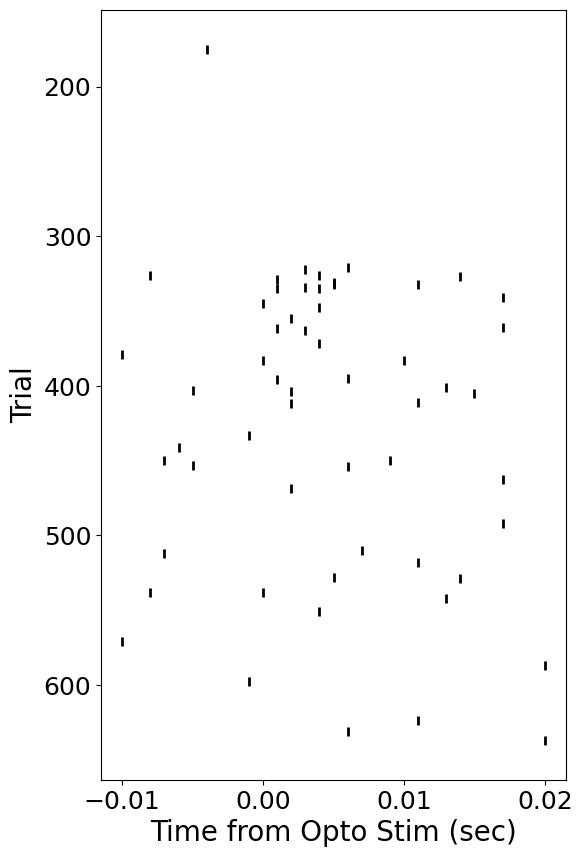

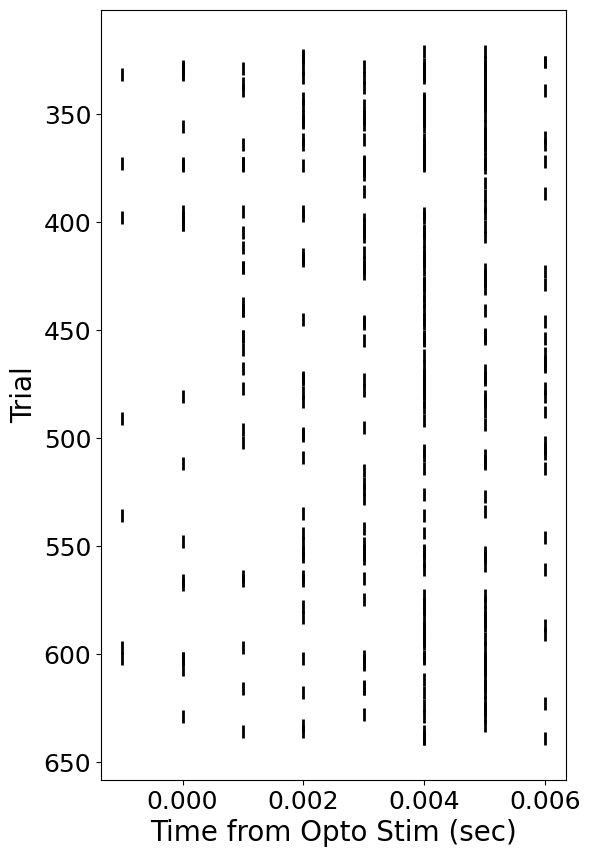

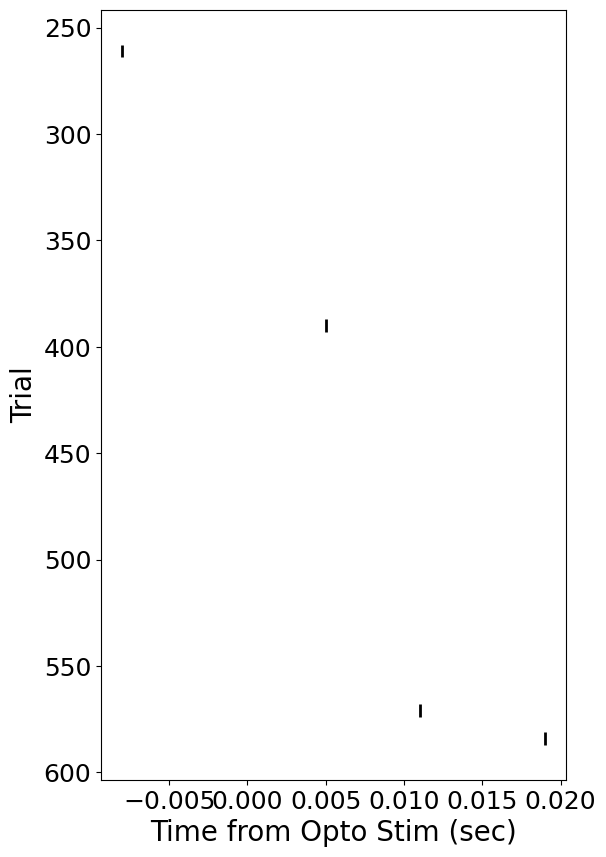

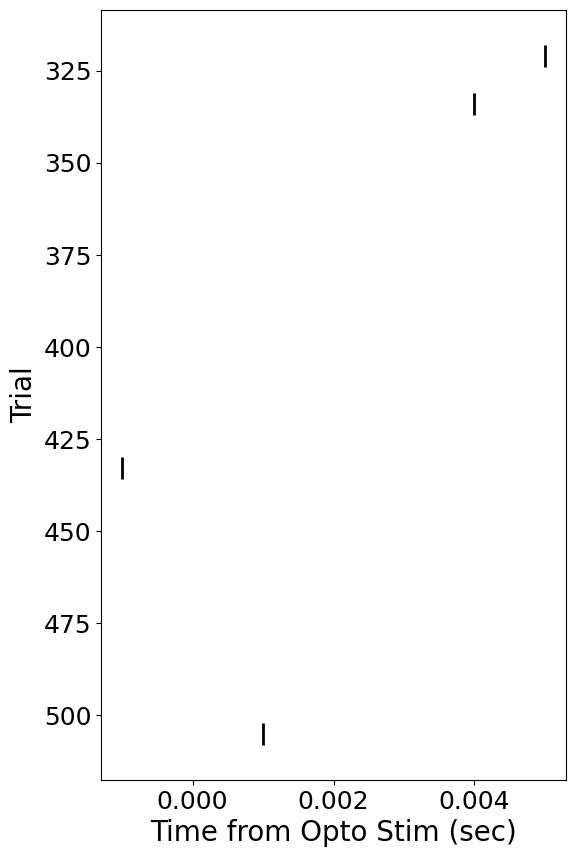

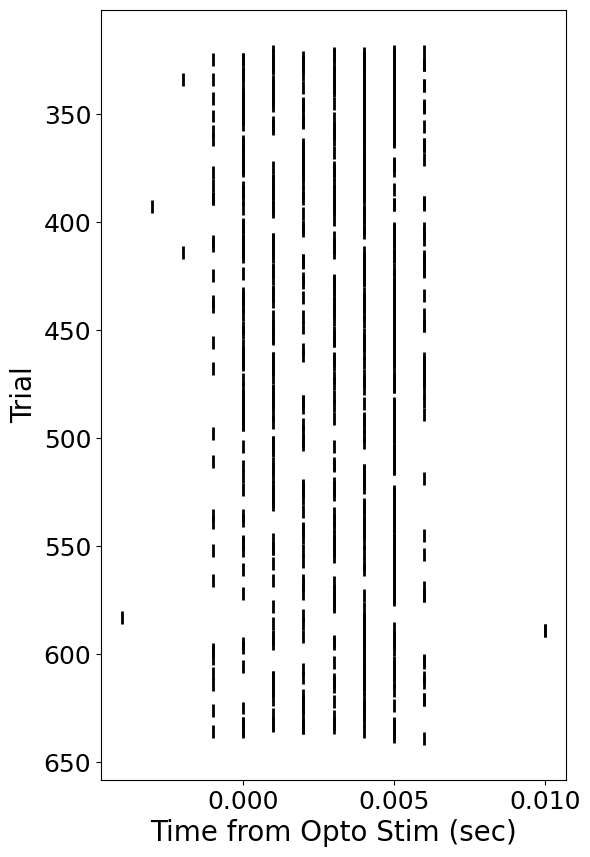

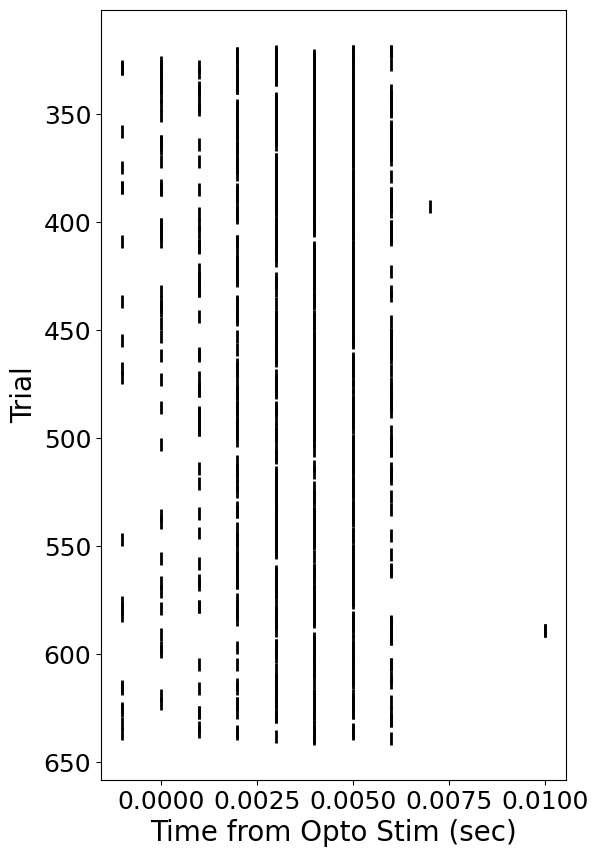

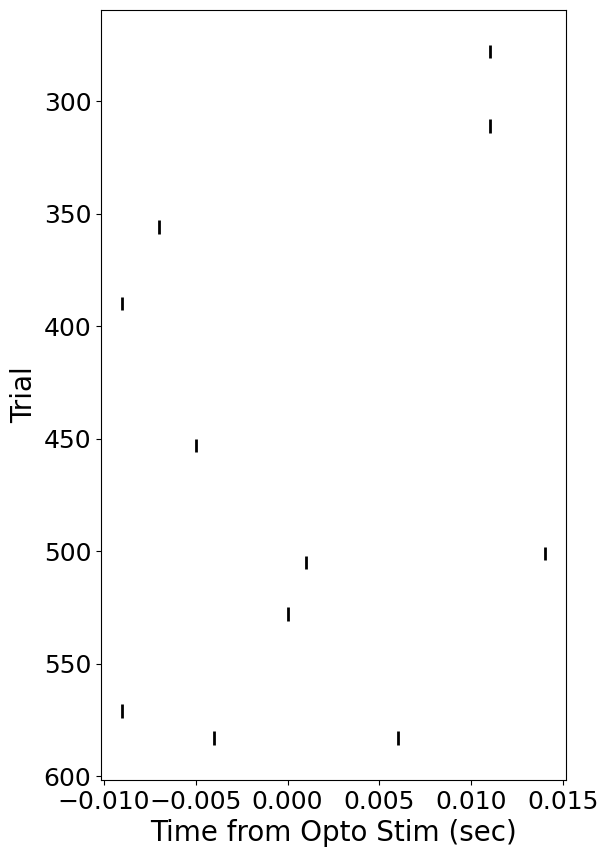

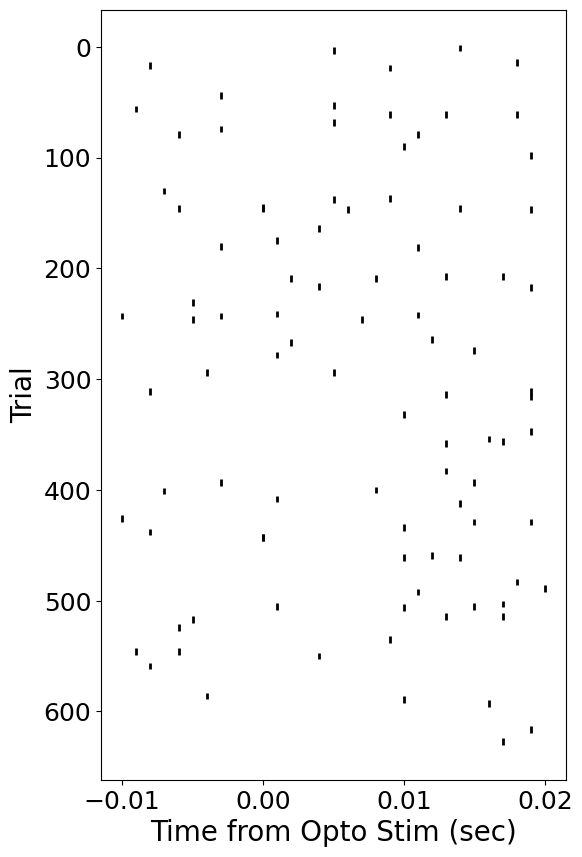

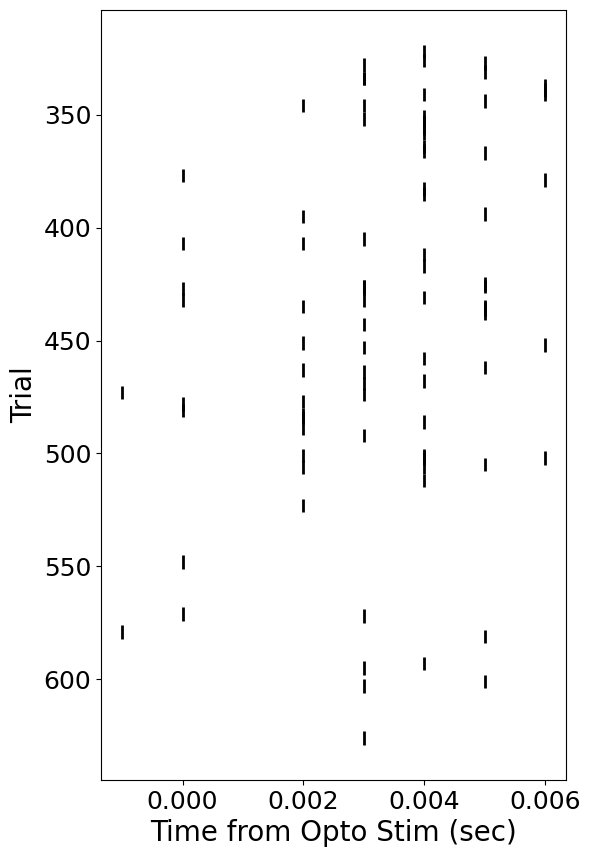

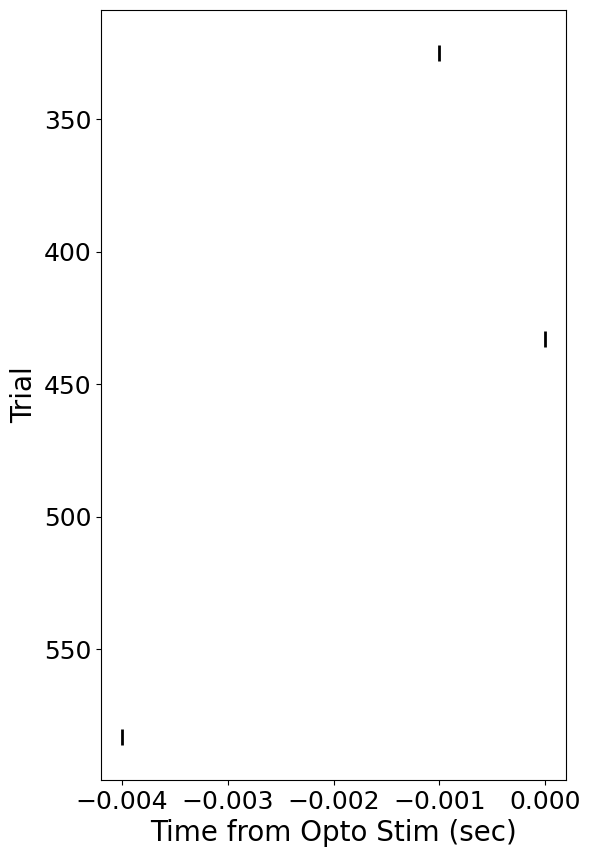

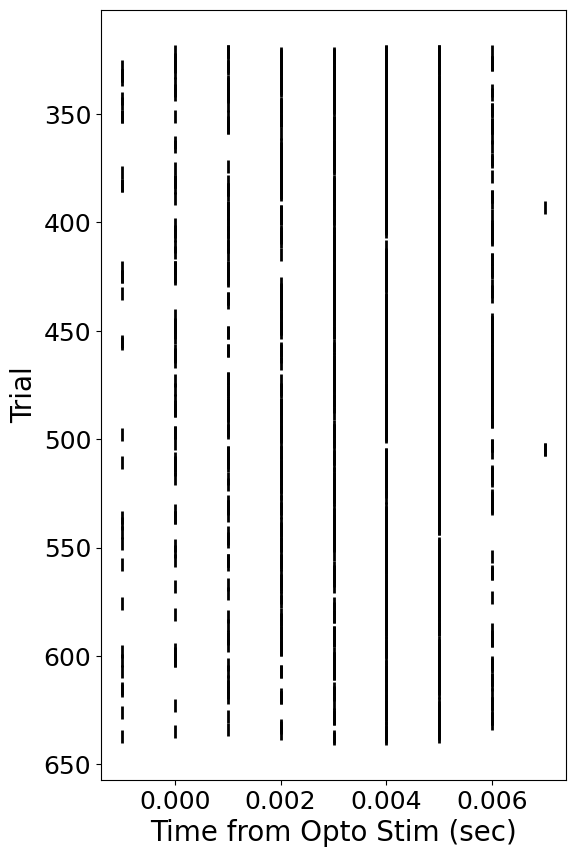

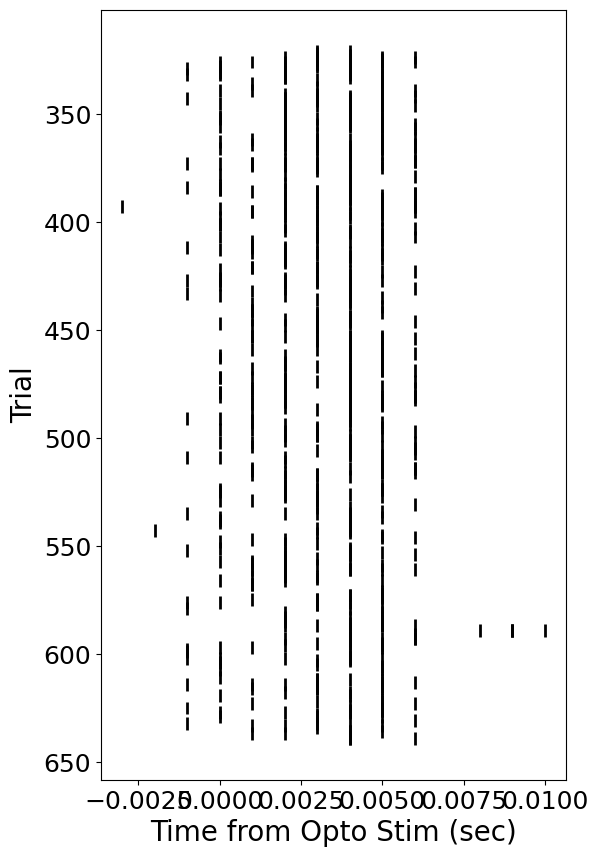

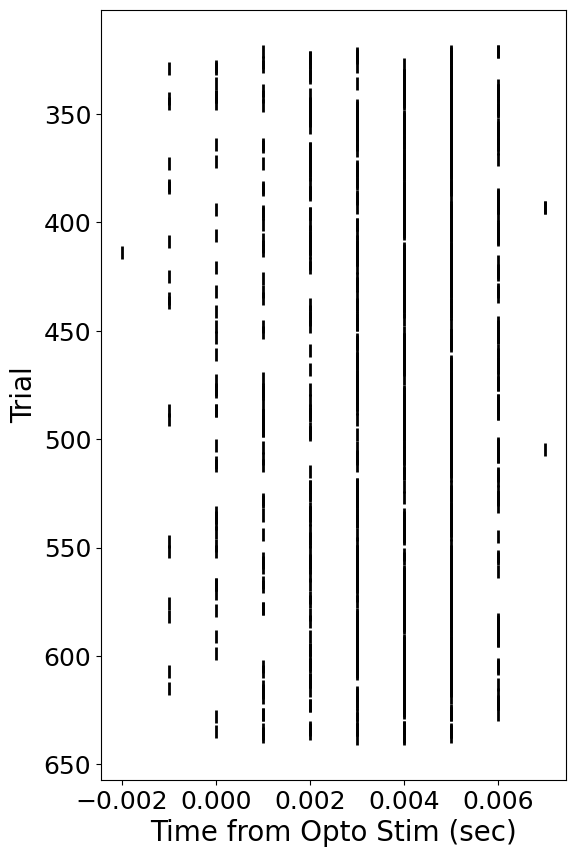

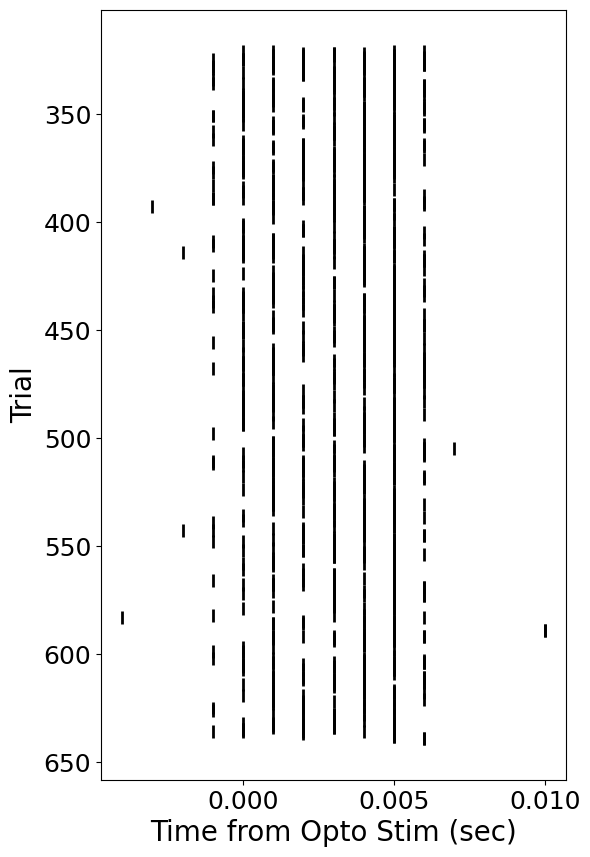

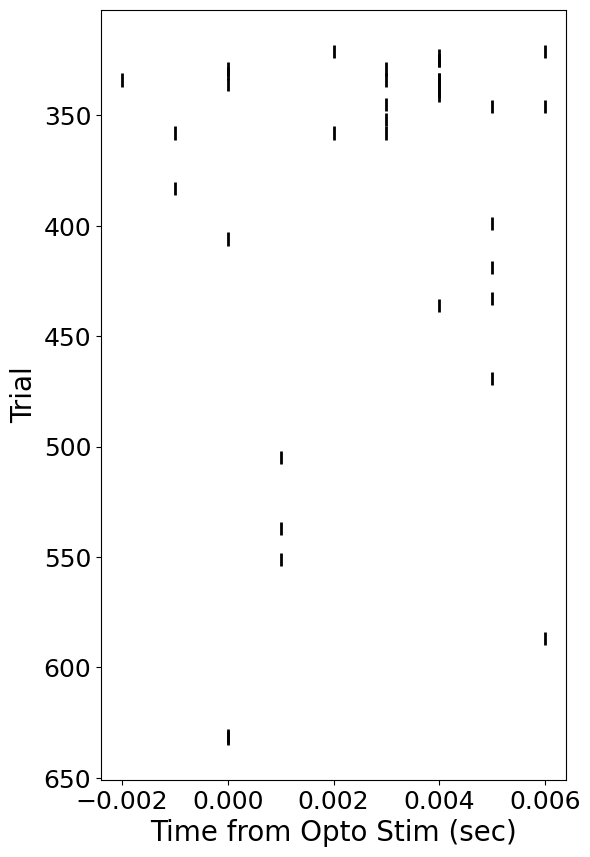

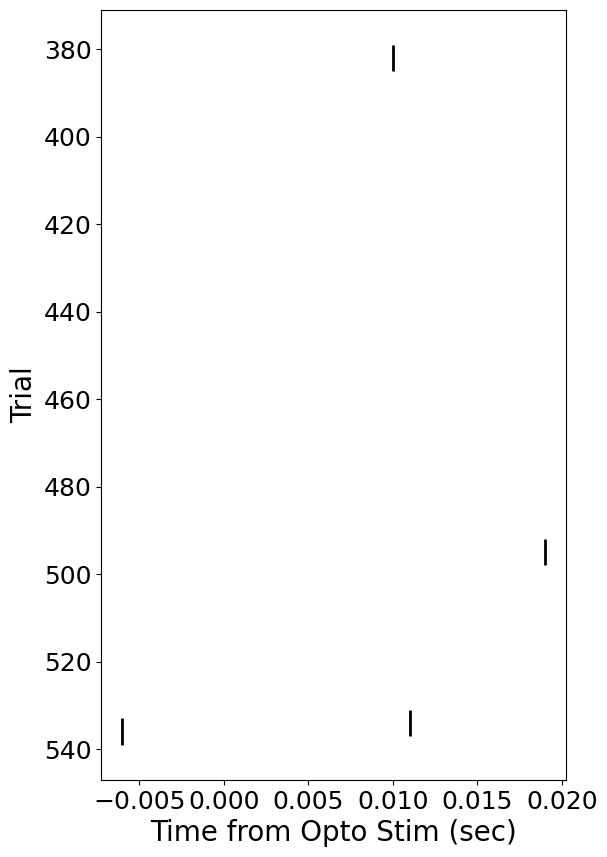

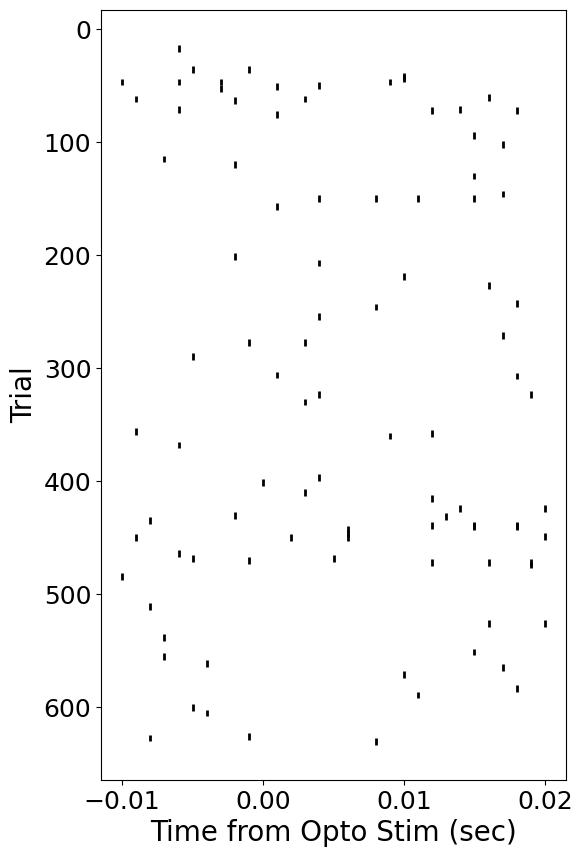

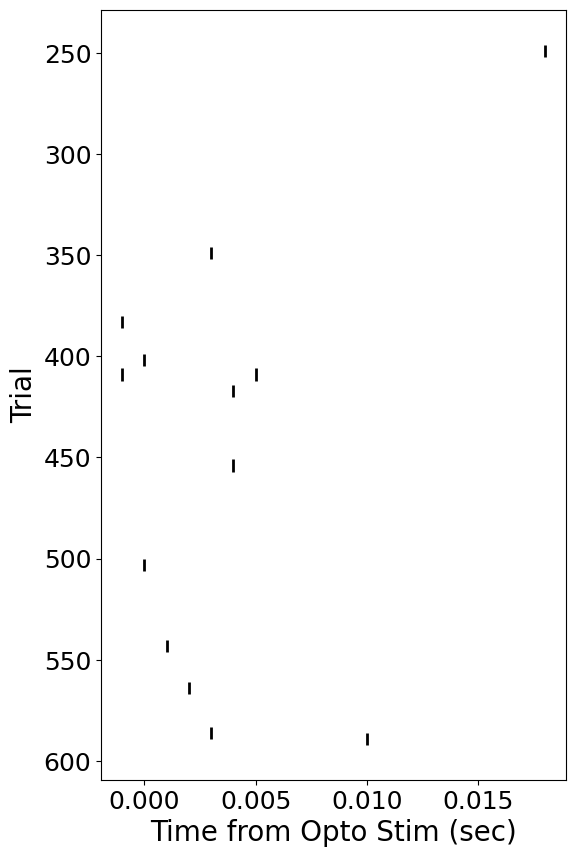

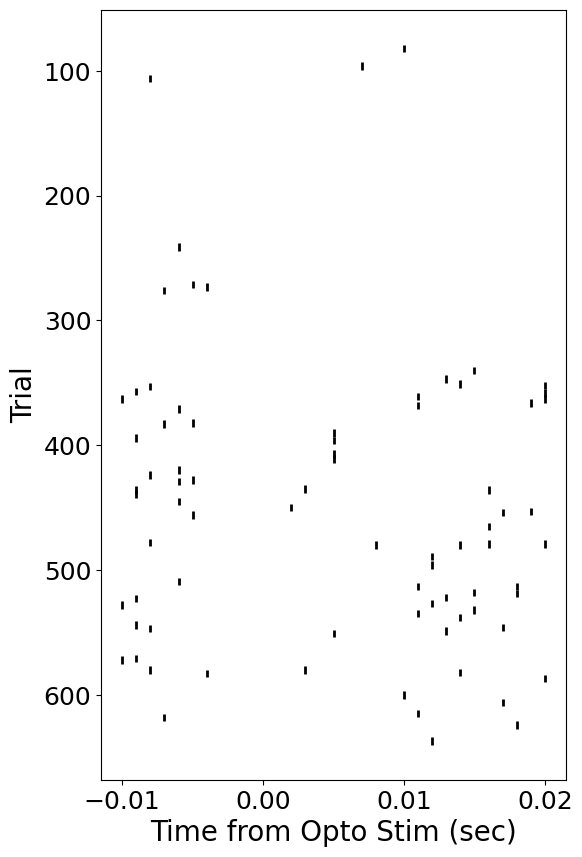

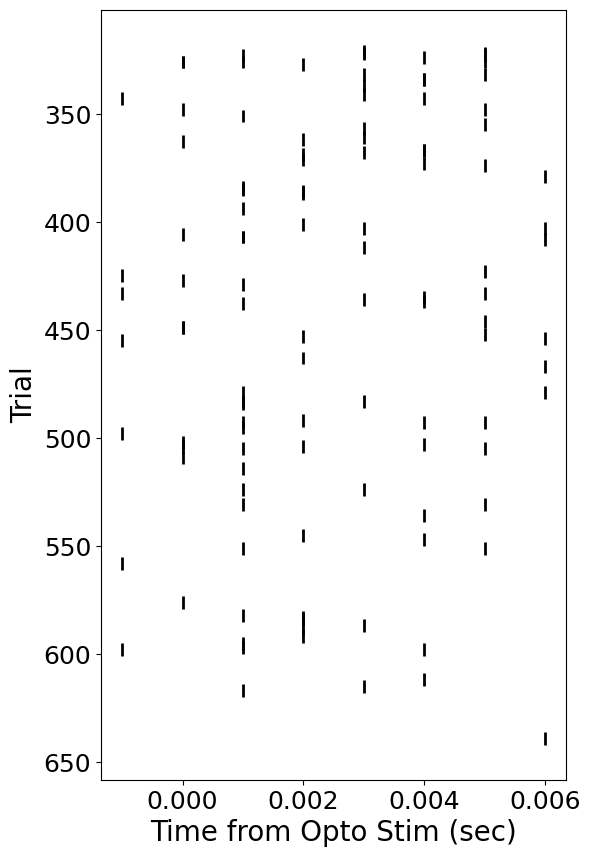

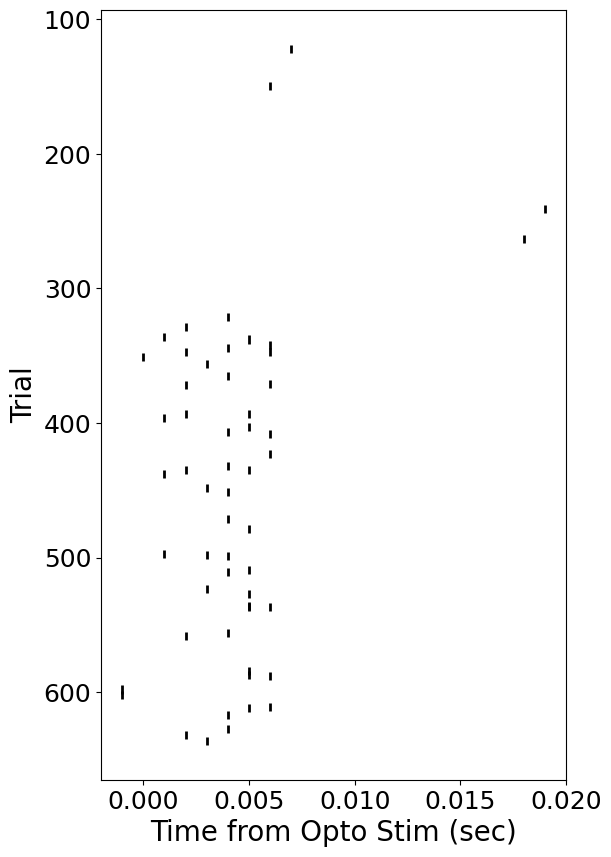

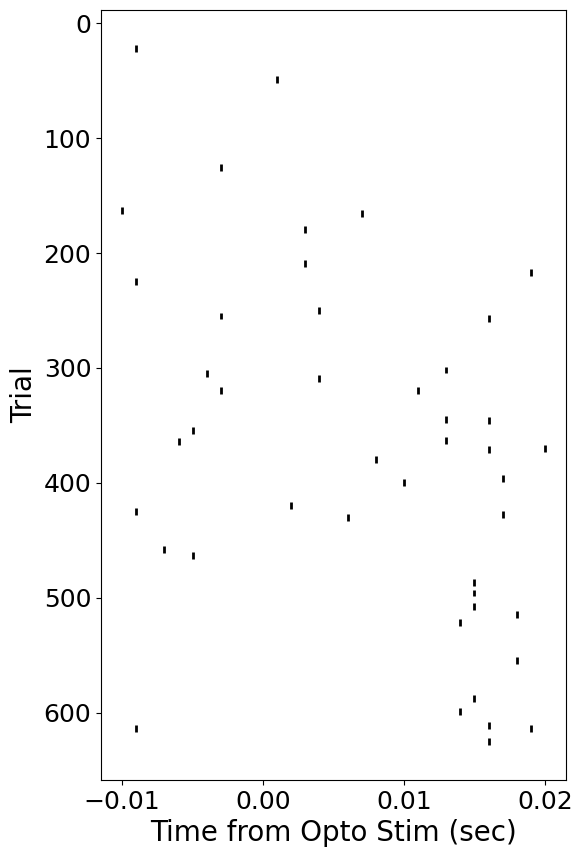

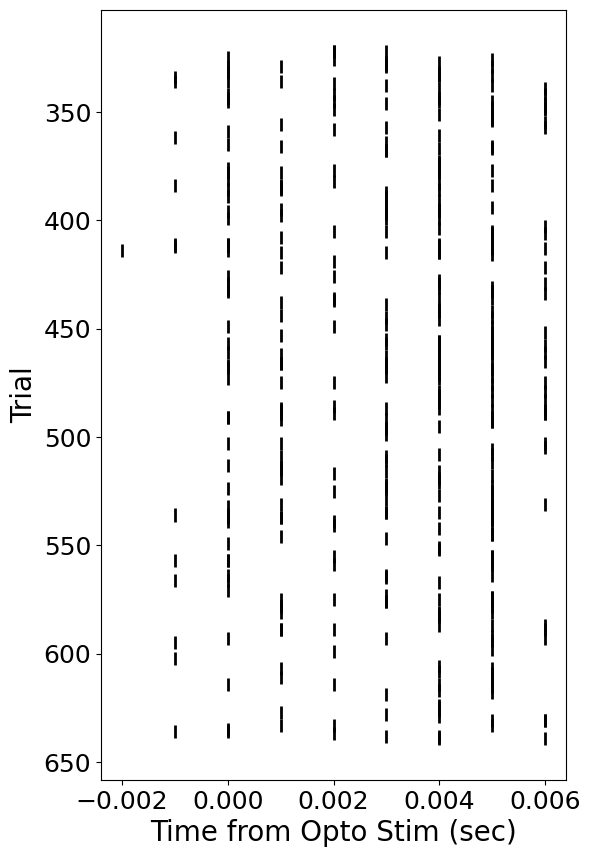

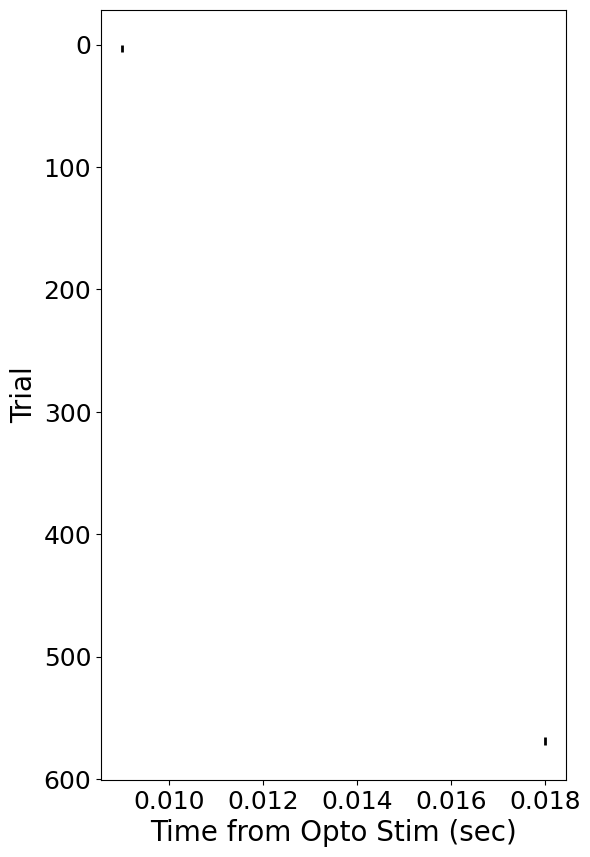

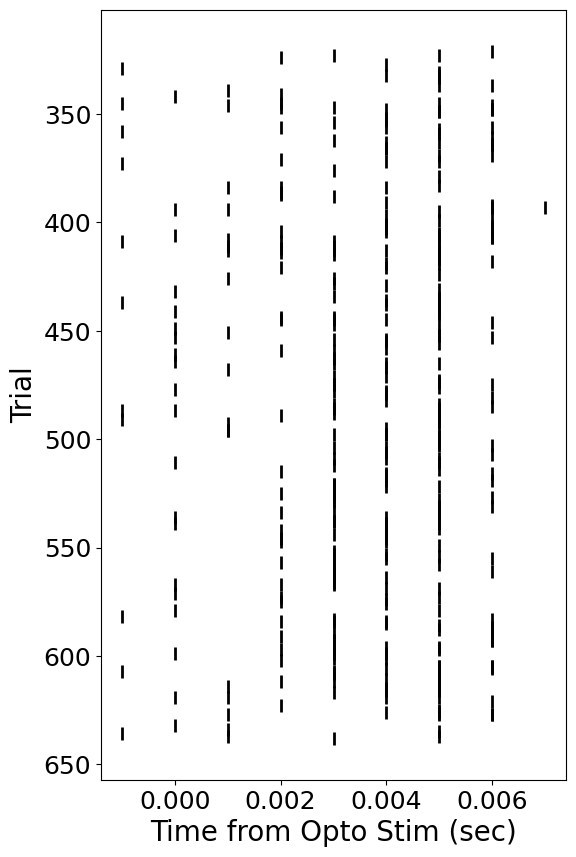

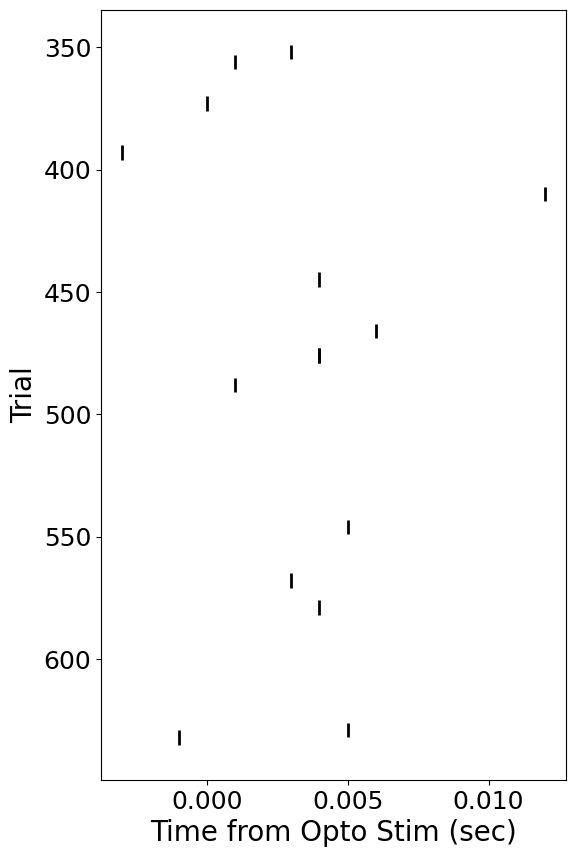

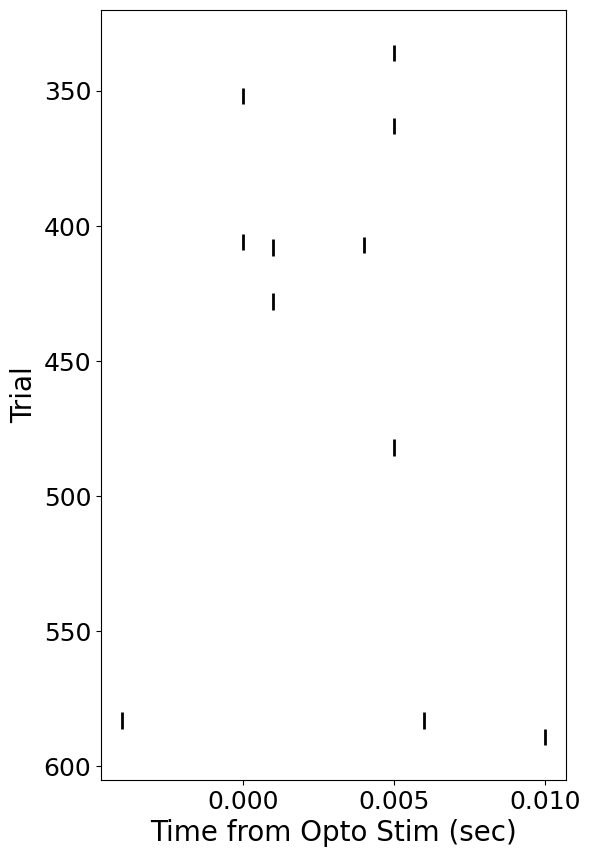

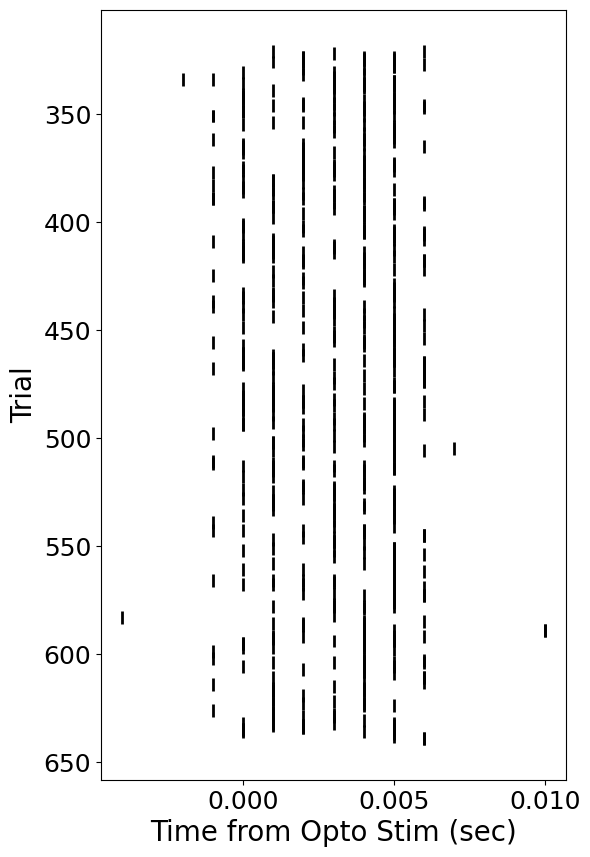

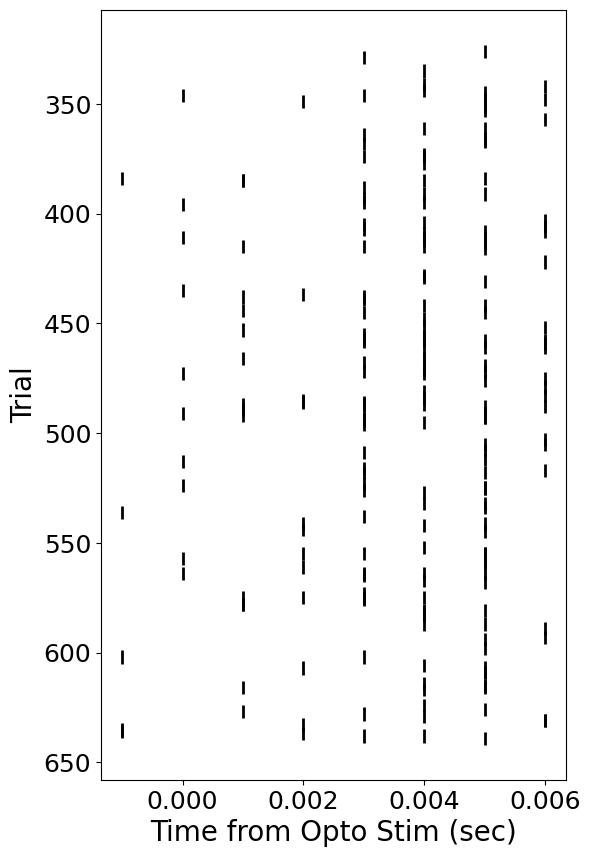

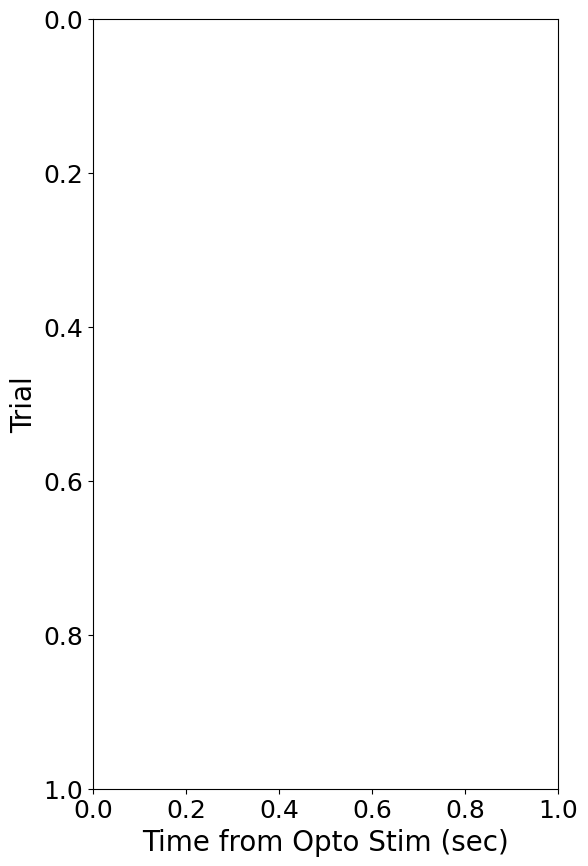

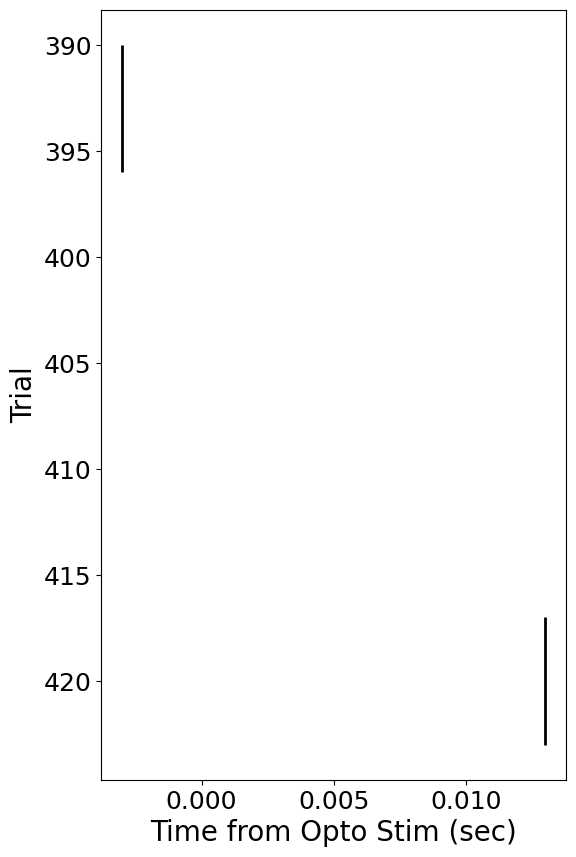

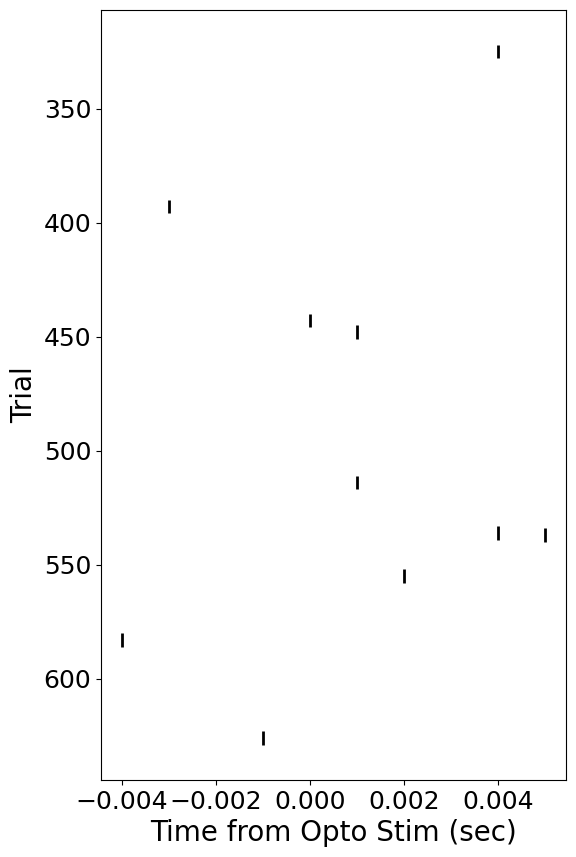

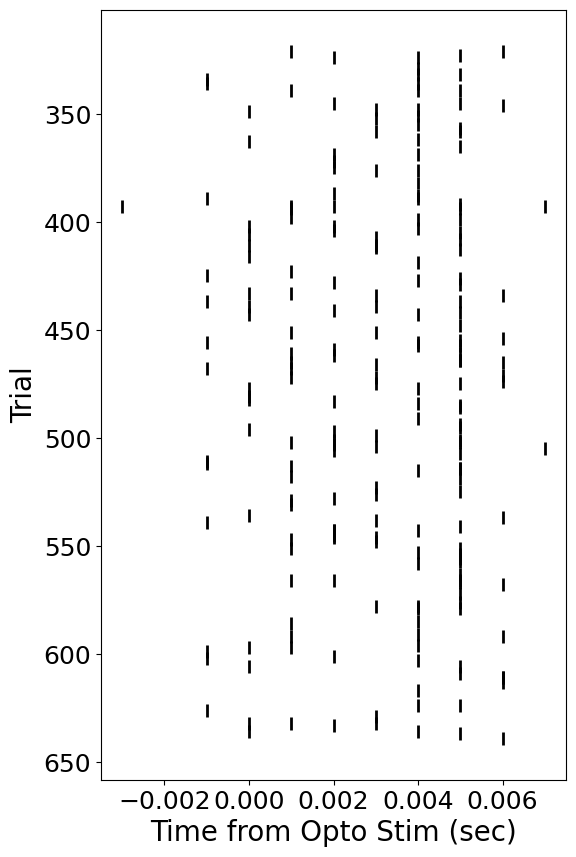

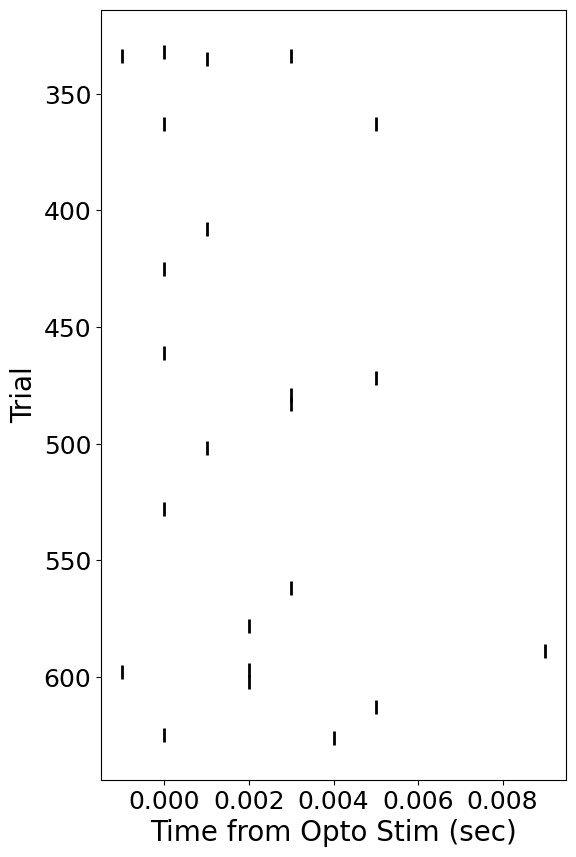

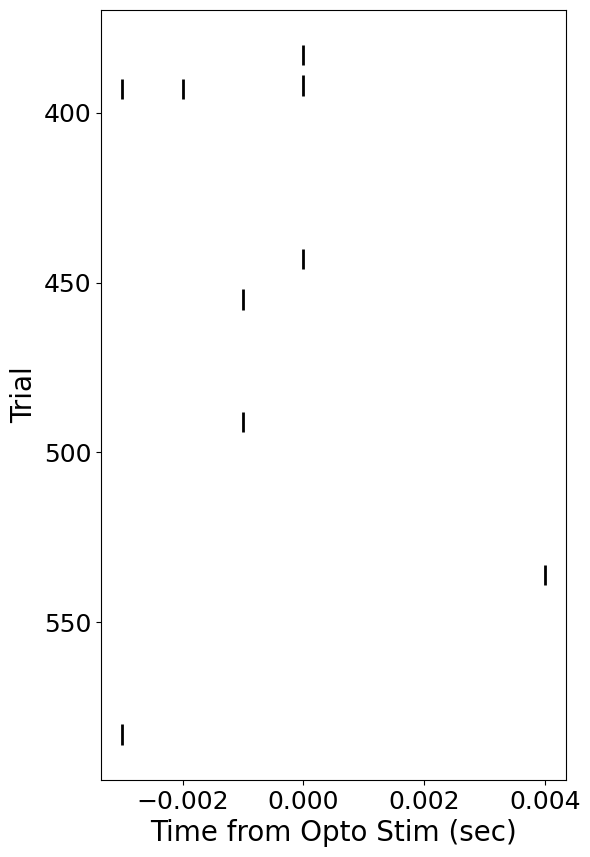

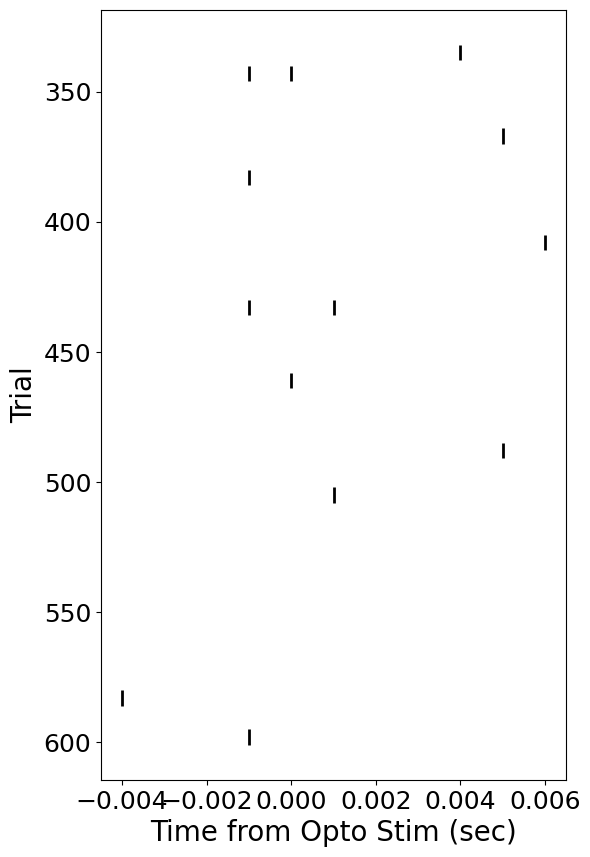

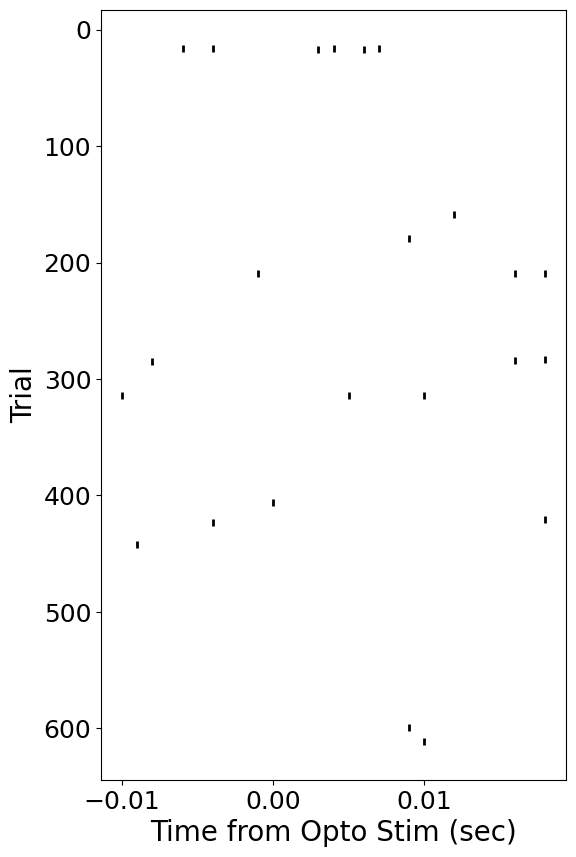

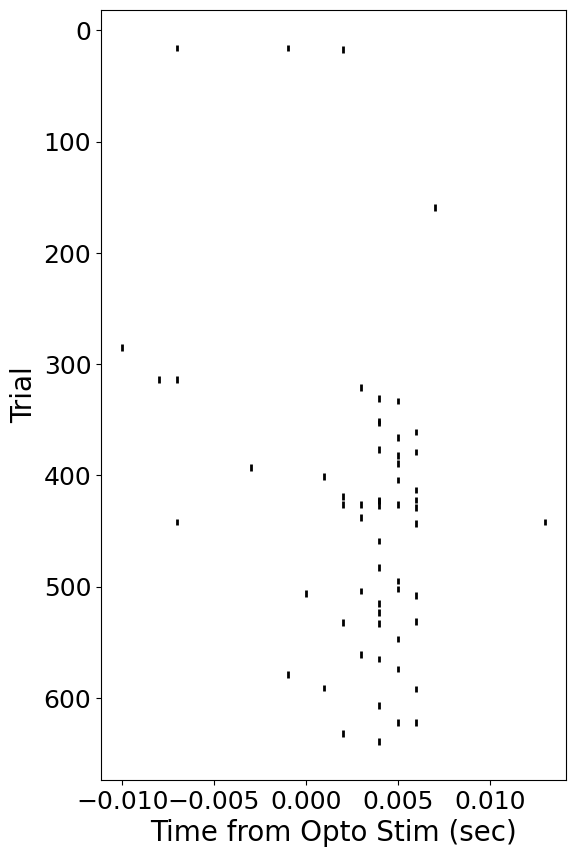

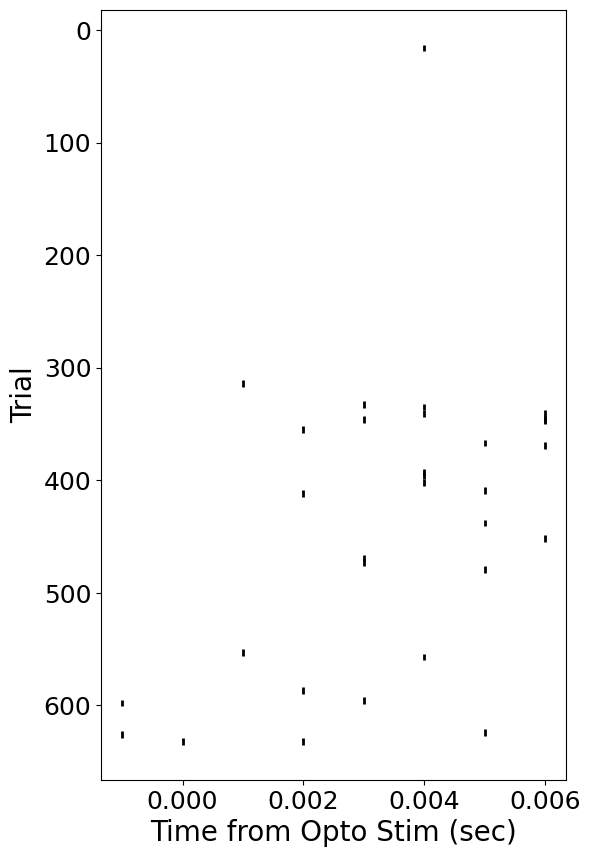

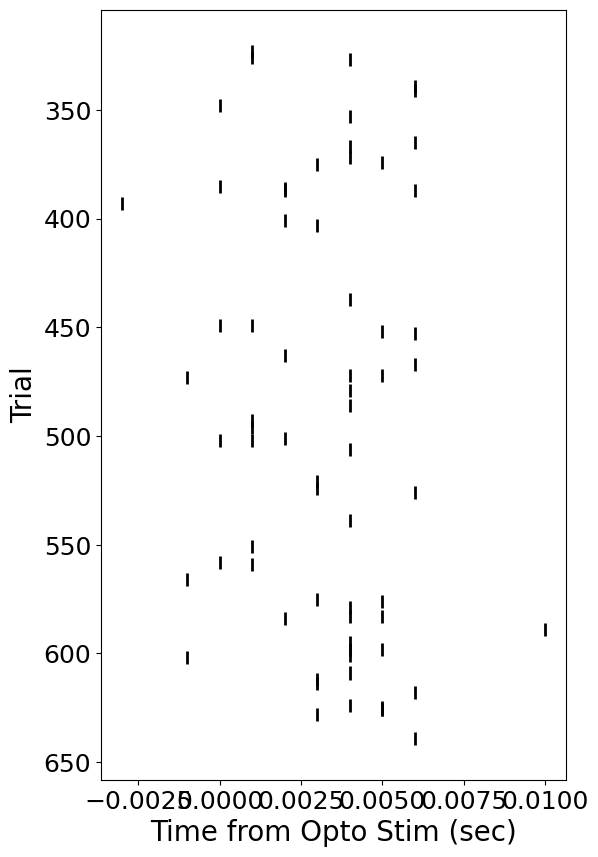

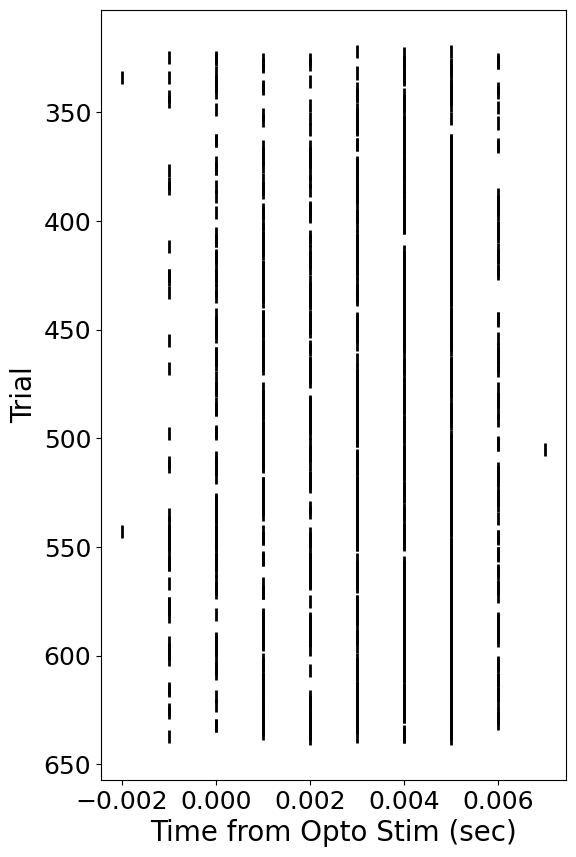

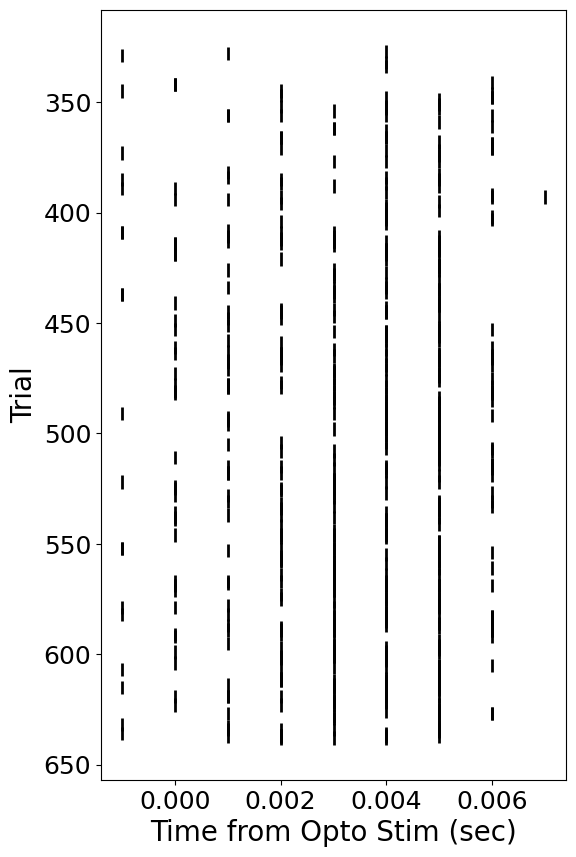

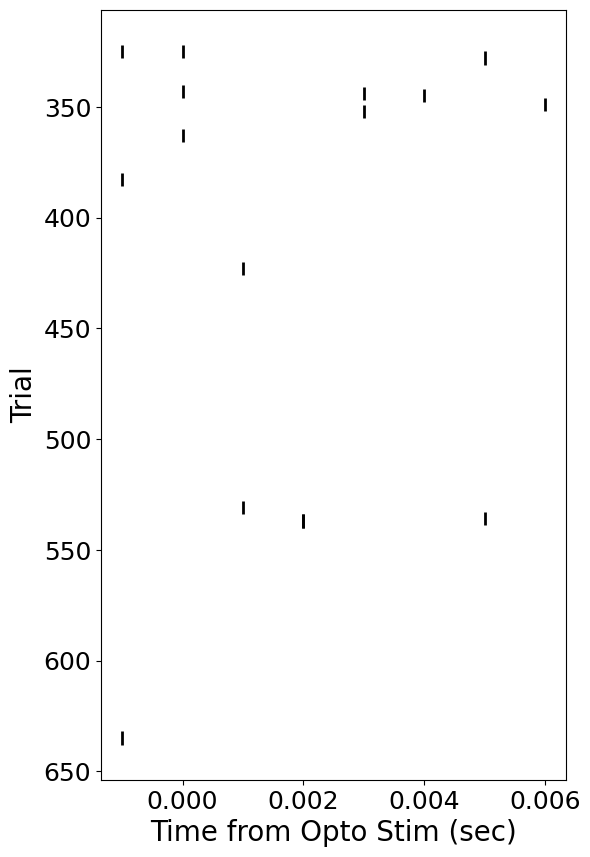

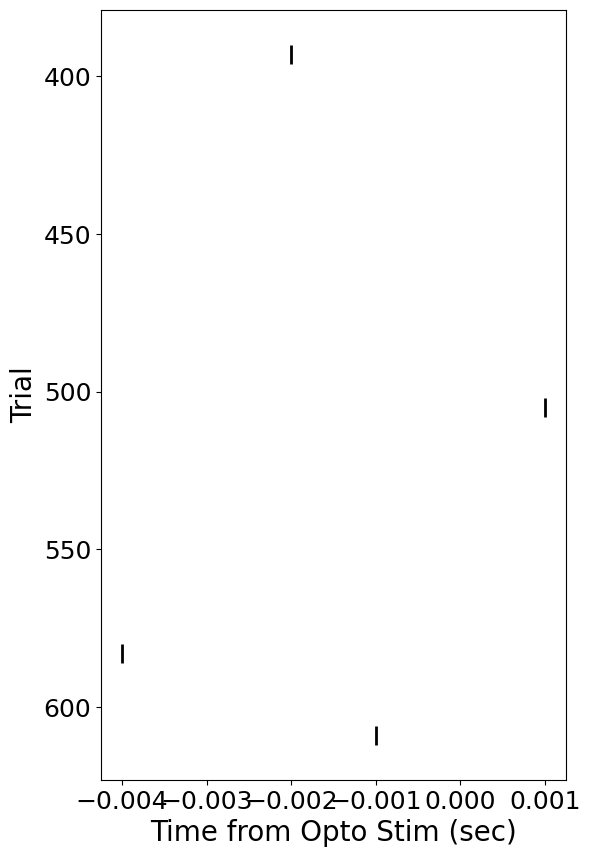

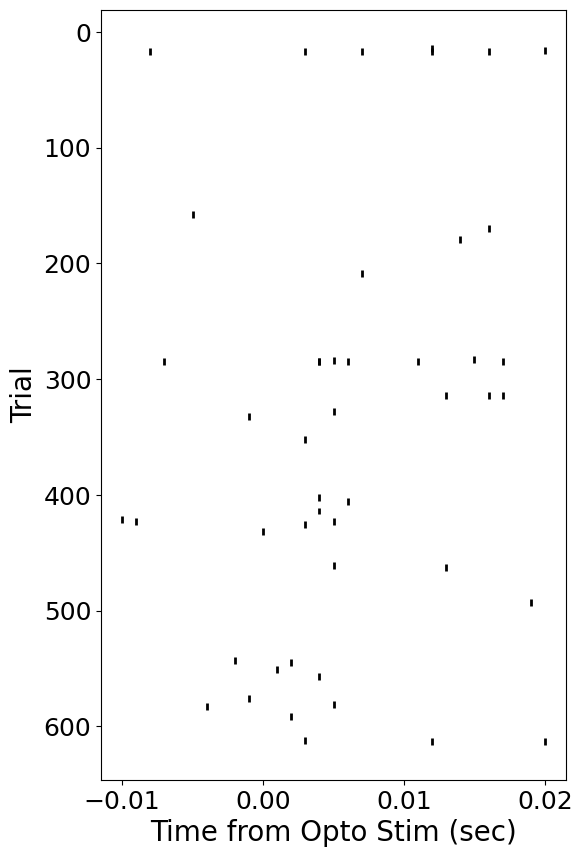

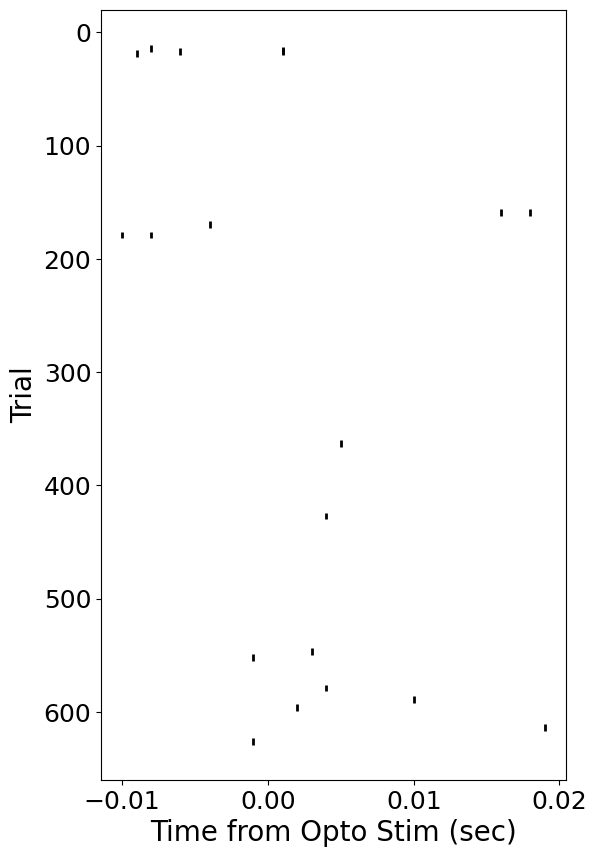

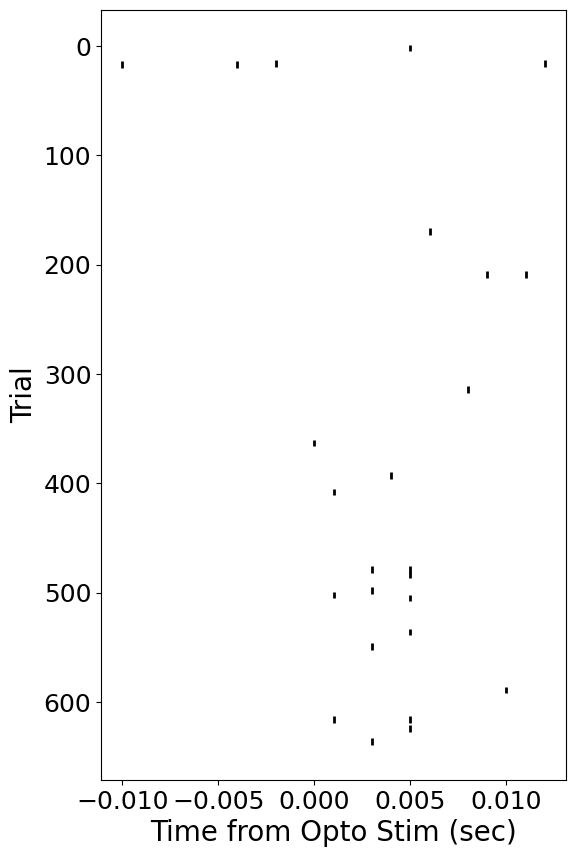

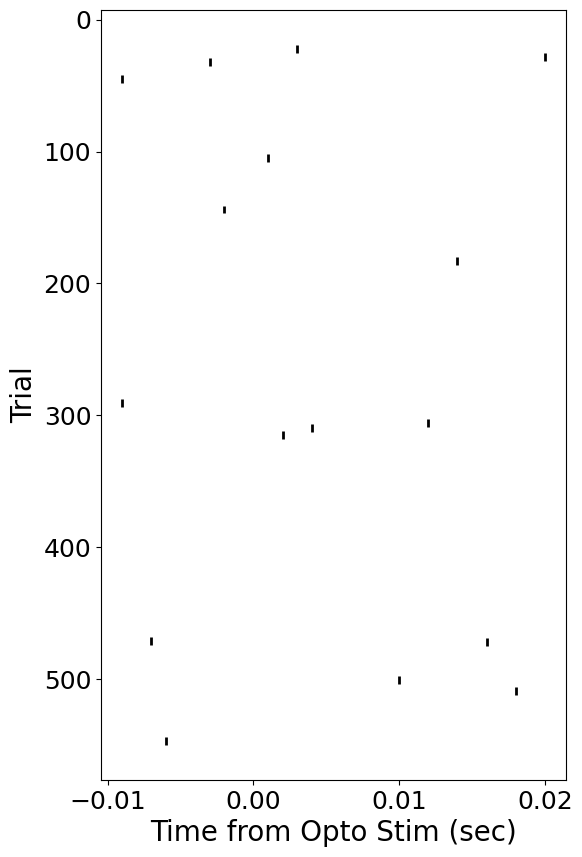

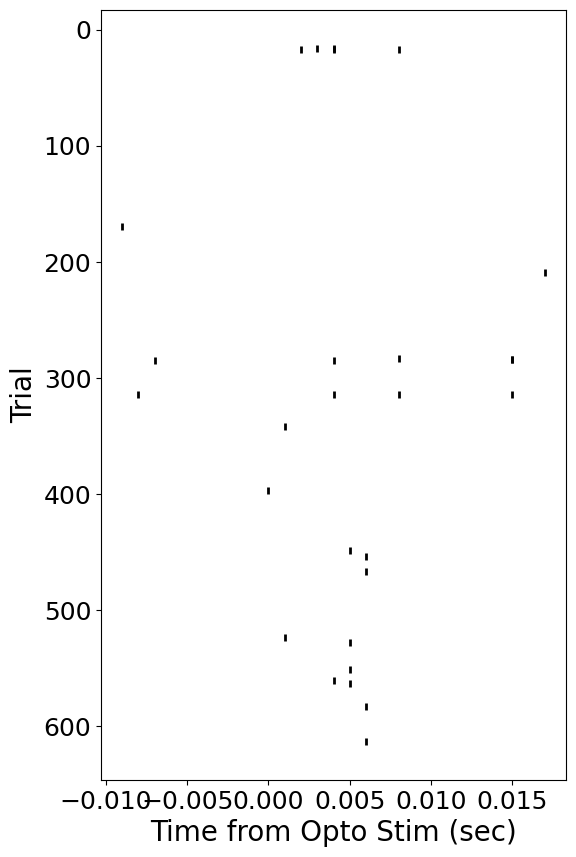

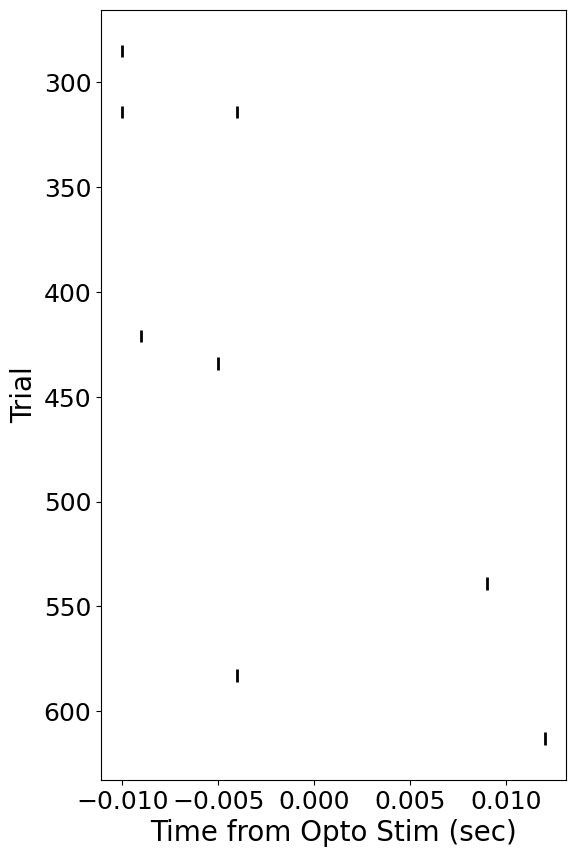

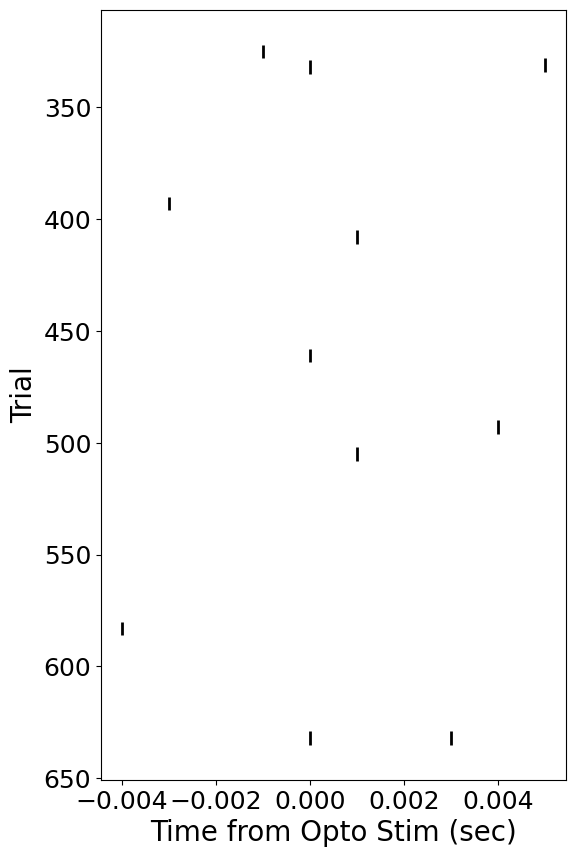

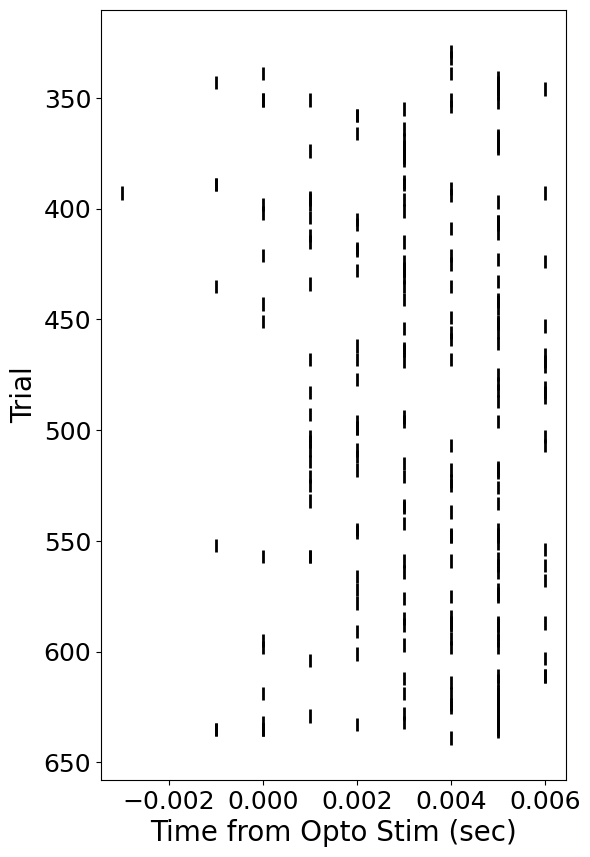

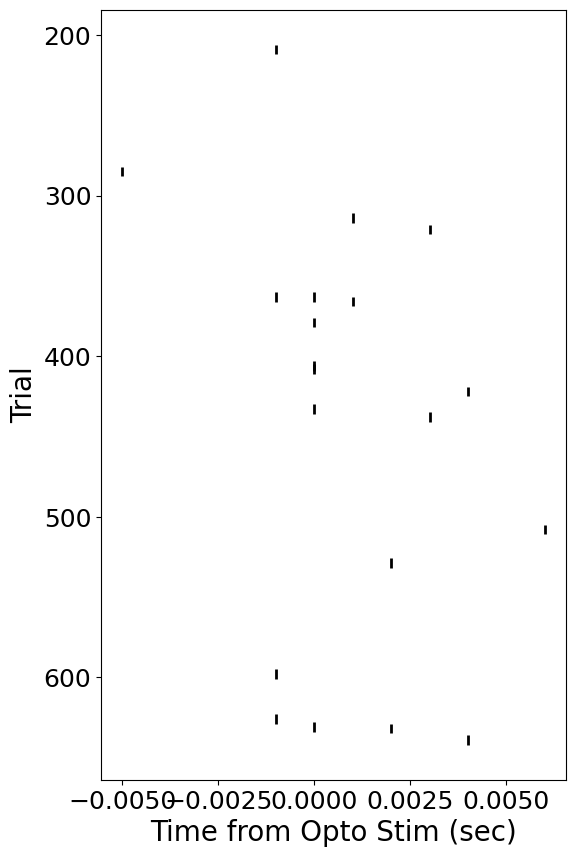

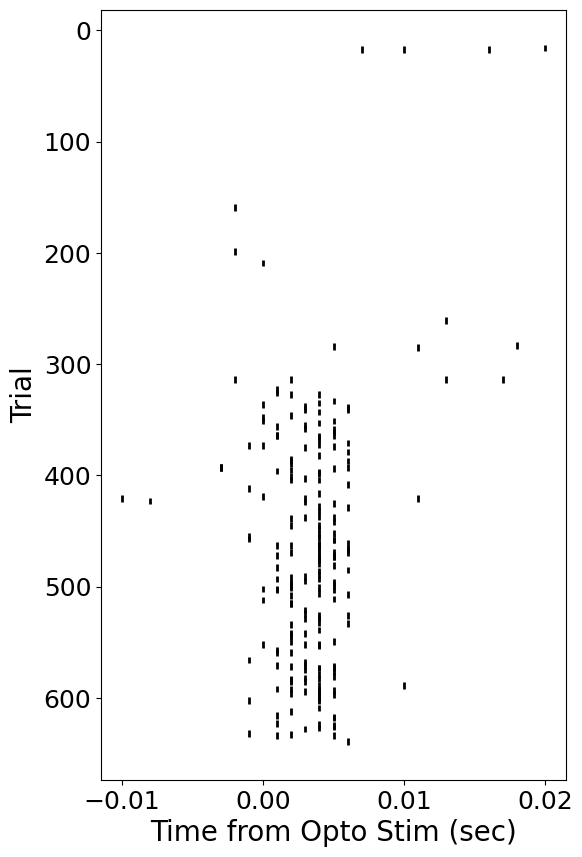

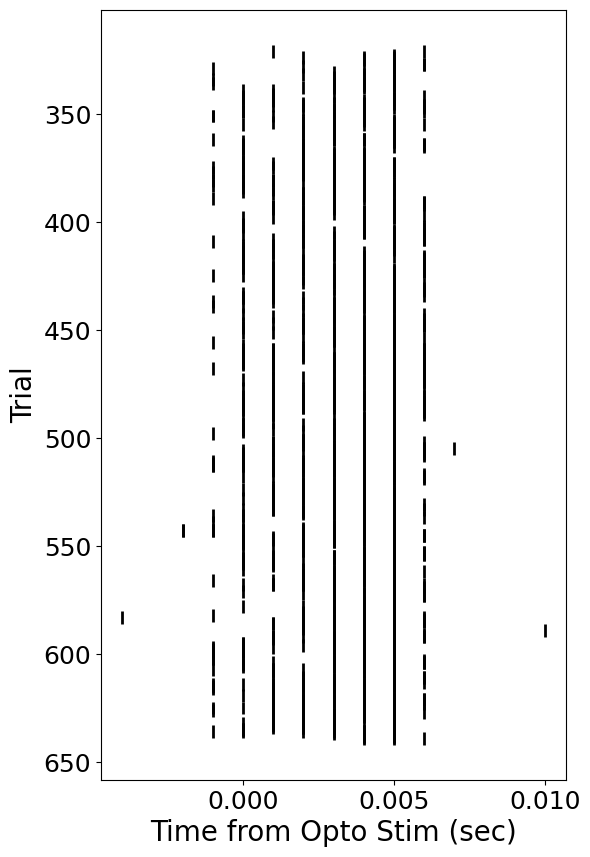

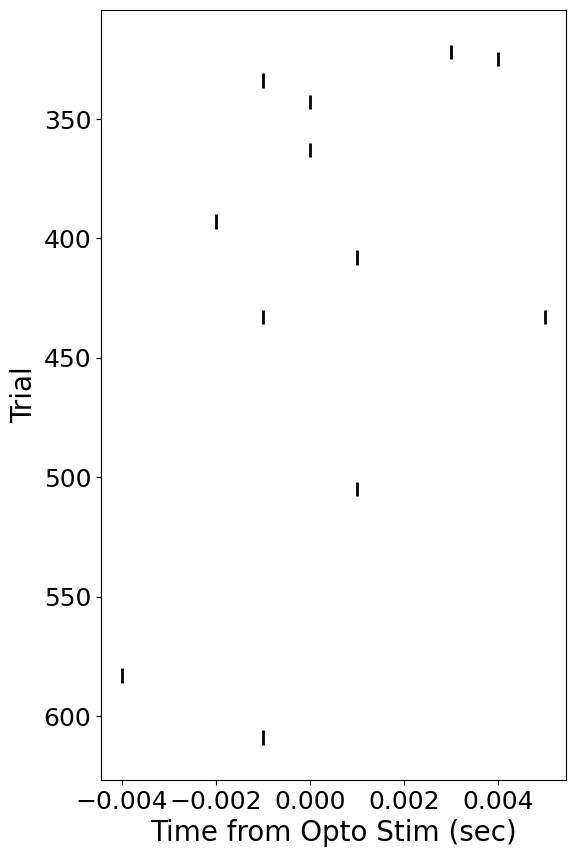

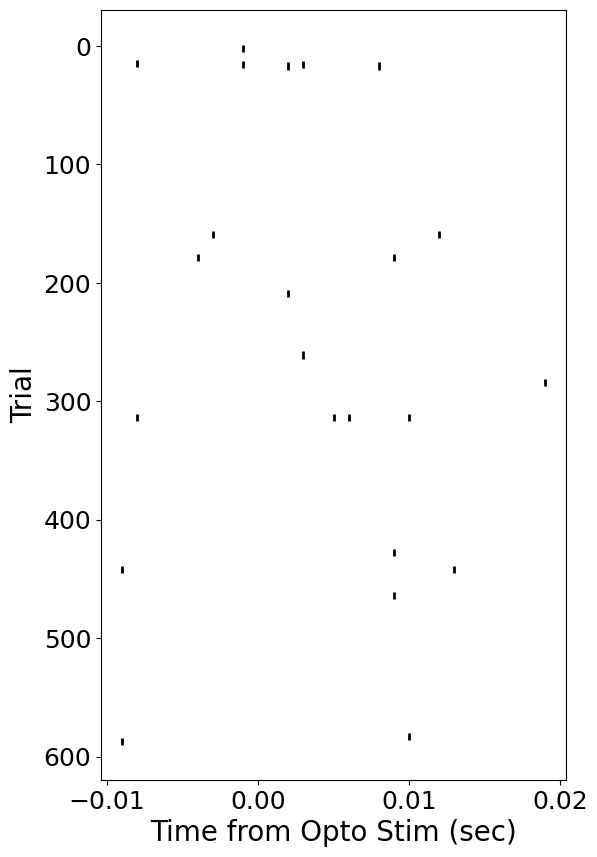

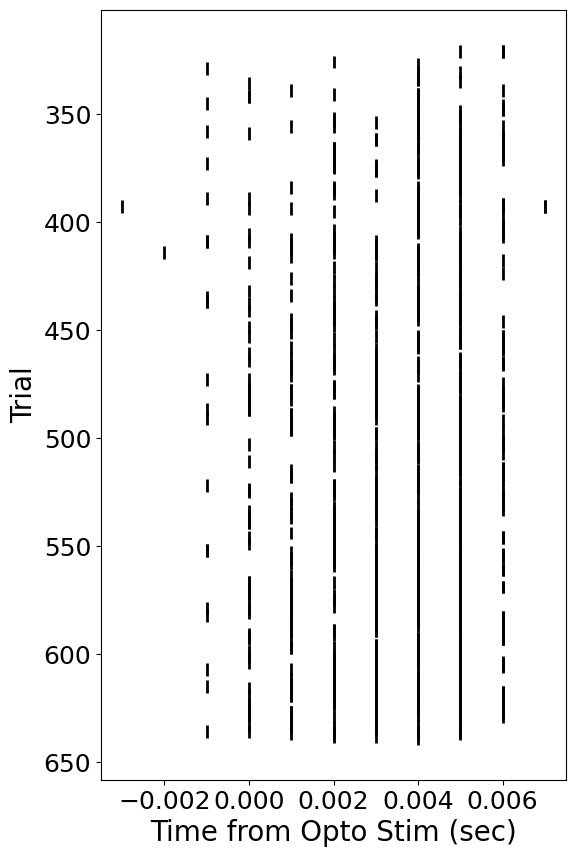

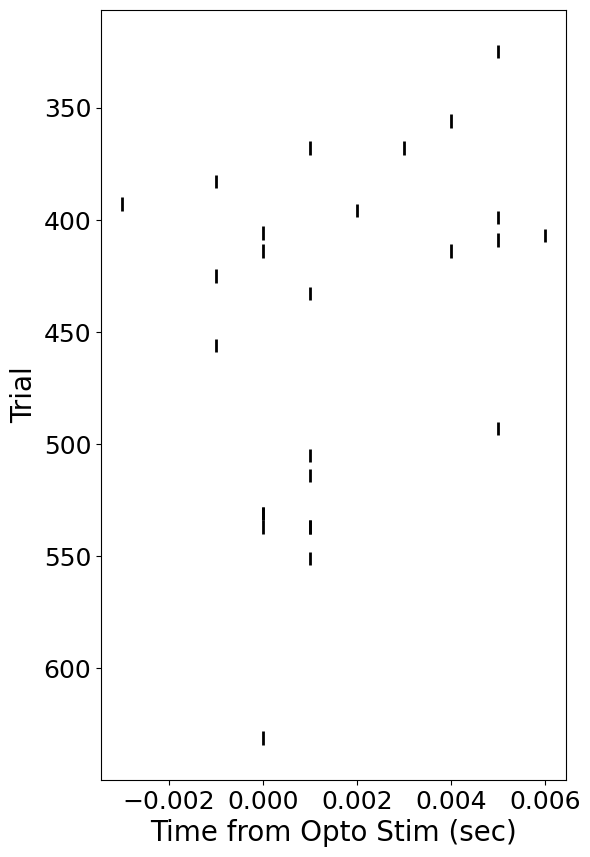

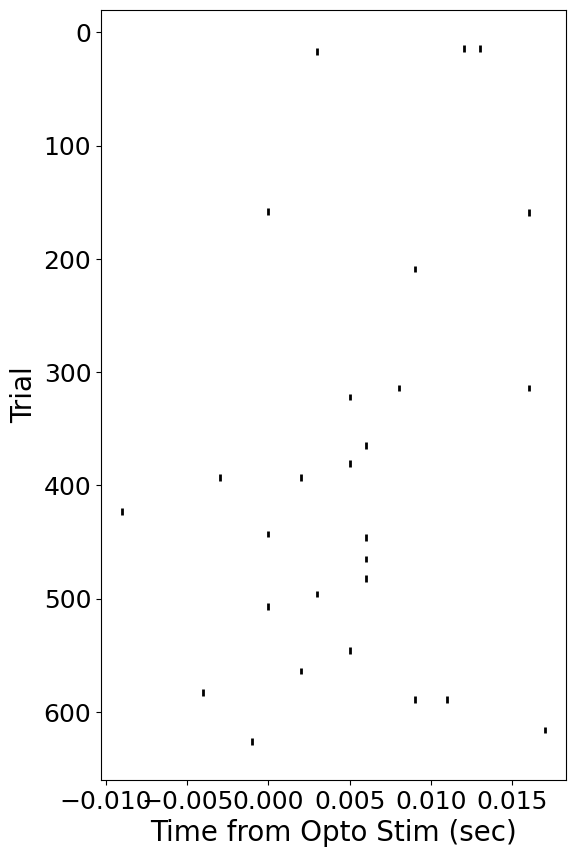

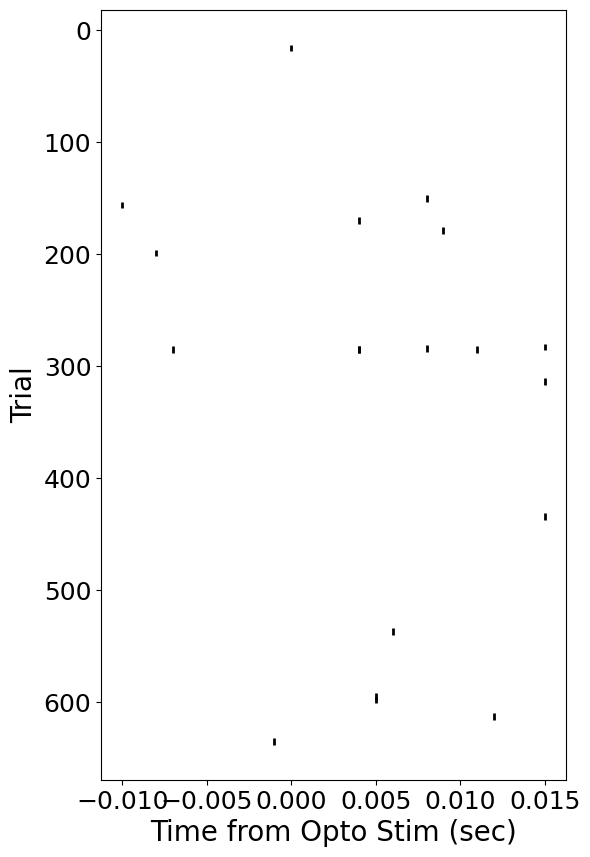

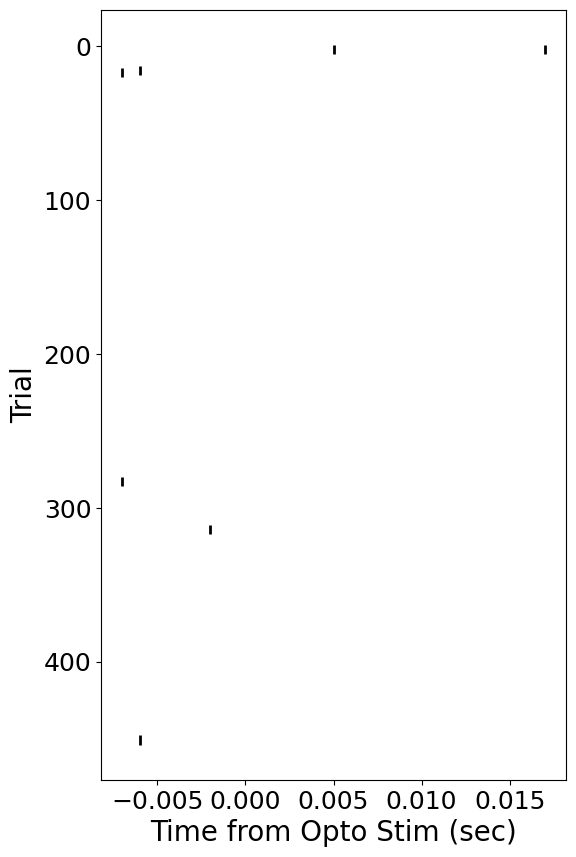

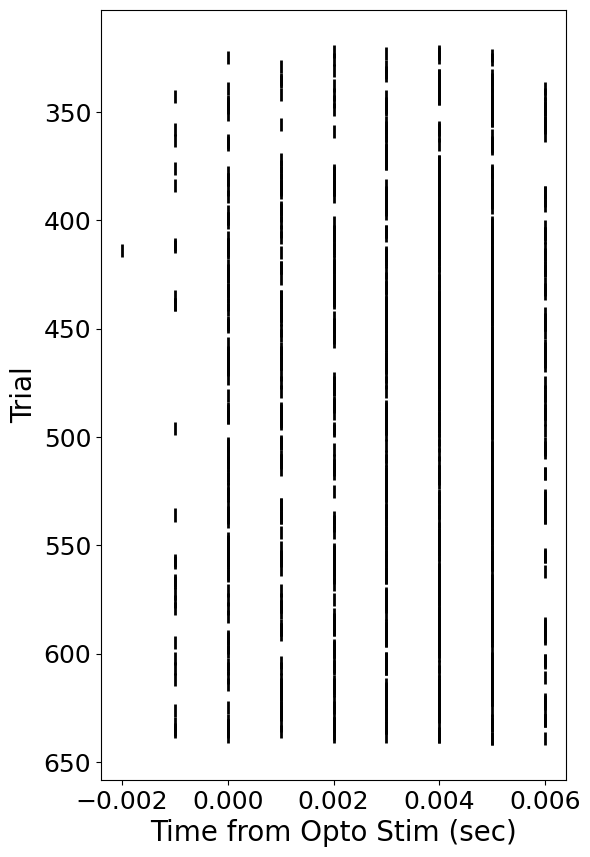

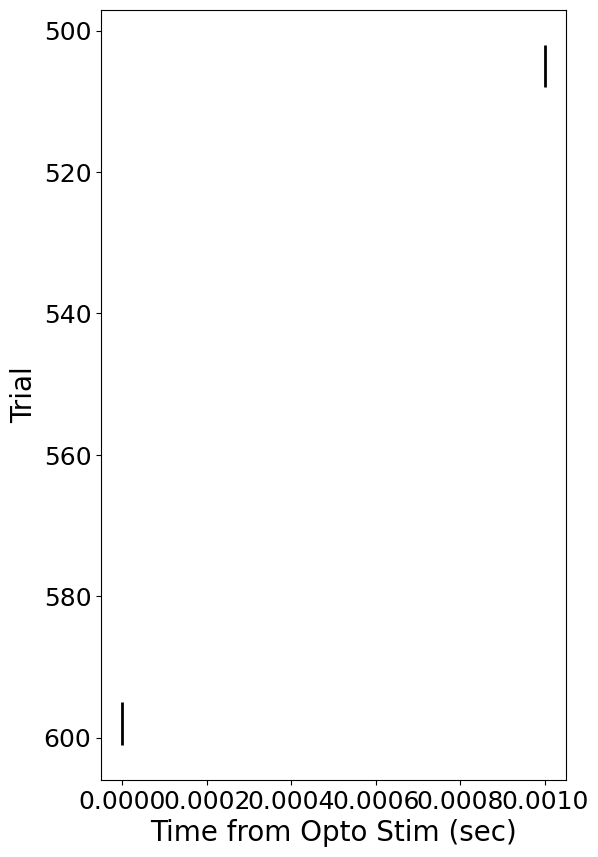

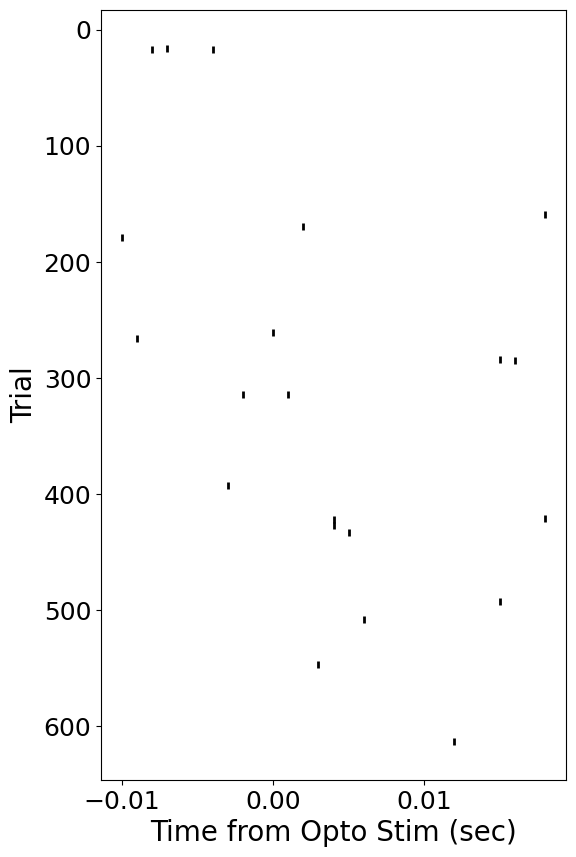

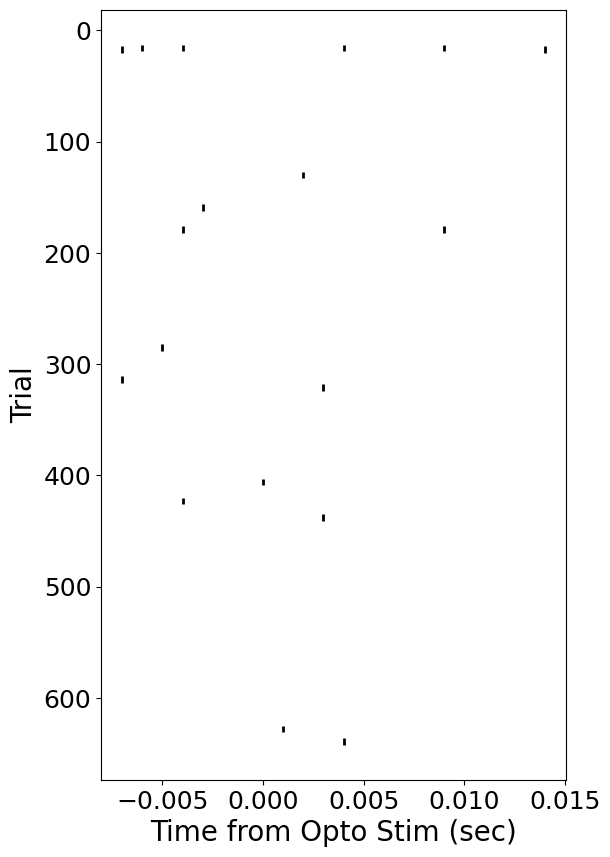

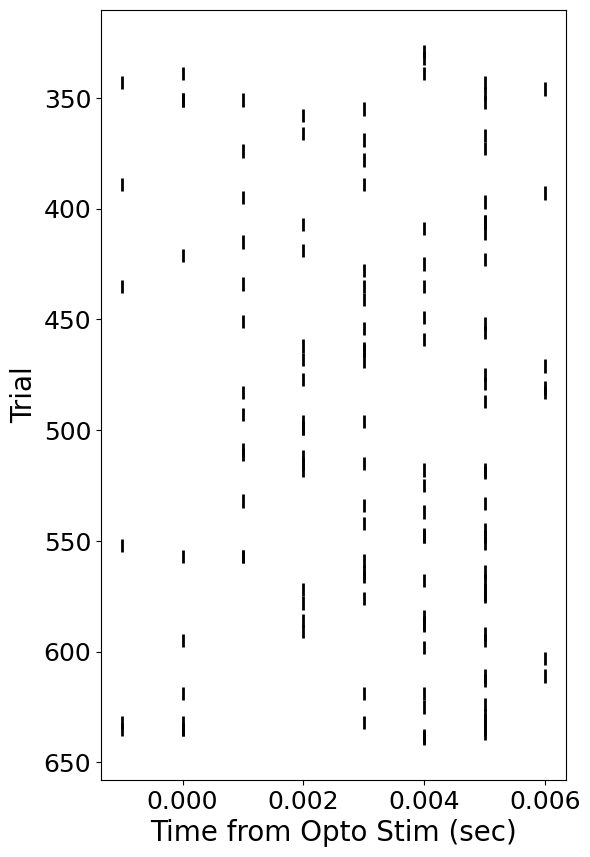

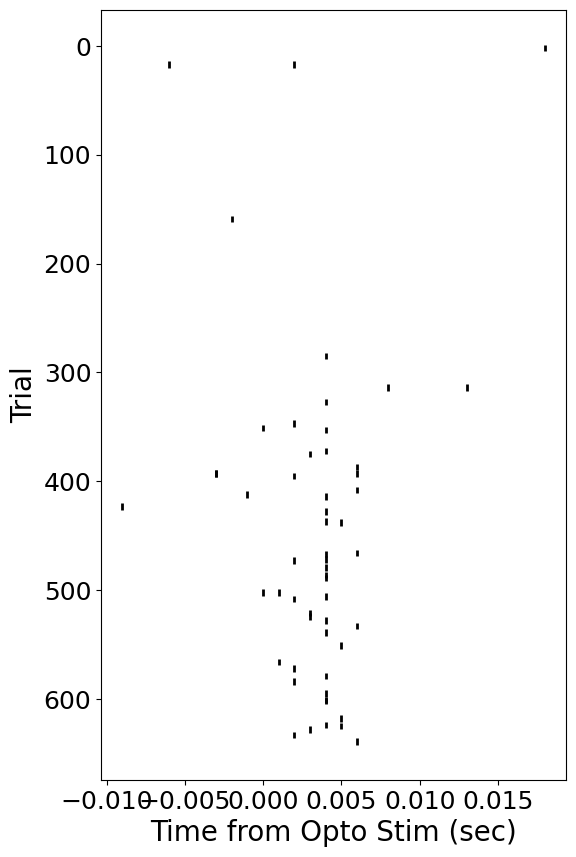

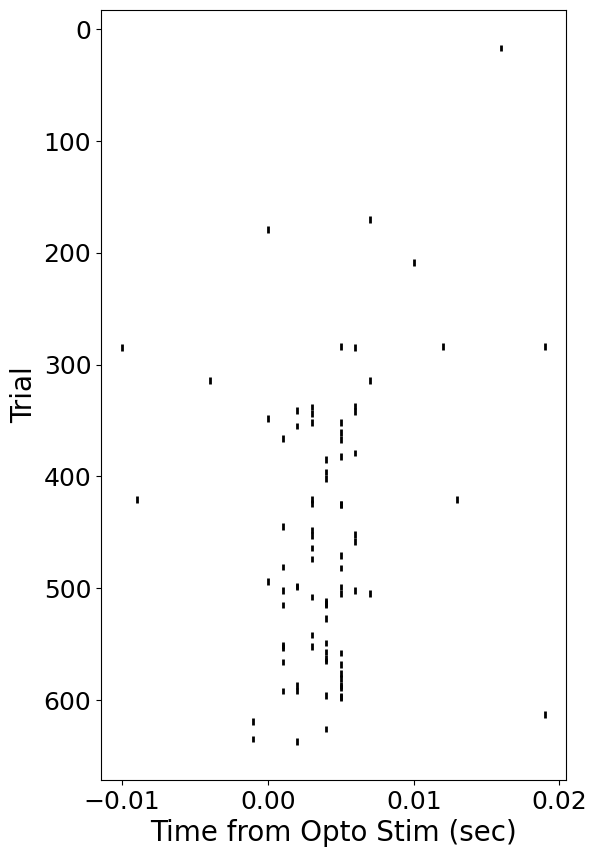

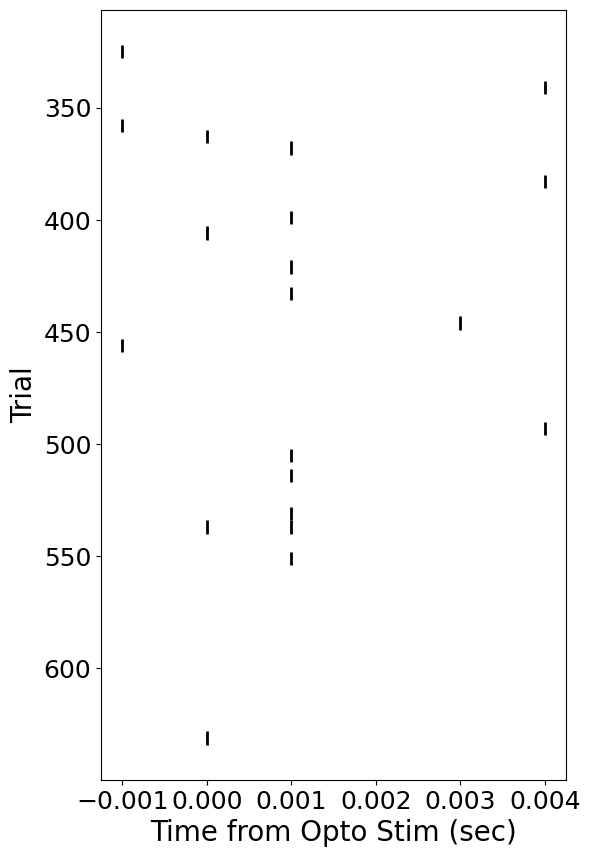

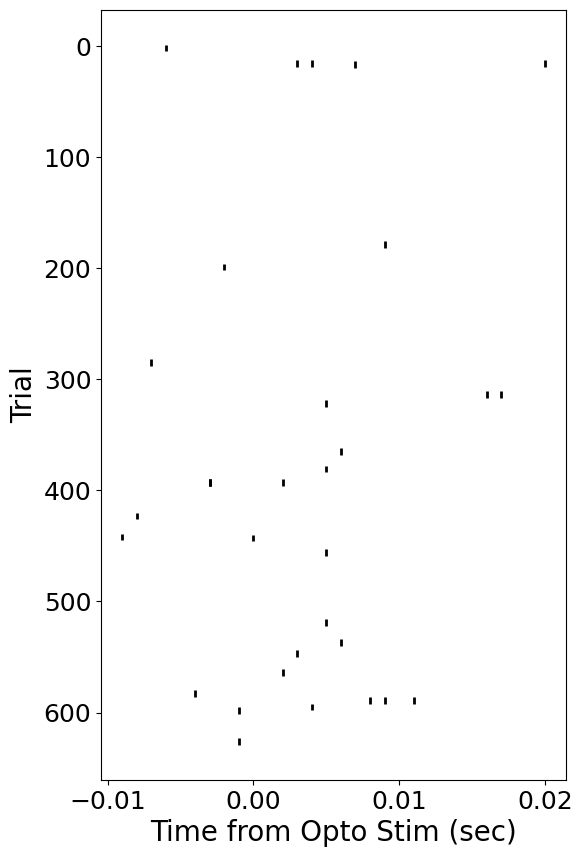

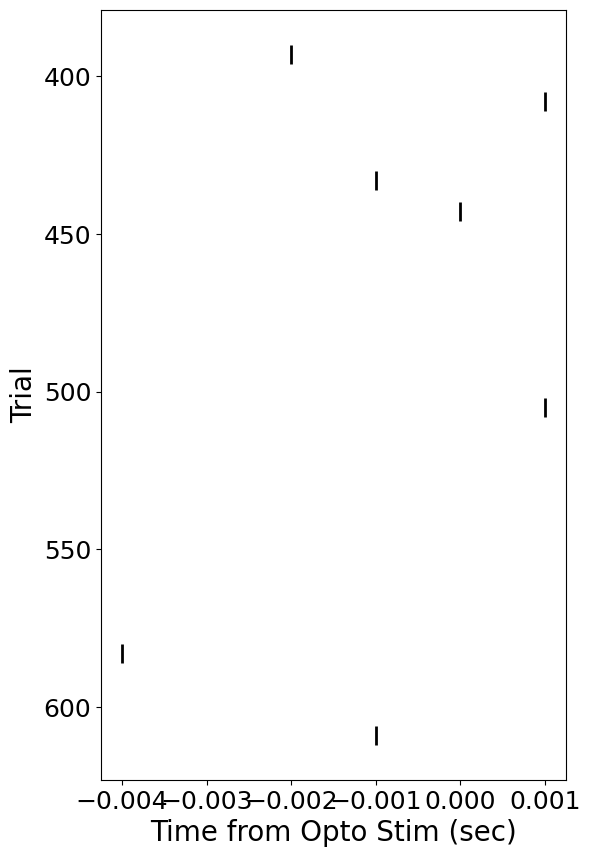

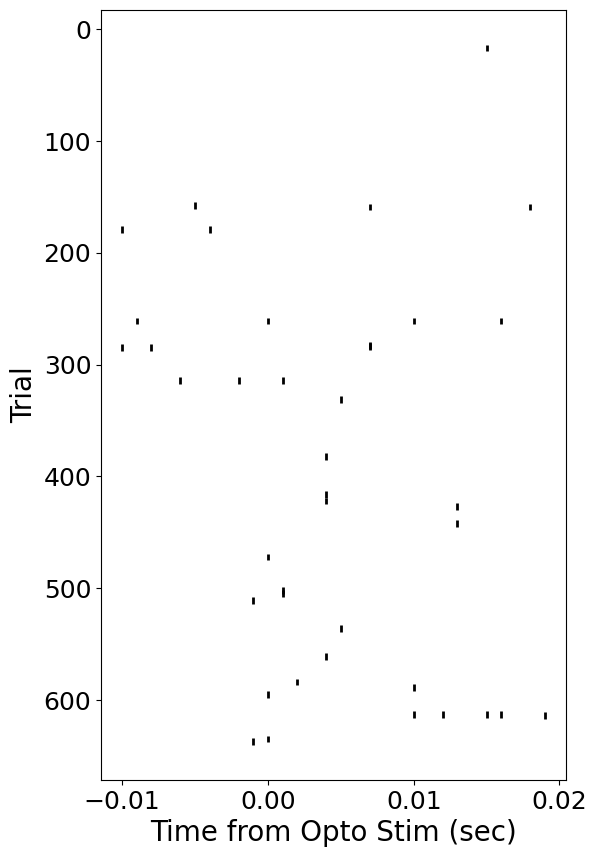

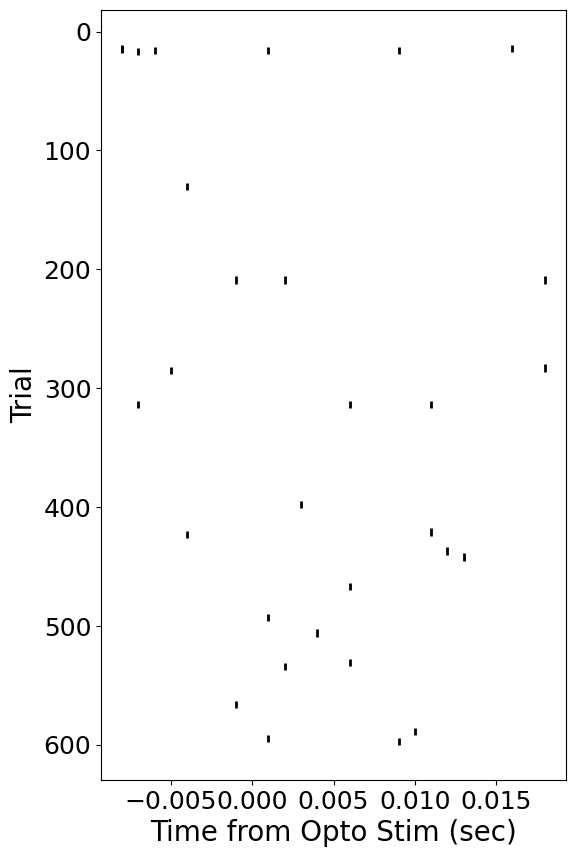

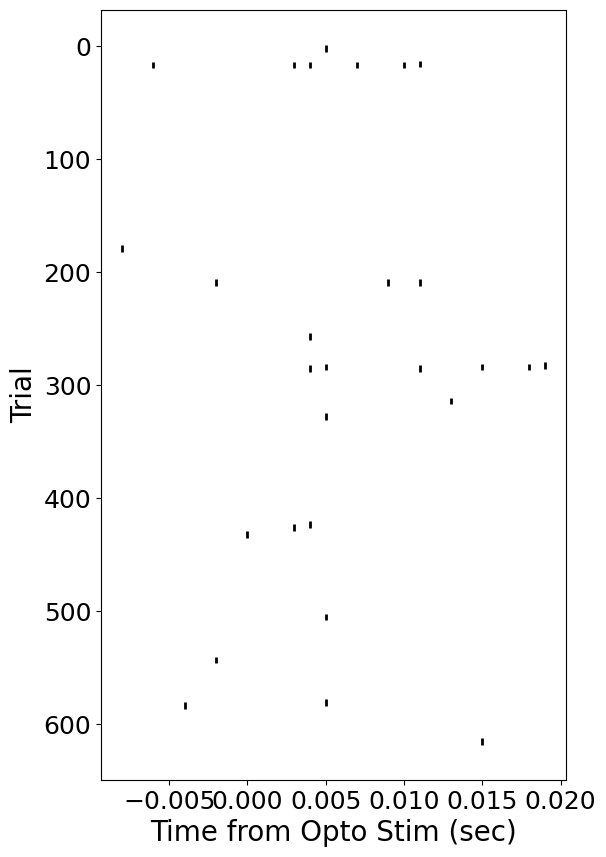

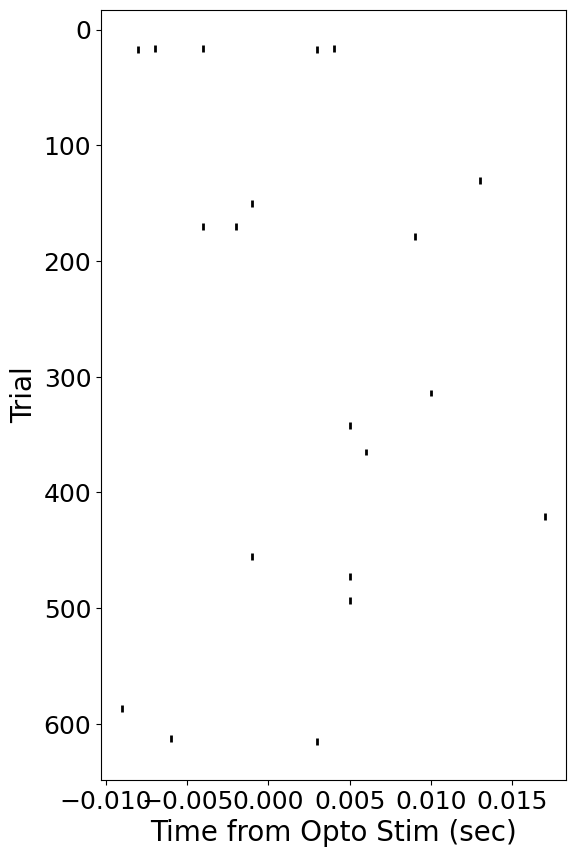

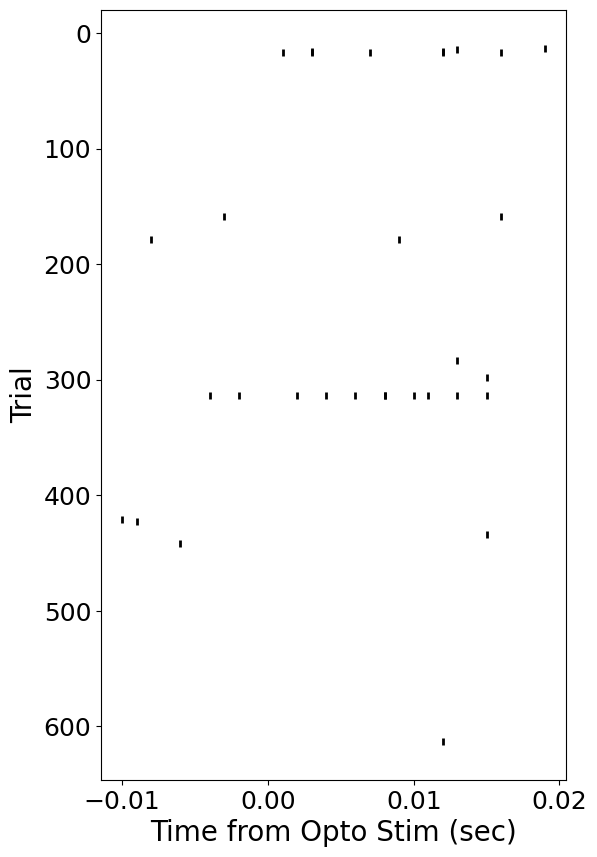

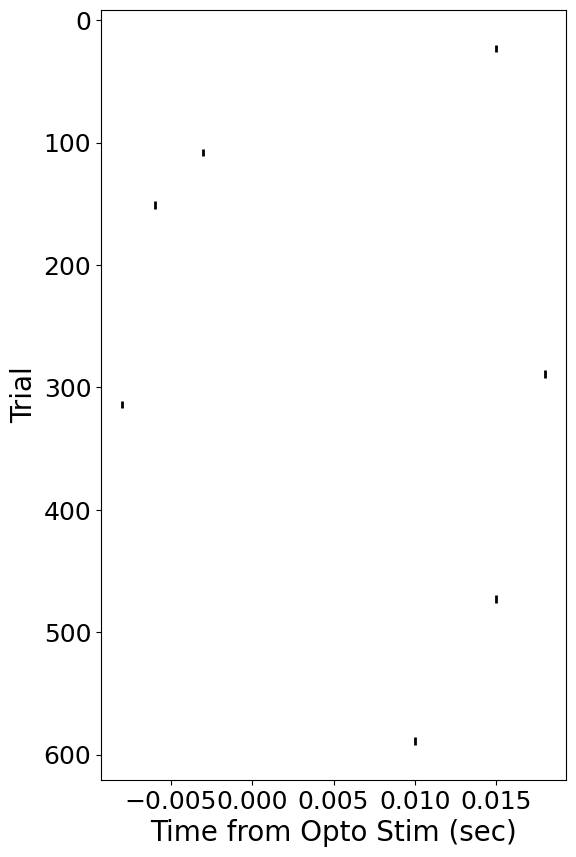

In [9]:
h5file = '/media/jbhunt/EPHYS-01-BACKUP/opto/2025-09-30/ChR2GAD2/output.hdf'
session = AnalysisObject(h5file)
for unit in session._population():
    if unit.cluster not in qualityUnits:
        continue
    spikeTimes = unit.timestamps
    print(unit.cluster)
    pl.plotRaster(optoTimes, spikeTimes, [-0.01, 0.02], 'Opto Stim')